In [2]:
# """
# Phishing Detection Pipeline with Transformer Models for Kaggle
# - Optimized for Kaggle notebook environment
# - Handles Tranco dataset with no column headers (direct URLs)
# - Focuses on detecting nested phishing links in advertisements
# """

# import os
# import numpy as np
# import pandas as pd
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader, random_split
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import (
#     accuracy_score, precision_score, recall_score, f1_score, 
#     roc_auc_score, confusion_matrix, classification_report
# )
# import transformers
# from bs4 import BeautifulSoup
# from urllib.parse import urlparse, parse_qs
# import re
# import time
# import pickle
# import matplotlib.pyplot as plt
# import seaborn as sns
# from tqdm.auto import tqdm
# import requests
# from concurrent.futures import ThreadPoolExecutor
# import gc  # For memory management on Kaggle

# # Configure paths for Kaggle
# INPUT_DIR = "../input/"
# OUTPUT_DIR = "./"
# MODEL_DIR = "./models/"
# DATA_DIR = "./processed_data/"

# # Create directories if they don't exist
# os.makedirs(MODEL_DIR, exist_ok=True)
# os.makedirs(DATA_DIR, exist_ok=True)

# # Configure logging for Kaggle
# import logging
# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# logger = logging.getLogger("phishing_pipeline")

# #######################
# # Data Loading Module #
# #######################

# def load_all_datasets(urlset_path, mendeley_path=None, tranco_path=None):
#     """
#     Load and prepare all available datasets, with special handling for Tranco
    
#     Args:
#         urlset_path: Path to urlset.csv
#         mendeley_path: Path to Mendeley dataset
#         tranco_path: Path to Tranco list (no column headers, direct URLs)
        
#     Returns:
#         Dictionary of DataFrames
#     """
#     datasets = {}
    
#     # Load urlset.csv
#     try:
#         urlset_df = pd.read_csv(urlset_path)
#         print(f"Loaded urlset.csv with {urlset_df.shape[0]} rows and {urlset_df.shape[1]} columns")
        
#         # Check if 'url' column exists, if not, try to create one
#         if 'url' not in urlset_df.columns:
#             # Try to identify URL column
#             potential_url_cols = [col for col in urlset_df.columns if 'url' in col.lower()]
#             if potential_url_cols:
#                 urlset_df['url'] = urlset_df[potential_url_cols[0]]
#             else:
#                 # Create URL column from first column if it looks like a domain or URL
#                 first_col = urlset_df.columns[0]
#                 urlset_df['url'] = urlset_df[first_col].apply(
#                     lambda x: f"http://{x}" if isinstance(x, str) and not x.startswith('http') else x
#                 )
        
#         datasets['urlset'] = urlset_df
#     except Exception as e:
#         print(f"Error loading urlset.csv: {e}")
    
#     # Load Mendeley dataset if provided
#     if mendeley_path and os.path.exists(mendeley_path):
#         try:
#             mendeley_df = pd.read_csv(mendeley_path)
#             print(f"Loaded Mendeley dataset with {mendeley_df.shape[0]} rows and {mendeley_df.shape[1]} columns")
#             datasets['mendeley'] = mendeley_df
#         except Exception as e:
#             print(f"Error loading Mendeley dataset: {e}")
    
#     # Load Tranco list if provided - special handling for no column headers
#     if tranco_path and os.path.exists(tranco_path):
#         try:
#             # Load Tranco with no headers, first column contains URLs
#             tranco_df = pd.read_csv(tranco_path, header=None)
            
#             # Rename the first column to 'url' and ensure proper URL format
#             tranco_df.rename(columns={0: 'url'}, inplace=True)
#             tranco_df['url'] = tranco_df['url'].apply(
#                 lambda x: f"https://{x}" if isinstance(x, str) and not x.startswith('http') else x
#             )
            
#             # Extract domain from URL
#             tranco_df['domain'] = tranco_df['url'].apply(
#                 lambda x: urlparse(x).netloc if isinstance(x, str) else ""
#             )
            
#             # Add is_phishing column (Tranco domains are legitimate)
#             tranco_df['is_phishing'] = 0
            
#             print(f"Loaded Tranco dataset with {tranco_df.shape[0]} domains")
#             datasets['tranco'] = tranco_df
#         except Exception as e:
#             print(f"Error loading Tranco dataset: {e}")
    
#     return datasets

# # Harmonization function remains the same as in the original code
# def harmonize_datasets(datasets):
#     """
#     Harmonize feature names and structures across datasets
    
#     Args:
#         datasets: Dictionary of DataFrames
        
#     Returns:
#         Dictionary of harmonized DataFrames
#     """
#     harmonized = {}
    
#     # Define mappings between different feature naming conventions
#     mendeley_to_standard = {
#         'qty_dot_url': 'num_dots',
#         'qty_hyphen_url': 'num_hyphens',
#         'qty_underline_url': 'num_underscores', 
#         'qty_slash_url': 'num_slashes',
#         'qty_questionmark_url': 'num_question_marks',
#         'qty_equal_url': 'num_equal_signs',
#         'qty_at_url': 'num_at_signs',
#         'qty_and_url': 'num_ampersands',
#         'qty_exclamation_url': 'num_exclamations',
#         'length_url': 'url_length',
#         'domain_length': 'domain_length',
#         'phishing': 'is_phishing'
#     }
    
#     # Process each dataset
#     for name, df in datasets.items():
#         # Make a copy to avoid modifying original
#         df_copy = df.copy()
        
#         # Ensure URL column exists and contains proper URLs
#         if 'url' in df_copy.columns:
#             # Ensure URLs start with http
#             df_copy['url'] = df_copy['url'].apply(
#                 lambda x: f"http://{x}" if isinstance(x, str) and not x.startswith('http') else x
#             )
#         elif 'domain' in df_copy.columns:
#             # Create URLs from domains
#             df_copy['url'] = df_copy['domain'].apply(
#                 lambda x: f"https://{x}" if isinstance(x, str) else ""
#             )
        
#         # Extract domain from URL if not present
#         if 'url' in df_copy.columns and 'domain' not in df_copy.columns:
#             df_copy['domain'] = df_copy['url'].apply(
#                 lambda x: urlparse(x).netloc if isinstance(x, str) else ""
#             )
        
#         # Handle Mendeley dataset column renaming
#         if name == 'mendeley':
#             for old_name, new_name in mendeley_to_standard.items():
#                 if old_name in df_copy.columns:
#                     df_copy[new_name] = df_copy[old_name]
        
#         # Ensure phishing label is consistently named
#         if 'is_phishing' not in df_copy.columns:
#             # Check for alternative column names
#             phishing_cols = ['phishing', 'label', 'is_malicious', 'malicious']
#             for col in phishing_cols:
#                 if col in df_copy.columns:
#                     # Convert to binary
#                     try:
#                         if df_copy[col].dtype == 'object':
#                             # Handle string labels
#                             df_copy['is_phishing'] = df_copy[col].apply(
#                                 lambda x: 1 if str(x).lower() in ['phishing', 'malicious', '1', 'true', 'yes'] else 0
#                             )
#                         else:
#                             # Handle numeric
#                             df_copy['is_phishing'] = df_copy[col].astype(int)
#                     except:
#                         print(f"Could not convert {col} to binary is_phishing in {name} dataset")
#                     break
            
#             # If still no is_phishing column, make assumptions based on dataset
#             if 'is_phishing' not in df_copy.columns:
#                 if name == 'tranco':
#                     # Tranco domains are legitimate
#                     df_copy['is_phishing'] = 0
#                 elif name == 'urlset':
#                     # If urlset has no label, assume we don't know
#                     df_copy['is_phishing'] = -1  # Unknown
        
#         harmonized[name] = df_copy
    
#     return harmonized

# def create_unified_dataset(datasets):
#     """
#     Merge harmonized datasets into a single unified dataset
    
#     Args:
#         datasets: Dictionary of harmonized DataFrames
        
#     Returns:
#         Unified DataFrame
#     """
#     all_dfs = []
    
#     # Add dataset source identifier
#     for name, df in datasets.items():
#         df_copy = df.copy()
#         df_copy['data_source'] = name
#         all_dfs.append(df_copy)
    
#     # Concatenate all datasets
#     if not all_dfs:
#         return pd.DataFrame()
    
#     unified_df = pd.concat(all_dfs, ignore_index=True)
    
#     # Remove duplicate URLs
#     if 'url' in unified_df.columns:
#         # Keep higher quality data when duplicates exist
#         # Priority: Mendeley > urlset > Tranco
#         def source_priority(source):
#             if source == 'mendeley':
#                 return 1
#             elif source == 'urlset':
#                 return 2
#             elif source == 'tranco':
#                 return 3
#             else:
#                 return 4
        
#         # Add priority column
#         unified_df['source_priority'] = unified_df['data_source'].apply(source_priority)
        
#         # Sort by priority and drop duplicates
#         unified_df.sort_values('source_priority', inplace=True)
#         before_dedup = len(unified_df)
#         unified_df.drop_duplicates(subset=['url'], keep='first', inplace=True)
#         after_dedup = len(unified_df)
        
#         # Drop priority column
#         unified_df.drop('source_priority', axis=1, inplace=True)
        
#         print(f"Removed {before_dedup - after_dedup} duplicate URLs")
    
#     # Print summary statistics
#     print(f"Unified dataset has {unified_df.shape[0]} rows and {unified_df.shape[1]} columns")
#     if 'is_phishing' in unified_df.columns:
#         phishing_counts = unified_df['is_phishing'].value_counts()
#         print(f"Phishing distribution: {phishing_counts.to_dict()}")
    
#     # Remove rows with NaN labels or URLs
#     unified_df = unified_df.dropna(subset=['url'])
#     if 'is_phishing' in unified_df.columns:
#         unified_df = unified_df.dropna(subset=['is_phishing'])
    
#     return unified_df

# ############################
# # Feature Extraction Module #
# ############################

# def extract_url_features(url):
#     """Extract basic URL features"""
#     try:
#         if not isinstance(url, str) or not url:
#             return {}
            
#         parsed = urlparse(url)
#         domain = parsed.netloc
#         path = parsed.path
#         query = parsed.query
        
#         features = {
#             'url_length': len(url),
#             'domain_length': len(domain),
#             'path_length': len(path),
#             'query_length': len(query),
#             'num_dots': url.count('.'),
#             'num_hyphens': url.count('-'),
#             'num_underscores': url.count('_'),
#             'num_slashes': url.count('/'),
#             'num_question_marks': url.count('?'),
#             'num_equal_signs': url.count('='),
#             'num_at_signs': url.count('@'),
#             'num_ampersands': url.count('&'),
#             'num_exclamations': url.count('!'),
#             'has_ip_address': bool(re.match(r'\d+\.\d+\.\d+\.\d+', domain)),
#             'subdomain_count': len(domain.split('.')) - 1 if domain else 0,
#             'is_https': 1 if parsed.scheme == 'https' else 0,
#         }
        
#         return features
#     except Exception as e:
#         print(f"Error extracting features for URL {url}: {e}")
#         return {}

# # Rest of the functions for extracting redirection, DOM, and ad features remain the same
# # For brevity, I'm not including them all, but they would be the same as in the original code

# def extract_features_batch(urls, batch_idx, extract_dom=True, extract_redirects=True, 
#                          extract_ads=True, timeout=5):
#     """
#     Extract features for a batch of URLs - Kaggle-optimized version
    
#     Args:
#         urls: List of URLs to process
#         batch_idx: List of corresponding indices
#         extract_dom: Whether to extract DOM features
#         extract_redirects: Whether to extract redirection features
#         extract_ads: Whether to extract ad features
#         timeout: Request timeout in seconds
        
#     Returns:
#         List of (idx, features) tuples
#     """
#     results = []
    
#     for url, idx in zip(urls, batch_idx):
#         try:
#             # Extract basic URL features
#             features = {'url': url}
#             url_features = extract_url_features(url)
#             features.update(url_features)
            
#             # Add redirection features if requested (simplified for Kaggle)
#             if extract_redirects:
#                 try:
#                     # Just check if there's a redirect
#                     response = requests.head(
#                         url, 
#                         allow_redirects=False,
#                         timeout=timeout,
#                         headers={'User-Agent': 'Mozilla/5.0'}
#                     )
                    
#                     has_redirect = response.status_code in [301, 302, 303, 307, 308]
#                     features['redirect_has_redirect'] = int(has_redirect)
#                     features['redirect_chain_length'] = 1 if not has_redirect else 2
#                 except:
#                     features['redirect_has_redirect'] = 0
#                     features['redirect_chain_length'] = 1
            
#             # Add placeholder for DOM features (full DOM extraction can be too heavy for Kaggle)
#             if extract_dom:
#                 features['dom_text'] = ""
#                 features['dom_length'] = 0
            
#             results.append((idx, features))
            
#         except Exception as e:
#             print(f"Error processing URL {url}: {e}")
    
#     return results

# def extract_features_for_dataset(df, url_column='url', extract_dom=False, 
#                                extract_redirects=True, extract_ads=False, 
#                                sample_size=None, n_jobs=4):
#     """
#     Extract features for all URLs in a dataset - Kaggle-optimized version
    
#     Args:
#         df: DataFrame with URLs
#         url_column: Column containing URLs
#         extract_dom: Whether to extract DOM features (limited on Kaggle)
#         extract_redirects: Whether to extract redirection features
#         extract_ads: Whether to extract ad features (limited on Kaggle)
#         sample_size: Optional limit for number of URLs to process
#         n_jobs: Number of parallel jobs
        
#     Returns:
#         DataFrame with extracted features
#     """
#     if url_column not in df.columns:
#         print(f"URL column '{url_column}' not found in DataFrame")
#         return df
    
#     # Sample data if requested
#     if sample_size and sample_size < len(df):
#         print(f"Using sample of {sample_size} URLs for feature extraction")
#         sample_df = df.sample(sample_size, random_state=42)
#     else:
#         sample_df = df.copy()
    
#     # Filter to valid URLs
#     valid_urls = sample_df[url_column].apply(
#         lambda x: isinstance(x, str) and x.startswith('http')
#     )
#     valid_df = sample_df[valid_urls].copy()
    
#     if len(valid_df) == 0:
#         print("No valid URLs found in dataset")
#         return df
    
#     print(f"Extracting features for {len(valid_df)} URLs with {n_jobs} workers")
    
#     # Process in batches to manage memory
#     batch_size = 100  # Smaller batch size for Kaggle
#     all_features = []
    
#     for i in range(0, len(valid_df), batch_size):
#         batch = valid_df.iloc[i:i+batch_size]
#         print(f"Processing batch {i//batch_size + 1}/{(len(valid_df) + batch_size - 1) // batch_size}")
        
#         urls = batch[url_column].tolist()
#         indices = batch.index.tolist()
        
#         # For Kaggle, use less parallelism to avoid memory issues
#         n_jobs_batch = min(n_jobs, 2)
        
#         with ThreadPoolExecutor(max_workers=n_jobs_batch) as executor:
#             # Split into smaller chunks for parallel processing
#             chunk_size = max(1, len(urls) // n_jobs_batch)
#             futures = []
            
#             for j in range(0, len(urls), chunk_size):
#                 end_idx = min(j + chunk_size, len(urls))
#                 url_chunk = urls[j:end_idx]
#                 idx_chunk = indices[j:end_idx]
                
#                 futures.append(executor.submit(
#                     extract_features_batch, 
#                     url_chunk, 
#                     idx_chunk,
#                     extract_dom, 
#                     extract_redirects, 
#                     extract_ads
#                 ))
            
#             # Collect results
#             for future in futures:
#                 try:
#                     batch_results = future.result()
#                     all_features.extend(batch_results)
#                 except Exception as e:
#                     print(f"Error in feature extraction batch: {e}")
        
#         # Clear memory periodically
#         gc.collect()
    
#     # Convert to DataFrame
#     if not all_features:
#         print("No features were successfully extracted")
#         return df
    
#     features_dict = {idx: features for idx, features in all_features}
#     features_df = pd.DataFrame.from_dict(features_dict, orient='index')
    
#     # Join with original DataFrame
#     result_df = valid_df.join(
#         features_df[[col for col in features_df.columns 
#                    if col != 'url' and col not in valid_df.columns]]
#     )
    
#     print(f"Successfully extracted features for {len(result_df)} URLs")
    
#     return result_df

# #########################
# # Tokenizer Module      #
# #########################

# class URLTokenizer:
#     """Tokenizer for URLs with proper type checking"""
#     def __init__(self, vocab_size=30000, max_length=128):
#         self.vocab_size = vocab_size
#         self.max_length = max_length
#         self.char_to_idx = {}
#         self.idx_to_char = {}
#         self.special_tokens = {
#             '<PAD>': 0,
#             '<UNK>': 1,
#             '<CLS>': 2,
#             '<SEP>': 3
#         }
        
#         # Initialize with special tokens
#         for token, idx in self.special_tokens.items():
#             self.char_to_idx[token] = idx
#             self.idx_to_char[idx] = token
        
#         # Initialize with ASCII characters
#         for i in range(32, 128):
#             char = chr(i)
#             if char not in self.char_to_idx:
#                 idx = len(self.char_to_idx)
#                 self.char_to_idx[char] = idx
#                 self.idx_to_char[idx] = char
    
#     def tokenize(self, url):
#         """Tokenize URL to token indices with proper type checking"""
#         # Handle non-string URLs (fixes the IndexError)
#         if not isinstance(url, str) or url is None:
#             # Return default tokens for non-string URLs
#             tokens = [self.special_tokens['<CLS>'], self.special_tokens['<SEP>']]
#             attention_mask = [1, 1]
            
#             # Pad to max_length
#             padding_length = self.max_length - len(tokens)
#             tokens.extend([self.special_tokens['<PAD>']] * padding_length)
#             attention_mask.extend([0] * padding_length)
            
#             return tokens, attention_mask
        
#         # Process valid string URL
#         tokens = [self.special_tokens['<CLS>']]
        
#         # Convert characters to token indices
#         for char in url[:self.max_length - 2]:  # -2 for <CLS> and <SEP>
#             if char in self.char_to_idx:
#                 tokens.append(self.char_to_idx[char])
#             else:
#                 tokens.append(self.special_tokens['<UNK>'])
        
#         tokens.append(self.special_tokens['<SEP>'])
        
#         # Create attention mask
#         attention_mask = [1] * len(tokens)
        
#         # Pad to max_length
#         padding_length = self.max_length - len(tokens)
#         if padding_length > 0:
#             tokens.extend([self.special_tokens['<PAD>']] * padding_length)
#             attention_mask.extend([0] * padding_length)
        
#         return tokens, attention_mask
    
#     def save(self, path):
#         """Save tokenizer to file"""
#         with open(path, 'wb') as f:
#             pickle.dump({
#                 'vocab_size': self.vocab_size,
#                 'max_length': self.max_length,
#                 'char_to_idx': self.char_to_idx,
#                 'idx_to_char': self.idx_to_char,
#                 'special_tokens': self.special_tokens
#             }, f)
    
#     @classmethod
#     def load(cls, path):
#         """Load tokenizer from file"""
#         with open(path, 'rb') as f:
#             data = pickle.load(f)
        
#         tokenizer = cls(
#             vocab_size=data['vocab_size'],
#             max_length=data['max_length']
#         )
#         tokenizer.char_to_idx = data['char_to_idx']
#         tokenizer.idx_to_char = data['idx_to_char']
#         tokenizer.special_tokens = data['special_tokens']
        
#         return tokenizer

# class DOMTokenizer:
#     """Tokenizer for DOM structure - simplified for Kaggle"""
#     def __init__(self, vocab_size=10000, max_length=512):
#         self.vocab_size = vocab_size
#         self.max_length = max_length
#         self.token_to_idx = {}
#         self.idx_to_token = {}
#         self.special_tokens = {
#             '<PAD>': 0,
#             '<UNK>': 1,
#             '<CLS>': 2,
#             '<SEP>': 3
#         }
        
#         # Initialize with special tokens
#         for token, idx in self.special_tokens.items():
#             self.token_to_idx[token] = idx
#             self.idx_to_token[idx] = token
        
#         # Add some common HTML tags
#         common_tags = ['<html>', '</html>', '<body>', '</body>', '<div>', '</div>', 
#                       '<a>', '</a>', '<p>', '</p>', '<span>', '</span>']
#         for tag in common_tags:
#             if tag not in self.token_to_idx:
#                 idx = len(self.token_to_idx)
#                 self.token_to_idx[tag] = idx
#                 self.idx_to_token[idx] = tag
    
#     def tokenize(self, dom_text):
#         """Tokenize DOM text to token indices"""
#         if not dom_text:
#             # Return empty sequence
#             tokens = [self.special_tokens['<CLS>'], self.special_tokens['<SEP>']]
#             attention_mask = [1, 1]
            
#             # Pad to max_length
#             padding_length = self.max_length - len(tokens)
#             tokens.extend([self.special_tokens['<PAD>']] * padding_length)
#             attention_mask.extend([0] * padding_length)
            
#             return tokens, attention_mask
        
#         tokens = [self.special_tokens['<CLS>']]
        
#         # Convert tokens to indices
#         dom_tokens = dom_text.split()
#         for token in dom_tokens[:self.max_length - 2]:  # -2 for <CLS> and <SEP>
#             if token in self.token_to_idx:
#                 tokens.append(self.token_to_idx[token])
#             else:
#                 tokens.append(self.special_tokens['<UNK>'])
        
#         tokens.append(self.special_tokens['<SEP>'])
        
#         # Create attention mask
#         attention_mask = [1] * len(tokens)
        
#         # Pad to max_length
#         padding_length = self.max_length - len(tokens)
#         if padding_length > 0:
#             tokens.extend([self.special_tokens['<PAD>']] * padding_length)
#             attention_mask.extend([0] * padding_length)
        
#         return tokens, attention_mask
    
#     def save(self, path):
#         """Save tokenizer to file"""
#         with open(path, 'wb') as f:
#             pickle.dump({
#                 'vocab_size': self.vocab_size,
#                 'max_length': self.max_length,
#                 'token_to_idx': self.token_to_idx,
#                 'idx_to_token': self.idx_to_token,
#                 'special_tokens': self.special_tokens
#             }, f)
    
#     @classmethod
#     def load(cls, path):
#         """Load tokenizer from file"""
#         with open(path, 'rb') as f:
#             data = pickle.load(f)
        
#         tokenizer = cls(
#             vocab_size=data['vocab_size'],
#             max_length=data['max_length']
#         )
#         tokenizer.token_to_idx = data['token_to_idx']
#         tokenizer.idx_to_token = data['idx_to_token']
#         tokenizer.special_tokens = data['special_tokens']
        
#         return tokenizer

# ########################
# # Dataset Module       #
# ########################

# class PhishingDataset(Dataset):
#     """Dataset with improved error handling"""
#     def __init__(self, df, url_column='url', label_column='is_phishing', 
#                  url_tokenizer=None, dom_tokenizer=None,
#                  tabular_columns=None, dom_column='dom_text'):
#         # Make a copy to avoid modifying the original
#         self.df = df.copy()
#         self.url_column = url_column
#         self.label_column = label_column
#         self.url_tokenizer = url_tokenizer
#         self.dom_tokenizer = dom_tokenizer
#         self.dom_column = dom_column
        
#         # Ensure URL column exists
#         if url_column not in self.df.columns:
#             raise ValueError(f"URL column '{url_column}' not found in DataFrame")
            
#         # Clean the URLs - convert to strings and replace None values
#         self.df[url_column] = self.df[url_column].apply(
#             lambda x: str(x) if x is not None else ""
#         )
        
#         # Select tabular columns
#         if tabular_columns:
#             self.tabular_columns = [col for col in tabular_columns if col in self.df.columns]
#         else:
#             numeric_columns = self.df.select_dtypes(include=['number']).columns
#             self.tabular_columns = [col for col in numeric_columns 
#                                    if col != label_column and 'index' not in col.lower()]
        
#         print(f"PhishingDataset: Using {len(self.tabular_columns)} tabular features")
        
#         # Handle missing DOM texts
#         if dom_tokenizer and dom_column not in self.df.columns:
#             self.df[dom_column] = ""
        
#         # Prepare tabular features
#         self._prepare_tabular_features()
    
#     def _prepare_tabular_features(self):
#         """Prepare tabular features for the model with improved error handling"""
#         # Replace infinities and NaNs
#         self.df[self.tabular_columns] = self.df[self.tabular_columns].replace([np.inf, -np.inf], np.nan)
        
#         # Fill NaNs with column means or zeros
#         for col in self.tabular_columns:
#             if self.df[col].isna().all():
#                 self.df[col] = 0
#             else:
#                 self.df[col] = self.df[col].fillna(self.df[col].mean())
        
#         # Scale features
#         self.scaler = StandardScaler()
#         self.df[self.tabular_columns] = self.scaler.fit_transform(self.df[self.tabular_columns])
    
#     def __len__(self):
#         return len(self.df)
    
#     def __getitem__(self, idx):
#         try:
#             row = self.df.iloc[idx]
#             url = row[self.url_column]
            
#             # Get label, ensuring it's a number
#             if self.label_column in self.df.columns:
#                 label = float(row[self.label_column])
#             else:
#                 label = 0.0
            
#             # Get tabular features with error handling
#             try:
#                 tabular_features = row[self.tabular_columns].values.astype(np.float32)
#             except:
#                 # If there's an issue, create an array of zeros
#                 tabular_features = np.zeros(len(self.tabular_columns), dtype=np.float32)
            
#             # Tokenize URL (tokenizer handles invalid URLs)
#             if self.url_tokenizer:
#                 url_tokens, url_mask = self.url_tokenizer.tokenize(url)
#             else:
#                 url_tokens = [0]
#                 url_mask = [0]
            
#             # Tokenize DOM with error handling
#             if self.dom_tokenizer and self.dom_column in self.df.columns:
#                 dom_text = row.get(self.dom_column, "")
#                 if not isinstance(dom_text, str):
#                     dom_text = ""
#                 dom_tokens, dom_mask = self.dom_tokenizer.tokenize(dom_text)
#             else:
#                 dom_tokens = [0]
#                 dom_mask = [0]
            
#             return {
#                 'url': url,
#                 'url_tokens': torch.tensor(url_tokens, dtype=torch.long),
#                 'url_mask': torch.tensor(url_mask, dtype=torch.float),
#                 'dom_tokens': torch.tensor(dom_tokens, dtype=torch.long),
#                 'dom_mask': torch.tensor(dom_mask, dtype=torch.float),
#                 'tabular_features': torch.tensor(tabular_features, dtype=torch.float),
#                 'label': torch.tensor(label, dtype=torch.float)
#             }
#         except Exception as e:
#             # Provide a default return value in case of any error
#             print(f"Error loading item {idx}: {e}")
#             return {
#                 'url': "",
#                 'url_tokens': torch.tensor([2, 3] + [0] * (self.url_tokenizer.max_length - 2), dtype=torch.long),
#                 'url_mask': torch.tensor([1, 1] + [0] * (self.url_tokenizer.max_length - 2), dtype=torch.float),
#                 'dom_tokens': torch.tensor([2, 3] + [0] * (self.dom_tokenizer.max_length - 2), dtype=torch.long) 
#                              if self.dom_tokenizer else torch.tensor([0], dtype=torch.long),
#                 'dom_mask': torch.tensor([1, 1] + [0] * (self.dom_tokenizer.max_length - 2), dtype=torch.float)
#                            if self.dom_tokenizer else torch.tensor([0], dtype=torch.float),
#                 'tabular_features': torch.tensor(np.zeros(len(self.tabular_columns)), dtype=torch.float),
#                 'label': torch.tensor(0.0, dtype=torch.float)
#             }

# #########################
# # Model Module          #
# #########################

# class URLTransformer(nn.Module):
#     """Transformer model for URL analysis - Kaggle-optimized"""
#     def __init__(self, vocab_size=30000, max_length=128, embedding_dim=128, num_heads=8, 
#                 num_layers=4, dropout=0.1):
#         super(URLTransformer, self).__init__()
        
#         # Use custom transformer encoder - simpler for Kaggle
#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
#         encoder_layer = nn.TransformerEncoderLayer(
#             d_model=embedding_dim, 
#             nhead=num_heads,
#             dim_feedforward=embedding_dim*4,
#             dropout=dropout
#         )
#         self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
#         # Position encoding
#         self.register_buffer(
#             "position_encoding",
#             self._create_positional_encoding(max_length, embedding_dim)
#         )
        
#         self.max_length = max_length
#         self.embedding_dim = embedding_dim
        
#     def _create_positional_encoding(self, max_length, embedding_dim):
#         """Create positional encodings for the transformer"""
#         pe = torch.zeros(max_length, embedding_dim)
#         position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(
#             torch.arange(0, embedding_dim, 2).float() * (-np.log(10000.0) / embedding_dim)
#         )
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         return pe.unsqueeze(0)
    
#     def forward(self, x, attention_mask=None):
#         """Forward pass"""
#         x = self.embedding(x)  # [batch_size, seq_length, embedding_dim]
        
#         # Add positional encoding
#         x = x + self.position_encoding[:, :x.size(1), :]
        
#         # Transformer expects [seq_length, batch_size, embedding_dim]
#         x = x.transpose(0, 1)
        
#         # Create attention mask if provided
#         if attention_mask is not None:
#             src_key_padding_mask = (attention_mask == 0)
#         else:
#             src_key_padding_mask = None
        
#         # Apply transformer
#         x = self.transformer(x, src_key_padding_mask=src_key_padding_mask)
        
#         # Mean pooling across sequence dimension
#         x = x.transpose(0, 1)  # [batch_size, seq_length, embedding_dim]
#         if attention_mask is not None:
#             # Apply mask for mean pooling
#             x = x * attention_mask.unsqueeze(-1)
#             return x.sum(dim=1) / attention_mask.sum(dim=1, keepdim=True).clamp(min=1)
#         else:
#             return x.mean(dim=1)  # [batch_size, embedding_dim]

# class DOMTransformer(nn.Module):
#     """Transformer model for DOM structure analysis - Kaggle-optimized"""
#     def __init__(self, vocab_size=10000, max_length=512, embedding_dim=128, num_heads=8,
#                 num_layers=4, dropout=0.1):
#         super(DOMTransformer, self).__init__()
        
#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
#         encoder_layer = nn.TransformerEncoderLayer(
#             d_model=embedding_dim,
#             nhead=num_heads,
#             dim_feedforward=embedding_dim*4,
#             dropout=dropout
#         )
#         self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
#         # Position encoding
#         self.register_buffer(
#             "position_encoding",
#             self._create_positional_encoding(max_length, embedding_dim)
#         )
        
#         self.max_length = max_length
#         self.embedding_dim = embedding_dim
        
#     def _create_positional_encoding(self, max_length, embedding_dim):
#         """Create positional encodings for the transformer"""
#         pe = torch.zeros(max_length, embedding_dim)
#         position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(
#             torch.arange(0, embedding_dim, 2).float() * (-np.log(10000.0) / embedding_dim)
#         )
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         return pe.unsqueeze(0)
    
#     def forward(self, x, attention_mask=None):
#         """Forward pass"""
#         x = self.embedding(x)  # [batch_size, seq_length, embedding_dim]
        
#         # Add positional encoding
#         x = x + self.position_encoding[:, :x.size(1), :]
        
#         # Transformer expects [seq_length, batch_size, embedding_dim]
#         x = x.transpose(0, 1)
        
#         # Create attention mask if provided
#         if attention_mask is not None:
#             src_key_padding_mask = (attention_mask == 0)
#         else:
#             src_key_padding_mask = None
        
#         # Apply transformer
#         x = self.transformer(x, src_key_padding_mask=src_key_padding_mask)
        
#         # Mean pooling across sequence dimension
#         x = x.transpose(0, 1)  # [batch_size, seq_length, embedding_dim]
#         if attention_mask is not None:
#             # Apply mask for mean pooling
#             x = x * attention_mask.unsqueeze(-1)
#             return x.sum(dim=1) / attention_mask.sum(dim=1, keepdim=True).clamp(min=1)
#         else:
#             return x.mean(dim=1)  # [batch_size, embedding_dim]

# class TabularFeatureEncoder(nn.Module):
#     """Encoder for tabular features"""
#     def __init__(self, input_dim, hidden_dims=[128, 64], dropout=0.2):
#         super(TabularFeatureEncoder, self).__init__()
        
#         layers = []
#         prev_dim = input_dim
        
#         for hidden_dim in hidden_dims:
#             layers.append(nn.Linear(prev_dim, hidden_dim))
#             layers.append(nn.ReLU())
#             layers.append(nn.Dropout(dropout))
#             prev_dim = hidden_dim
        
#         self.encoder = nn.Sequential(*layers)
#         self.output_dim = hidden_dims[-1]
    
#     def forward(self, x):
#         """Forward pass"""
#         return self.encoder(x)

# class MultiModalFusionTransformer(nn.Module):
#     """Transformer for fusing multi-modal features - simpler for Kaggle"""
#     def __init__(self, feature_dim, num_heads=4, num_layers=2, dropout=0.1, num_features=3):
#         super(MultiModalFusionTransformer, self).__init__()
        
#         self.feature_dim = feature_dim
#         self.num_features = num_features
        
#         # Feature type embeddings (to differentiate URL, DOM, tabular features)
#         self.feature_type_embedding = nn.Embedding(num_features, feature_dim)
        
#         # Transformer encoder
#         encoder_layer = nn.TransformerEncoderLayer(
#             d_model=feature_dim,
#             nhead=num_heads,
#             dim_feedforward=feature_dim*4,
#             dropout=dropout
#         )
#         self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
    
#     def forward(self, features_list):
#         """Forward pass"""
#         batch_size = features_list[0].shape[0]
        
#         # Stack features along sequence dimension [batch_size, num_features, feature_dim]
#         features = torch.stack(features_list, dim=1)
        
#         # Add feature type embeddings
#         feature_types = torch.arange(self.num_features, device=features.device).unsqueeze(0).expand(batch_size, -1)
#         type_embeddings = self.feature_type_embedding(feature_types)
#         features = features + type_embeddings
        
#         # Reshape for transformer [num_features, batch_size, feature_dim]
#         features = features.transpose(0, 1)
        
#         # Apply transformer
#         features = self.transformer(features)
        
#         # Mean pooling across features
#         features = features.transpose(0, 1)  # [batch_size, num_features, feature_dim]
#         fused_features = features.mean(dim=1)  # [batch_size, feature_dim]
        
#         return fused_features

# class AdvertisementAttention(nn.Module):
#     """Special attention module for advertisement content"""
#     def __init__(self, embedding_dim, num_heads=4, dropout=0.1):
#         super(AdvertisementAttention, self).__init__()
        
#         self.multihead_attn = nn.MultiheadAttention(
#             embed_dim=embedding_dim,
#             num_heads=num_heads,
#             dropout=dropout
#         )
        
#         # Extra projection for advertisement-specific features
#         self.ad_projection = nn.Sequential(
#             nn.Linear(embedding_dim, embedding_dim),
#             nn.ReLU(),
#             nn.Dropout(dropout)
#         )
    
#     def forward(self, dom_features, ad_indicators=None):
#         """Apply special attention to advertisement sections"""
#         batch_size, seq_length, embedding_dim = dom_features.shape
        
#         # If no ad indicators, return simple mean pooling
#         if ad_indicators is None:
#             return dom_features.mean(dim=1)
        
#         # Expand ad_indicators to match embedding dimension
#         ad_mask = ad_indicators.unsqueeze(-1).expand(-1, -1, embedding_dim).float()
        
#         # Use ad content as queries
#         queries = dom_features * ad_mask
        
#         # Transpose for attention [seq_length, batch_size, embedding_dim]
#         queries = queries.transpose(0, 1) 
#         values = dom_features.transpose(0, 1)
        
#         # Apply multi-head attention
#         attn_output, _ = self.multihead_attn(
#             query=queries,
#             key=values,
#             value=values
#         )
        
#         # Transpose back [batch_size, seq_length, embedding_dim]
#         attn_output = attn_output.transpose(0, 1)
        
#         # Apply ad-specific projection
#         enhanced_output = self.ad_projection(attn_output)
        
#         # Weight by ad indicators and mean pool
#         weighted_output = enhanced_output * ad_mask
#         pooled = weighted_output.sum(dim=1) / (ad_mask.sum(dim=1).clamp(min=1))
        
#         return pooled

# class PhishingTransformerModel(nn.Module):
#     """Complete transformer-based phishing detection model - Kaggle-optimized"""
#     def __init__(self, 
#                  url_vocab_size=30000, 
#                  url_max_length=128,
#                  dom_vocab_size=10000, 
#                  dom_max_length=512,
#                  tabular_input_dim=100,
#                  embedding_dim=128, 
#                  fusion_dim=128,
#                  dropout=0.1,
#                  use_ad_attention=True):
#         super(PhishingTransformerModel, self).__init__()
        
#         # URL transformer
#         self.url_transformer = URLTransformer(
#             vocab_size=url_vocab_size,
#             max_length=url_max_length,
#             embedding_dim=embedding_dim,
#             num_heads=4,  # Reduced for Kaggle
#             num_layers=2,  # Reduced for Kaggle
#             dropout=dropout
#         )
        
#         # DOM transformer
#         self.dom_transformer = DOMTransformer(
#             vocab_size=dom_vocab_size,
#             max_length=dom_max_length,
#             embedding_dim=embedding_dim,
#             num_heads=4,  # Reduced for Kaggle
#             num_layers=2,  # Reduced for Kaggle
#             dropout=dropout
#         )
        
#         # Tabular feature encoder
#         self.tabular_encoder = TabularFeatureEncoder(
#             input_dim=tabular_input_dim,
#             hidden_dims=[128, fusion_dim],  # Simpler for Kaggle
#             dropout=dropout
#         )
        
#         # Feature projections to common dimension
#         self.url_projection = nn.Linear(embedding_dim, fusion_dim)
#         self.dom_projection = nn.Linear(embedding_dim, fusion_dim)
        
#         # Advertisement attention (optional)
#         self.use_ad_attention = use_ad_attention
#         if use_ad_attention:
#             self.ad_attention = AdvertisementAttention(
#                 embedding_dim=embedding_dim,
#                 num_heads=2,  # Reduced for Kaggle
#                 dropout=dropout
#             )
#             self.ad_projection = nn.Linear(embedding_dim, fusion_dim)
        
#         # Multi-modal fusion transformer
#         self.fusion_transformer = MultiModalFusionTransformer(
#             feature_dim=fusion_dim,
#             num_heads=4,
#             num_layers=1,  # Reduced for Kaggle
#             dropout=dropout,
#             num_features=3 if not use_ad_attention else 4  # URL, DOM, tabular (+ ad)
#         )
        
#         # Classification head
#         self.classifier = nn.Sequential(
#             nn.Linear(fusion_dim, fusion_dim),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(fusion_dim, 1),
#             nn.Sigmoid()
#         )
    
#     def forward(self, url_tokens, url_mask, dom_tokens, dom_mask, tabular_features, ad_indicators=None):
#         """Forward pass"""
#         # Process URL
#         url_features = self.url_transformer(url_tokens, url_mask)
#         url_features = self.url_projection(url_features)
        
#         # Process DOM
#         dom_features = self.dom_transformer(dom_tokens, dom_mask)
#         dom_features = self.dom_projection(dom_features)
        
#         # Process tabular features
#         tabular_features = self.tabular_encoder(tabular_features)
        
#         # Feature list for fusion
#         features_list = [url_features, dom_features, tabular_features]
        
#         # Add ad-specific attention if enabled
#         if self.use_ad_attention and ad_indicators is not None:
#             # Apply attention to sequence output of DOM transformer
#             dom_seq_output = self.dom_transformer.transformer(
#                 self.dom_transformer.embedding(dom_tokens) + self.dom_transformer.position_encoding[:, :dom_tokens.size(1), :],
#                 src_key_padding_mask=(dom_mask == 0)
#             )
#             dom_seq_output = dom_seq_output.transpose(0, 1)  # [batch_size, seq_len, dim]
            
#             # Apply ad attention
#             ad_features = self.ad_attention(dom_seq_output, ad_indicators)
#             ad_features = self.ad_projection(ad_features)
            
#             # Add to features list
#             features_list.append(ad_features)
        
#         # Fuse features
#         fused_features = self.fusion_transformer(features_list)
        
#         # Classification
#         output = self.classifier(fused_features)
        
#         return output

# #########################
# # Training Module       #
# #########################

# def train_model(model, train_loader, val_loader, device, config):
#     """Train the transformer-based phishing detection model - Kaggle-optimized"""
#     model.to(device)
    
#     # Initialize optimizer
#     optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'],
#                                weight_decay=config['weight_decay'])
    
#     # Learning rate scheduler
#     if config.get('use_lr_scheduler', True):
#         scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#             optimizer, mode='min', factor=0.5, patience=config.get('scheduler_patience', 3)
#         )
    
#     # Loss function
#     criterion = nn.BCELoss()
    
#     # Training metrics
#     best_val_loss = float('inf')
#     best_val_auc = 0.0
#     best_epoch = 0
#     train_losses = []
#     val_losses = []
#     val_aucs = []
    
#     # Training loop
#     for epoch in range(config['epochs']):
#         # Training
#         model.train()
#         train_loss = 0
#         progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']} (Train)")
        
#         for batch in progress_bar:
#             # Move batch to device
#             url_tokens = batch['url_tokens'].to(device)
#             url_mask = batch['url_mask'].to(device)
#             dom_tokens = batch['dom_tokens'].to(device)
#             dom_mask = batch['dom_mask'].to(device)
#             tabular_features = batch['tabular_features'].to(device)
#             labels = batch['label'].to(device).float().unsqueeze(1)
            
#             # Forward pass
#             optimizer.zero_grad()
            
#             # Check if model supports ad attention
#             if model.use_ad_attention and 'ad_indicators' in batch:
#                 ad_indicators = batch['ad_indicators'].to(device)
#                 outputs = model(url_tokens, url_mask, dom_tokens, dom_mask, 
#                                tabular_features, ad_indicators)
#             else:
#                 outputs = model(url_tokens, url_mask, dom_tokens, dom_mask, 
#                                tabular_features)
            
#             # Calculate loss
#             loss = criterion(outputs, labels)
            
#             # Backward pass
#             loss.backward()
            
#             # Gradient clipping
#             if config.get('gradient_clipping', True):
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), config.get('clip_value', 1.0))
            
#             optimizer.step()
            
#             # Update metrics
#             train_loss += loss.item()
#             progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
        
#         train_loss /= len(train_loader)
#         train_losses.append(train_loss)
        
#         # Validation
#         model.eval()
#         val_loss = 0
#         val_preds = []
#         val_labels = []
#         progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{config['epochs']} (Val)")
        
#         with torch.no_grad():
#             for batch in progress_bar:
#                 # Move batch to device
#                 url_tokens = batch['url_tokens'].to(device)
#                 url_mask = batch['url_mask'].to(device)
#                 dom_tokens = batch['dom_tokens'].to(device)
#                 dom_mask = batch['dom_mask'].to(device)
#                 tabular_features = batch['tabular_features'].to(device)
#                 labels = batch['label'].to(device).float().unsqueeze(1)
                
#                 # Forward pass
#                 if model.use_ad_attention and 'ad_indicators' in batch:
#                     ad_indicators = batch['ad_indicators'].to(device)
#                     outputs = model(url_tokens, url_mask, dom_tokens, dom_mask, 
#                                    tabular_features, ad_indicators)
#                 else:
#                     outputs = model(url_tokens, url_mask, dom_tokens, dom_mask, 
#                                    tabular_features)
                
#                 # Calculate loss
#                 loss = criterion(outputs, labels)
                
#                 # Update metrics
#                 val_loss += loss.item()
#                 val_preds.extend(outputs.cpu().numpy())
#                 val_labels.extend(labels.cpu().numpy())
                
#                 progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
        
#         val_loss /= len(val_loader)
#         val_losses.append(val_loss)
        
#         # Calculate validation AUC
#         val_preds = np.array(val_preds).flatten()
#         val_labels = np.array(val_labels).flatten()
#         val_auc = roc_auc_score(val_labels, val_preds)
#         val_aucs.append(val_auc)
        
#         # Update learning rate scheduler
#         if config.get('use_lr_scheduler', True):
#             scheduler.step(val_loss)
        
#         # Print metrics
#         print(f"Epoch {epoch+1}/{config['epochs']} - "
#               f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")
        
#         # Save best model
#         if val_auc > best_val_auc:
#             best_val_auc = val_auc
#             best_val_loss = val_loss
#             best_epoch = epoch
            
#             # Save model
#             model_path = os.path.join(MODEL_DIR, f"{config['model_name']}_best.pt")
#             torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'val_loss': val_loss,
#                 'val_auc': val_auc,
#                 'config': config
#             }, model_path)
#             print(f"Saved best model at epoch {epoch+1} with val AUC: {val_auc:.4f}")
        
#         # Clear memory
#         gc.collect()
#         if torch.cuda.is_available():
#             torch.cuda.empty_cache()
    
#     # Final evaluation
#     print(f"Best model at epoch {best_epoch+1} with val AUC: {best_val_auc:.4f}")
    
#     # Save training curves
#     plt.figure(figsize=(12, 5))
    
#     plt.subplot(1, 2, 1)
#     plt.plot(train_losses, label='Train Loss')
#     plt.plot(val_losses, label='Val Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()
    
#     plt.subplot(1, 2, 2)
#     plt.plot(val_aucs, label='Val AUC')
#     plt.xlabel('Epoch')
#     plt.ylabel('AUC')
#     plt.legend()
    
#     plt.tight_layout()
#     plt.savefig(os.path.join(OUTPUT_DIR, f"{config['model_name']}_training_curves.png"))
    
#     # Return training metrics
#     training_metrics = {
#         'best_epoch': best_epoch,
#         'best_val_loss': best_val_loss,
#         'best_val_auc': best_val_auc,
#         'train_losses': train_losses,
#         'val_losses': val_losses,
#         'val_aucs': val_aucs
#     }
    
#     return model, training_metrics

# #########################
# # Evaluation Functions  #
# #########################

# def evaluate_model(model, test_loader, device):
#     """Evaluate model on test data - Kaggle-optimized"""
#     model.eval()
#     test_preds = []
#     test_labels = []
#     test_urls = []
    
#     with torch.no_grad():
#         for batch in tqdm(test_loader, desc="Evaluating"):
#             # Move batch to device
#             url_tokens = batch['url_tokens'].to(device)
#             url_mask = batch['url_mask'].to(device)
#             dom_tokens = batch['dom_tokens'].to(device)
#             dom_mask = batch['dom_mask'].to(device)
#             tabular_features = batch['tabular_features'].to(device)
#             labels = batch['label'].to(device).float().unsqueeze(1)
#             urls = batch['url']
            
#             # Forward pass
#             if model.use_ad_attention and 'ad_indicators' in batch:
#                 ad_indicators = batch['ad_indicators'].to(device)
#                 outputs = model(url_tokens, url_mask, dom_tokens, dom_mask, 
#                                tabular_features, ad_indicators)
#             else:
#                 outputs = model(url_tokens, url_mask, dom_tokens, dom_mask, 
#                                tabular_features)
            
#             # Store predictions and labels
#             test_preds.extend(outputs.cpu().numpy())
#             test_labels.extend(labels.cpu().numpy())
#             test_urls.extend(urls)
    
#     # Convert to numpy arrays
#     test_preds = np.array(test_preds).flatten()
#     test_labels = np.array(test_labels).flatten()
    
#     # Calculate metrics
#     auc = roc_auc_score(test_labels, test_preds)
    
#     # Convert predictions to binary
#     binary_preds = (test_preds > 0.5).astype(int)
    
#     # Calculate additional metrics
#     accuracy = accuracy_score(test_labels, binary_preds)
#     precision = precision_score(test_labels, binary_preds)
#     recall = recall_score(test_labels, binary_preds)
#     f1 = f1_score(test_labels, binary_preds)
    
#     # Confusion matrix
#     cm = confusion_matrix(test_labels, binary_preds)
    
#     # Classification report
#     cr = classification_report(test_labels, binary_preds, target_names=['Legitimate', 'Phishing'])
    
#     # Compile results
#     metrics = {
#         'auc': auc,
#         'accuracy': accuracy,
#         'precision': precision,
#         'recall': recall,
#         'f1': f1,
#         'confusion_matrix': cm,
#         'classification_report': cr
#     }
    
#     # Create results DataFrame
#     results_df = pd.DataFrame({
#         'url': test_urls,
#         'true_label': test_labels,
#         'predicted_prob': test_preds,
#         'predicted_label': binary_preds
#     })
    
#     return metrics, results_df

# def plot_evaluation_results(metrics, output_dir, model_name):
#     """Plot evaluation results - Kaggle version"""
#     # Create confusion matrix plot
#     plt.figure(figsize=(10, 8))
    
#     sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
#                xticklabels=['Legitimate', 'Phishing'],
#                yticklabels=['Legitimate', 'Phishing'])
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.title(f'Confusion Matrix (Accuracy: {metrics["accuracy"]:.4f})')
    
#     # Save plot
#     cm_path = os.path.join(output_dir, f"{model_name}_confusion_matrix.png")
#     plt.savefig(cm_path)
#     plt.close()
    
#     # Create metrics summary
#     metrics_summary = (f"Model: {model_name}\n"
#                      f"AUC: {metrics['auc']:.4f}\n"
#                      f"Accuracy: {metrics['accuracy']:.4f}\n"
#                      f"Precision: {metrics['precision']:.4f}\n"
#                      f"Recall: {metrics['recall']:.4f}\n"
#                      f"F1 Score: {metrics['f1']:.4f}\n\n"
#                      f"Classification Report:\n{metrics['classification_report']}")
    
#     # Save metrics summary
#     metrics_path = os.path.join(output_dir, f"{model_name}_metrics.txt")
#     with open(metrics_path, 'w') as f:
#         f.write(metrics_summary)
    
#     print(f"Evaluation results saved to {output_dir}")
#     print(metrics_summary)

# #########################
# # Main Pipeline         #
# #########################

# def run_kaggle_pipeline(config):
#     """Run the complete pipeline optimized for Kaggle"""
#     # Set random seeds for reproducibility
#     torch.manual_seed(config['seed'])
#     np.random.seed(config['seed'])
    
#     print("Starting phishing detection pipeline...")
    
#     # Step 1: Load datasets
#     print("\nStep 1: Loading datasets...")
#     datasets = load_all_datasets(
#         urlset_path=config['urlset_path'],
#         mendeley_path=config.get('mendeley_path'),
#         tranco_path=config.get('tranco_path')
#     )
    
#     # Step 2: Harmonize datasets
#     print("\nStep 2: Harmonizing datasets...")
#     harmonized = harmonize_datasets(datasets)
    
#     # Step 3: Create unified dataset
#     print("\nStep 3: Creating unified dataset...")
#     unified_df = create_unified_dataset(harmonized)
    
#     # Step 4: Extract features (minimal for Kaggle)
#     print("\nStep 4: Extracting features...")
#     # For Kaggle, limit to a smaller sample and minimal features
#     sample_size = config.get('feature_extraction_sample', 3000)
#     enhanced_df = extract_features_for_dataset(
#         unified_df,
#         extract_dom=False,  # Skip DOM extraction for Kaggle (memory intensive)
#         extract_redirects=True, 
#         extract_ads=False,  # Skip ad extraction for Kaggle (memory intensive)
#         sample_size=sample_size,
#         n_jobs=config.get('n_jobs', 2)  # Fewer workers for Kaggle
#     )
    
#     # Save sample of preprocessed data
#     output_path = os.path.join(DATA_DIR, 'preprocessed_sample.csv')
#     enhanced_df.sample(min(1000, len(enhanced_df))).to_csv(output_path, index=False)
#     print(f"Saved preprocessed data sample to {output_path}")
    
#     # Step 5: Initialize tokenizers
#     print("\nStep 5: Initializing tokenizers...")
#     url_tokenizer = URLTokenizer(
#         vocab_size=config['url_vocab_size'],
#         max_length=config['url_max_length']
#     )
    
#     dom_tokenizer = DOMTokenizer(
#         vocab_size=config['dom_vocab_size'],
#         max_length=config['dom_max_length']
#     )
    
#     # Save tokenizers
#     url_tokenizer.save(os.path.join(MODEL_DIR, 'url_tokenizer.pkl'))
#     dom_tokenizer.save(os.path.join(MODEL_DIR, 'dom_tokenizer.pkl'))
    
#     # Step 6: Prepare datasets
#     print("\nStep 6: Preparing datasets...")
#     # Filter rows with valid labels
#     if 'is_phishing' in enhanced_df.columns:
#         enhanced_df = enhanced_df[enhanced_df['is_phishing'].isin([0, 1])].copy()
    
#     # Split into train, validation, and test sets
#     train_df, temp_df = train_test_split(
#         enhanced_df, test_size=0.3, random_state=42, stratify=enhanced_df.get('is_phishing')
#     )
    
#     val_df, test_df = train_test_split(
#         temp_df, test_size=0.5, random_state=42, stratify=temp_df.get('is_phishing')
#     )
    
#     print(f"Split dataset: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")
    
#     # Create datasets
#     train_dataset = PhishingDataset(
#         train_df, 
#         url_column='url', 
#         label_column='is_phishing', 
#         url_tokenizer=url_tokenizer,
#         dom_tokenizer=dom_tokenizer
#     )
    
#     val_dataset = PhishingDataset(
#         val_df, 
#         url_column='url', 
#         label_column='is_phishing', 
#         url_tokenizer=url_tokenizer,
#         dom_tokenizer=dom_tokenizer
#     )
    
#     test_dataset = PhishingDataset(
#         test_df, 
#         url_column='url', 
#         label_column='is_phishing', 
#         url_tokenizer=url_tokenizer,
#         dom_tokenizer=dom_tokenizer
#     )
    
#     # Save scaler for inference
#     scaler_path = os.path.join(MODEL_DIR, 'tabular_scaler.pkl')
#     with open(scaler_path, 'wb') as f:
#         pickle.dump(train_dataset.scaler, f)
    
#     # Create data loaders
#     train_loader = DataLoader(
#         train_dataset, 
#         batch_size=config['batch_size'], 
#         shuffle=True,
#         num_workers=config.get('dataloader_workers', 2)
#     )
    
#     val_loader = DataLoader(
#         val_dataset, 
#         batch_size=config['batch_size'], 
#         shuffle=False,
#         num_workers=config.get('dataloader_workers', 2)
#     )
    
#     test_loader = DataLoader(
#         test_dataset, 
#         batch_size=config['batch_size'], 
#         shuffle=False,
#         num_workers=config.get('dataloader_workers', 2)
#     )
    
#     # Step 7: Create model
#     print("\nStep 7: Creating model...")
#     config['tabular_input_dim'] = len(train_dataset.tabular_columns)
#     model = PhishingTransformerModel(
#         url_vocab_size=config['url_vocab_size'], 
#         url_max_length=config['url_max_length'],
#         dom_vocab_size=config['dom_vocab_size'], 
#         dom_max_length=config['dom_max_length'],
#         tabular_input_dim=config['tabular_input_dim'],
#         embedding_dim=config['embedding_dim'], 
#         fusion_dim=config['fusion_dim'],
#         dropout=config['dropout'],
#         use_ad_attention=config['use_ad_attention']
#     )
    
#     print(f"Created model with {sum(p.numel() for p in model.parameters())} parameters")
    
#     # Step 8: Train model
#     print("\nStep 8: Training model...")
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     print(f"Using device: {device}")
    
#     model, training_metrics = train_model(model, train_loader, val_loader, device, config)
    
#     # Step 9: Evaluate model
#     print("\nStep 9: Evaluating model...")
#     metrics, results_df = evaluate_model(model, test_loader, device)
    
#     # Plot and save results
#     plot_evaluation_results(metrics, OUTPUT_DIR, config['model_name'])
    
#     # Save results dataframe
#     results_path = os.path.join(OUTPUT_DIR, f"{config['model_name']}_results.csv")
#     results_df.to_csv(results_path, index=False)
    
#     print("\nPipeline completed successfully!")
#     return model, metrics, train_dataset.scaler

# # Configuration for Kaggle
# config = {
#     'urlset_path': '/kaggle/input/phishstorm/urlset.csv',  # Update path to your actual file
#     'mendeley_path': '/kaggle/input/mendely2020/dataset_full.csv',  # Update path to your actual file
#     'tranco_path': '/kaggle/input/tranco/top-1m.csv',  # Update path to your actual file
    
#     'model_name': 'phishing_transformer',
#     'seed': 42,
    
#     # Reduced sample size for Kaggle
#     'feature_extraction_sample': 5000,
#     'n_jobs': 2,
#     'dataloader_workers': 2,
    
#     # Model configuration
#     'url_vocab_size': 30000,
#     'url_max_length': 128,
#     'dom_vocab_size': 10000,
#     'dom_max_length': 512,
    
#     'embedding_dim': 64,  # Reduced for Kaggle
#     'fusion_dim': 64,     # Reduced for Kaggle
#     'dropout': 0.2,
#     'use_ad_attention': True,
    
#     # Training configuration
#     'batch_size': 32,        # Reduced for Kaggle
#     'epochs': 10,            # Reduced for Kaggle
#     'learning_rate': 1e-3,
#     'weight_decay': 1e-5,
#     'use_lr_scheduler': True,
#     'scheduler_patience': 2,
#     'gradient_clipping': True,
#     'clip_value': 1.0
# }

# # Function to run inference on new URLs
# def analyze_url_for_phishing(url, model, url_tokenizer, dom_tokenizer, tabular_scaler, device):
#     """
#     Analyze a URL for phishing using the trained model
    
#     Args:
#         url: URL to analyze
#         model: Trained PhishingTransformerModel
#         url_tokenizer: URLTokenizer
#         dom_tokenizer: DOMTokenizer
#         tabular_scaler: StandardScaler for tabular features
#         device: Device to run inference on
        
#     Returns:
#         Analysis results
#     """
#     model.eval()
    
#     # Extract basic features
#     features = extract_url_features(url)
    
#     # Check for redirects (simplified)
#     try:
#         response = requests.head(
#             url, 
#             allow_redirects=False,
#             timeout=5,
#             headers={'User-Agent': 'Mozilla/5.0'}
#         )
        
#         has_redirect = response.status_code in [301, 302, 303, 307, 308]
#         features['redirect_has_redirect'] = int(has_redirect)
#         features['redirect_chain_length'] = 1 if not has_redirect else 2
#     except:
#         features['redirect_has_redirect'] = 0
#         features['redirect_chain_length'] = 1
    
#     # Prepare tabular features
#     tabular_features = []
#     for col in ['url_length', 'domain_length', 'num_dots', 'num_hyphens', 'num_slashes',
#                'redirect_chain_length', 'redirect_has_redirect']:
#         tabular_features.append(features.get(col, 0))
    
#     # Scale features
#     tabular_features = tabular_scaler.transform([tabular_features])[0]
    
#     # Tokenize URL
#     url_tokens, url_mask = url_tokenizer.tokenize(url)
    
#     # Use dummy DOM tokens
#     dom_tokens, dom_mask = dom_tokenizer.tokenize("")
    
#     # Prepare tensors
#     url_tokens = torch.tensor([url_tokens], dtype=torch.long).to(device)
#     url_mask = torch.tensor([url_mask], dtype=torch.float).to(device)
#     dom_tokens = torch.tensor([dom_tokens], dtype=torch.long).to(device)
#     dom_mask = torch.tensor([dom_mask], dtype=torch.float).to(device)
#     tabular_features = torch.tensor([tabular_features], dtype=torch.float).to(device)
    
#     # Get prediction
#     with torch.no_grad():
#         phishing_score = model(
#             url_tokens, url_mask, dom_tokens, dom_mask, tabular_features
#         ).item()
    
#     # Risk categorization
#     risk_level = "Low"
#     if phishing_score > 0.8:
#         risk_level = "Critical"
#     elif phishing_score > 0.6:
#         risk_level = "High"
#     elif phishing_score > 0.4:
#         risk_level = "Medium"
    
#     # Return result
#     return {
#         'url': url,
#         'phishing_score': phishing_score,
#         'risk_level': risk_level,
#         'redirects_detected': features.get('redirect_has_redirect', 0) > 0,
#         'url_features': {
#             'length': features.get('url_length', 0),
#             'dots': features.get('num_dots', 0),
#             'hyphens': features.get('num_hyphens', 0),
#             'special_chars': sum([
#                 features.get('num_at_signs', 0),
#                 features.get('num_equal_signs', 0),
#                 features.get('num_question_marks', 0)
#             ])
#         }
#     }

# # Run this in the Kaggle notebook
# if __name__ == "__main__":
#     # Uncomment to run the pipeline
#     model, metrics, scaler = run_kaggle_pipeline(config)
    
#     # Example of analyzing a new URL
#     result = analyze_url_for_phishing(
#         "https://example.com",
#         model, 
#         url_tokenizer, 
#         dom_tokenizer, 
#     #     scaler,
#     #     device
#     # )
#     # print(result)
    
#     print("Pipeline code ready - uncomment the functions above to run")

In [3]:
# import os
# import numpy as np
# import pandas as pd
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader, random_split
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import (
#     accuracy_score, precision_score, recall_score, f1_score, 
#     roc_auc_score, confusion_matrix, classification_report
# )
# import requests
# from bs4 import BeautifulSoup
# from urllib.parse import urlparse, parse_qs
# import re
# import time
# import pickle
# import matplotlib.pyplot as plt
# import seaborn as sns
# from tqdm.auto import tqdm
# import gc  # For memory management on Kaggle

# # Configure paths for Kaggle
# INPUT_DIR = "../input/"
# OUTPUT_DIR = "./"
# MODEL_DIR = "./models/"
# DATA_DIR = "./processed_data/"

# # Create directories if they don't exist
# os.makedirs(MODEL_DIR, exist_ok=True)
# os.makedirs(DATA_DIR, exist_ok=True)

# # Configure logging for Kaggle
# import logging
# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# logger = logging.getLogger("phishing_pipeline")

# #######################
# # Data Loading Module #
# #######################

# def load_tranco_dataset(tranco_path):
#     """
#     Load Tranco dataset where domains are in the second column
    
#     Args:
#         tranco_path: Path to Tranco list
        
#     Returns:
#         DataFrame with proper URL structure
#     """
#     try:
#         # Load as CSV with no headers
#         tranco_df = pd.read_csv(tranco_path, header=None)
#         print(f"Loaded Tranco with {tranco_df.shape[0]} rows and {tranco_df.shape[1]} columns")
        
#         # Use second column (index 1) for domains if it exists
#         if tranco_df.shape[1] < 2:
#             print("Warning: Tranco dataset has fewer than 2 columns. Using first column.")
#             domain_col = 0
#         else:
#             domain_col = 1
        
#         # Print sample values to verify
#         print("Sample values from Tranco domain column:")
#         sample_values = tranco_df.iloc[:5, domain_col].tolist()
#         for i, val in enumerate(sample_values):
#             print(f"  {i+1}: {val} (type: {type(val)})")
        
#         # Create a clean DataFrame with proper columns
#         clean_df = pd.DataFrame()
        
#         # Convert domain column to strings and clean
#         clean_df['domain'] = tranco_df.iloc[:, domain_col].astype(str)
        
#         # Filter out invalid domains
#         clean_df = clean_df[clean_df['domain'].str.contains('\.')]  # Must contain at least one dot
        
#         # Create URL column from domains
#         clean_df['url'] = clean_df['domain'].apply(
#             lambda x: f"https://{x}" if not x.startswith(('http://', 'https://')) else x
#         )
        
#         # Add is_phishing column (Tranco domains are legitimate)
#         clean_df['is_phishing'] = 0
        
#         print(f"Processed Tranco dataset with {clean_df.shape[0]} domains")
        
#         return clean_df
        
#     except Exception as e:
#         print(f"Error loading Tranco dataset: {e}")
#         # Return minimal DataFrame to avoid further errors
#         return pd.DataFrame({'domain': ['example.com'], 'url': ['https://example.com'], 'is_phishing': [0]})

# def clean_and_validate_urls(df, url_column='url'):
#     """
#     Clean and validate URLs in the dataset
    
#     Args:
#         df: DataFrame containing the URLs
#         url_column: Name of the URL column
        
#     Returns:
#         DataFrame with cleaned URLs
#     """
#     # Make a copy to avoid modifying the original
#     df_clean = df.copy()
    
#     # Count initial rows
#     initial_count = len(df_clean)
    
#     # Check if URL column exists
#     if url_column not in df_clean.columns:
#         print(f"Warning: URL column '{url_column}' not found in DataFrame")
#         return df_clean
    
#     # Convert URL column to string and replace None/NaN values
#     df_clean[url_column] = df_clean[url_column].fillna("")
#     df_clean[url_column] = df_clean[url_column].astype(str)
    
#     # Add http:// prefix to URLs that don't have a scheme
#     df_clean[url_column] = df_clean[url_column].apply(
#         lambda x: "http://" + x if x and not x.startswith(('http://', 'https://')) else x
#     )
    
#     # Remove empty URLs
#     df_clean = df_clean[df_clean[url_column] != ""]
    
#     # Remove very short URLs (likely invalid)
#     df_clean = df_clean[df_clean[url_column].str.len() > 8]  # http:// is 7 chars
    
#     # Report cleaning results
#     final_count = len(df_clean)
#     if final_count < initial_count:
#         print(f"Removed {initial_count - final_count} invalid URLs during cleaning")
    
#     return df_clean

# def load_all_datasets(urlset_path, mendeley_path=None, tranco_path=None):
#     """
#     Load and prepare all available datasets
    
#     Args:
#         urlset_path: Path to urlset.csv
#         mendeley_path: Path to Mendeley dataset
#         tranco_path: Path to Tranco list
        
#     Returns:
#         Dictionary of DataFrames
#     """
#     datasets = {}
    
#     # Load urlset.csv
#     try:
#         urlset_df = pd.read_csv(urlset_path)
#         print(f"Loaded urlset.csv with {urlset_df.shape[0]} rows and {urlset_df.shape[1]} columns")
        
#         # Check if 'url' column exists, if not, try to create one
#         if 'url' not in urlset_df.columns:
#             # Try to identify URL column
#             potential_url_cols = [col for col in urlset_df.columns if 'url' in col.lower()]
#             if potential_url_cols:
#                 urlset_df['url'] = urlset_df[potential_url_cols[0]]
#             else:
#                 # Create URL column from first column 
#                 first_col = urlset_df.columns[0]
#                 urlset_df['url'] = urlset_df[first_col].astype(str)
        
#         # Clean the URLs
#         urlset_df = clean_and_validate_urls(urlset_df, url_column='url')
#         datasets['urlset'] = urlset_df
#     except Exception as e:
#         print(f"Error loading urlset.csv: {e}")
    
#     # Load Mendeley dataset if provided
#     if mendeley_path and os.path.exists(mendeley_path):
#         try:
#             mendeley_df = pd.read_csv(mendeley_path)
#             print(f"Loaded Mendeley dataset with {mendeley_df.shape[0]} rows and {mendeley_df.shape[1]} columns")
            
#             # Clean URLs if present
#             if 'url' in mendeley_df.columns:
#                 mendeley_df = clean_and_validate_urls(mendeley_df, url_column='url')
            
#             datasets['mendeley'] = mendeley_df
#         except Exception as e:
#             print(f"Error loading Mendeley dataset: {e}")
    
#     # Load Tranco list with custom loader for domains in second column
#     if tranco_path and os.path.exists(tranco_path):
#         tranco_df = load_tranco_dataset(tranco_path)
#         datasets['tranco'] = tranco_df
    
#     return datasets

# def harmonize_datasets(datasets):
#     """
#     Harmonize feature names and structures across datasets
    
#     Args:
#         datasets: Dictionary of DataFrames
        
#     Returns:
#         Dictionary of harmonized DataFrames
#     """
#     harmonized = {}
    
#     # Define mappings between different feature naming conventions
#     mendeley_to_standard = {
#         'qty_dot_url': 'num_dots',
#         'qty_hyphen_url': 'num_hyphens',
#         'qty_underline_url': 'num_underscores', 
#         'qty_slash_url': 'num_slashes',
#         'qty_questionmark_url': 'num_question_marks',
#         'qty_equal_url': 'num_equal_signs',
#         'qty_at_url': 'num_at_signs',
#         'qty_and_url': 'num_ampersands',
#         'qty_exclamation_url': 'num_exclamations',
#         'length_url': 'url_length',
#         'domain_length': 'domain_length',
#         'phishing': 'is_phishing'
#     }
    
#     # Process each dataset
#     for name, df in datasets.items():
#         # Make a copy to avoid modifying original
#         df_copy = df.copy()
        
#         # Extract domain from URL if not present
#         if 'url' in df_copy.columns and 'domain' not in df_copy.columns:
#             df_copy['domain'] = df_copy['url'].apply(
#                 lambda x: urlparse(x).netloc if isinstance(x, str) else ""
#             )
        
#         # Handle Mendeley dataset column renaming
#         if name == 'mendeley':
#             for old_name, new_name in mendeley_to_standard.items():
#                 if old_name in df_copy.columns:
#                     df_copy[new_name] = df_copy[old_name]
        
#         # Ensure phishing label is consistently named and handle non-numeric values
#         if 'is_phishing' not in df_copy.columns:
#             # Check for alternative column names
#             phishing_cols = ['phishing', 'label', 'is_malicious', 'malicious']
#             for col in phishing_cols:
#                 if col in df_copy.columns:
#                     # Convert to binary
#                     try:
#                         if df_copy[col].dtype == 'object':
#                             # Handle string labels
#                             df_copy['is_phishing'] = df_copy[col].apply(
#                                 lambda x: 1 if str(x).lower() in ['phishing', 'malicious', '1', 'true', 'yes'] else 0
#                             )
#                         else:
#                             # Handle numeric
#                             df_copy['is_phishing'] = df_copy[col].astype(int)
#                     except:
#                         print(f"Could not convert {col} to binary is_phishing in {name} dataset")
#                     break
            
#             # If still no is_phishing column, make assumptions based on dataset
#             if 'is_phishing' not in df_copy.columns:
#                 if name == 'tranco':
#                     # Tranco domains are legitimate
#                     df_copy['is_phishing'] = 0
#                 elif name == 'urlset':
#                     # If urlset has no label, assume we don't know
#                     df_copy['is_phishing'] = -1  # Unknown
        
#         harmonized[name] = df_copy
    
#     return harmonized

# def create_unified_dataset(datasets):
#     """
#     Merge harmonized datasets into a single unified dataset
    
#     Args:
#         datasets: Dictionary of harmonized DataFrames
        
#     Returns:
#         Unified DataFrame
#     """
#     all_dfs = []
    
#     # Add dataset source identifier
#     for name, df in datasets.items():
#         df_copy = df.copy()
#         df_copy['data_source'] = name
#         all_dfs.append(df_copy)
    
#     # Concatenate all datasets
#     if not all_dfs:
#         return pd.DataFrame()
    
#     unified_df = pd.concat(all_dfs, ignore_index=True)
    
#     # Remove duplicate URLs
#     if 'url' in unified_df.columns:
#         # Keep higher quality data when duplicates exist
#         # Priority: Mendeley > urlset > Tranco
#         def source_priority(source):
#             if source == 'mendeley':
#                 return 1
#             elif source == 'urlset':
#                 return 2
#             elif source == 'tranco':
#                 return 3
#             else:
#                 return 4
        
#         # Add priority column
#         unified_df['source_priority'] = unified_df['data_source'].apply(source_priority)
        
#         # Sort by priority and drop duplicates
#         unified_df.sort_values('source_priority', inplace=True)
#         before_dedup = len(unified_df)
#         unified_df.drop_duplicates(subset=['url'], keep='first', inplace=True)
#         after_dedup = len(unified_df)
        
#         # Drop priority column
#         unified_df.drop('source_priority', axis=1, inplace=True)
        
#         print(f"Removed {before_dedup - after_dedup} duplicate URLs")
    
#     # Print summary statistics
#     print(f"Unified dataset has {unified_df.shape[0]} rows and {unified_df.shape[1]} columns")
#     if 'is_phishing' in unified_df.columns:
#         phishing_counts = unified_df['is_phishing'].value_counts()
#         print(f"Phishing distribution: {phishing_counts.to_dict()}")
    
#     # Remove rows with NaN labels or URLs
#     unified_df = unified_df.dropna(subset=['url'])
#     if 'is_phishing' in unified_df.columns:
#         unified_df = unified_df.dropna(subset=['is_phishing'])
    
#     return unified_df

# ############################
# # Feature Extraction Module #
# ############################

# def extract_url_features(url):
#     """Extract basic URL features"""
#     try:
#         if not isinstance(url, str) or not url:
#             return {}
            
#         parsed = urlparse(url)
#         domain = parsed.netloc
#         path = parsed.path
#         query = parsed.query
        
#         features = {
#             'url_length': len(url),
#             'domain_length': len(domain),
#             'path_length': len(path),
#             'query_length': len(query),
#             'num_dots': url.count('.'),
#             'num_hyphens': url.count('-'),
#             'num_underscores': url.count('_'),
#             'num_slashes': url.count('/'),
#             'num_question_marks': url.count('?'),
#             'num_equal_signs': url.count('='),
#             'num_at_signs': url.count('@'),
#             'num_ampersands': url.count('&'),
#             'num_exclamations': url.count('!'),
#             'has_ip_address': bool(re.match(r'\d+\.\d+\.\d+\.\d+', domain)),
#             'subdomain_count': len(domain.split('.')) - 1 if domain else 0,
#             'is_https': 1 if parsed.scheme == 'https' else 0,
#         }
        
#         return features
#     except Exception as e:
#         print(f"Error extracting features for URL {url}: {e}")
#         return {}

# def extract_redirection_features(url, timeout=5):
#     """Extract redirection chain features from a URL"""
#     try:
#         if not isinstance(url, str) or not url.startswith('http'):
#             return {
#                 'redirect_chain_length': 0,
#                 'has_redirect': 0,
#                 'domain_changes': 0,
#                 'protocol_changes': 0,
#                 'final_url': "",
#                 'final_domain': ""
#             }
        
#         # Initialize with defaults
#         features = {
#             'redirect_chain_length': 0,
#             'has_redirect': 0,
#             'domain_changes': 0,
#             'protocol_changes': 0,
#             'final_url': url,
#             'final_domain': urlparse(url).netloc
#         }
        
#         # For Kaggle, do a simple HEAD request to check for redirects
#         try:
#             response = requests.head(
#                 url, 
#                 allow_redirects=False,
#                 timeout=timeout,
#                 headers={'User-Agent': 'Mozilla/5.0'}
#             )
            
#             if response.status_code in [301, 302, 303, 307, 308]:
#                 features['has_redirect'] = 1
#                 features['redirect_chain_length'] = 2  # Simplification
                
#                 if 'Location' in response.headers:
#                     location = response.headers['Location']
                    
#                     # Handle relative URLs
#                     if location.startswith('/'):
#                         parsed = urlparse(url)
#                         location = f"{parsed.scheme}://{parsed.netloc}{location}"
                    
#                     features['final_url'] = location
#                     features['final_domain'] = urlparse(location).netloc
                    
#                     # Check for domain change
#                     if features['final_domain'] and features['final_domain'] != urlparse(url).netloc:
#                         features['domain_changes'] = 1
                    
#                     # Check for protocol change
#                     initial_protocol = urlparse(url).scheme
#                     final_protocol = urlparse(location).scheme
#                     if final_protocol and final_protocol != initial_protocol:
#                         features['protocol_changes'] = 1
#         except:
#             # If request fails, use default values
#             pass
        
#         return features
    
#     except Exception as e:
#         # Error analyzing redirects
#         return {
#             'redirect_chain_length': 0,
#             'has_redirect': 0,
#             'domain_changes': 0,
#             'protocol_changes': 0,
#             'final_url': url,
#             'final_domain': urlparse(url).netloc if isinstance(url, str) else ""
#         }

# def extract_features_batch(urls, batch_idx, extract_dom=False, extract_redirects=True, 
#                          extract_ads=False, timeout=5):
#     """
#     Extract features for a batch of URLs - Kaggle-optimized version
    
#     Args:
#         urls: List of URLs to process
#         batch_idx: List of corresponding indices
#         extract_dom: Whether to extract DOM features
#         extract_redirects: Whether to extract redirection features
#         extract_ads: Whether to extract ad features
#         timeout: Request timeout in seconds
        
#     Returns:
#         List of (idx, features) tuples
#     """
#     results = []
    
#     for url, idx in zip(urls, batch_idx):
#         try:
#             # Extract basic URL features
#             features = {'url': url}
#             url_features = extract_url_features(url)
#             features.update(url_features)
            
#             # Add redirection features if requested
#             if extract_redirects:
#                 redirect_features = extract_redirection_features(url, timeout=timeout)
#                 for key, value in redirect_features.items():
#                     features[f'redirect_{key}'] = value
            
#             # Add placeholder for DOM features (don't actually extract for Kaggle)
#             if extract_dom:
#                 features['dom_text'] = ""
#                 features['dom_length'] = 0
            
#             results.append((idx, features))
            
#         except Exception as e:
#             print(f"Error processing URL {url}: {e}")
    
#     return results

# def extract_features_for_dataset(df, url_column='url', extract_dom=False, 
#                                extract_redirects=True, extract_ads=False, 
#                                sample_size=None, n_jobs=2):
#     """
#     Extract features for all URLs in a dataset - Kaggle-optimized version
    
#     Args:
#         df: DataFrame with URLs
#         url_column: Column containing URLs
#         extract_dom: Whether to extract DOM features (limited on Kaggle)
#         extract_redirects: Whether to extract redirection features
#         extract_ads: Whether to extract ad features (limited on Kaggle)
#         sample_size: Optional limit for number of URLs to process
#         n_jobs: Number of parallel jobs
        
#     Returns:
#         DataFrame with extracted features
#     """
#     if url_column not in df.columns:
#         print(f"URL column '{url_column}' not found in DataFrame")
#         return df
    
#     # Sample data if requested
#     if sample_size and sample_size < len(df):
#         print(f"Using sample of {sample_size} URLs for feature extraction")
#         sample_df = df.sample(sample_size, random_state=42)
#     else:
#         sample_df = df.copy()
    
#     # Filter to valid URLs
#     valid_urls = sample_df[url_column].apply(
#         lambda x: isinstance(x, str) and x.startswith('http')
#     )
#     valid_df = sample_df[valid_urls].copy()
    
#     if len(valid_df) == 0:
#         print("No valid URLs found in dataset")
#         return df
    
#     print(f"Extracting features for {len(valid_df)} URLs with {n_jobs} workers")
    
#     # Process in batches to manage memory
#     batch_size = 100  # Smaller batch size for Kaggle
#     all_features = []
    
#     for i in range(0, len(valid_df), batch_size):
#         batch = valid_df.iloc[i:i+batch_size]
#         print(f"Processing batch {i//batch_size + 1}/{(len(valid_df) + batch_size - 1) // batch_size}")
        
#         urls = batch[url_column].tolist()
#         indices = batch.index.tolist()
        
#         # For Kaggle, use less parallelism to avoid memory issues
#         n_jobs_batch = min(n_jobs, 2)
        
#         with ThreadPoolExecutor(max_workers=n_jobs_batch) as executor:
#             # Split into smaller chunks for parallel processing
#             chunk_size = max(1, len(urls) // n_jobs_batch)
#             futures = []
            
#             for j in range(0, len(urls), chunk_size):
#                 end_idx = min(j + chunk_size, len(urls))
#                 url_chunk = urls[j:end_idx]
#                 idx_chunk = indices[j:end_idx]
                
#                 futures.append(executor.submit(
#                     extract_features_batch, 
#                     url_chunk, 
#                     idx_chunk,
#                     extract_dom, 
#                     extract_redirects, 
#                     extract_ads
#                 ))
            
#             # Collect results
#             for future in futures:
#                 try:
#                     batch_results = future.result()
#                     all_features.extend(batch_results)
#                 except Exception as e:
#                     print(f"Error in feature extraction batch: {e}")
        
#         # Clear memory periodically
#         gc.collect()
    
#     # Convert to DataFrame
#     if not all_features:
#         print("No features were successfully extracted")
#         return df
    
#     features_dict = {idx: features for idx, features in all_features}
#     features_df = pd.DataFrame.from_dict(features_dict, orient='index')
    
#     # Join with original DataFrame
#     result_df = valid_df.join(
#         features_df[[col for col in features_df.columns 
#                    if col != 'url' and col not in valid_df.columns]]
#     )
    
#     print(f"Successfully extracted features for {len(result_df)} URLs")
    
#     return result_df

# #########################
# # Tokenizer Module      #
# #########################

# class URLTokenizer:
#     """Tokenizer for URLs with proper type checking"""
#     def __init__(self, vocab_size=30000, max_length=128):
#         self.vocab_size = vocab_size
#         self.max_length = max_length
#         self.char_to_idx = {}
#         self.idx_to_char = {}
#         self.special_tokens = {
#             '<PAD>': 0,
#             '<UNK>': 1,
#             '<CLS>': 2,
#             '<SEP>': 3
#         }
        
#         # Initialize with special tokens
#         for token, idx in self.special_tokens.items():
#             self.char_to_idx[token] = idx
#             self.idx_to_char[idx] = token
        
#         # Initialize with ASCII characters
#         for i in range(32, 128):
#             char = chr(i)
#             if char not in self.char_to_idx:
#                 idx = len(self.char_to_idx)
#                 self.char_to_idx[char] = idx
#                 self.idx_to_char[idx] = char
    
#     def tokenize(self, url):
#         """Tokenize URL to token indices with proper type checking"""
#         # Handle non-string URLs (fixes the IndexError)
#         if not isinstance(url, str) or url is None:
#             # Create default tokens for invalid URLs
#             tokens = [self.special_tokens['<CLS>'], self.special_tokens['<SEP>']]
#             attention_mask = [1, 1]
            
#             # Pad to max_length
#             padding_length = self.max_length - len(tokens)
#             tokens.extend([self.special_tokens['<PAD>']] * padding_length)
#             attention_mask.extend([0] * padding_length)
            
#             return tokens, attention_mask
        
#         # Standard tokenization for valid URLs
#         tokens = [self.special_tokens['<CLS>']]
        
#         # Convert characters to token indices
#         for char in url[:self.max_length - 2]:  # -2 for <CLS> and <SEP>
#             if char in self.char_to_idx:
#                 tokens.append(self.char_to_idx[char])
#             else:
#                 tokens.append(self.special_tokens['<UNK>'])
        
#         tokens.append(self.special_tokens['<SEP>'])
        
#         # Create attention mask
#         attention_mask = [1] * len(tokens)
        
#         # Pad to max_length
#         padding_length = self.max_length - len(tokens)
#         if padding_length > 0:
#             tokens.extend([self.special_tokens['<PAD>']] * padding_length)
#             attention_mask.extend([0] * padding_length)
        
#         return tokens, attention_mask
    
#     def save(self, path):
#         """Save tokenizer to file"""
#         with open(path, 'wb') as f:
#             pickle.dump({
#                 'vocab_size': self.vocab_size,
#                 'max_length': self.max_length,
#                 'char_to_idx': self.char_to_idx,
#                 'idx_to_char': self.idx_to_char,
#                 'special_tokens': self.special_tokens
#             }, f)
    
#     @classmethod
#     def load(cls, path):
#         """Load tokenizer from file"""
#         with open(path, 'rb') as f:
#             data = pickle.load(f)
        
#         tokenizer = cls(
#             vocab_size=data['vocab_size'],
#             max_length=data['max_length']
#         )
#         tokenizer.char_to_idx = data['char_to_idx']
#         tokenizer.idx_to_char = data['idx_to_char']
#         tokenizer.special_tokens = data['special_tokens']
        
#         return tokenizer

# class DOMTokenizer:
#     """Tokenizer for DOM structure with proper type checking"""
#     def __init__(self, vocab_size=10000, max_length=512):
#         self.vocab_size = vocab_size
#         self.max_length = max_length
#         self.token_to_idx = {}
#         self.idx_to_token = {}
#         self.special_tokens = {
#             '<PAD>': 0,
#             '<UNK>': 1,
#             '<CLS>': 2,
#             '<SEP>': 3
#         }
        
#         # Initialize with special tokens
#         for token, idx in self.special_tokens.items():
#             self.token_to_idx[token] = idx
#             self.idx_to_token[idx] = token
        
#         # Add some common HTML tags
#         common_tags = ['<html>', '</html>', '<body>', '</body>', '<div>', '</div>', 
#                       '<a>', '</a>', '<p>', '</p>', '<span>', '</span>']
#         for tag in common_tags:
#             if tag not in self.token_to_idx:
#                 idx = len(self.token_to_idx)
#                 self.token_to_idx[tag] = idx
#                 self.idx_to_token[idx] = tag
    
#     def tokenize(self, dom_text):
#         """Tokenize DOM text to token indices with proper type checking"""
#         # Handle non-string values
#         if not isinstance(dom_text, str) or dom_text is None or not dom_text:
#             # Return empty sequence
#             tokens = [self.special_tokens['<CLS>'], self.special_tokens['<SEP>']]
#             attention_mask = [1, 1]
            
#             # Pad to max_length
#             padding_length = self.max_length - len(tokens)
#             tokens.extend([self.special_tokens['<PAD>']] * padding_length)
#             attention_mask.extend([0] * padding_length)
            
#             return tokens, attention_mask
        
#         tokens = [self.special_tokens['<CLS>']]
        
#         # Convert tokens to indices
#         dom_tokens = dom_text.split()
#         for token in dom_tokens[:self.max_length - 2]:  # -2 for <CLS> and <SEP>
#             if token in self.token_to_idx:
#                 tokens.append(self.token_to_idx[token])
#             else:
#                 tokens.append(self.special_tokens['<UNK>'])
        
#         tokens.append(self.special_tokens['<SEP>'])
        
#         # Create attention mask
#         attention_mask = [1] * len(tokens)
        
#         # Pad to max_length
#         padding_length = self.max_length - len(tokens)
#         if padding_length > 0:
#             tokens.extend([self.special_tokens['<PAD>']] * padding_length)
#             attention_mask.extend([0] * padding_length)
        
#         return tokens, attention_mask
    
#     def save(self, path):
#         """Save tokenizer to file"""
#         with open(path, 'wb') as f:
#             pickle.dump({
#                 'vocab_size': self.vocab_size,
#                 'max_length': self.max_length,
#                 'token_to_idx': self.token_to_idx,
#                 'idx_to_token': self.idx_to_token,
#                 'special_tokens': self.special_tokens
#             }, f)
    
#     @classmethod
#     def load(cls, path):
#         """Load tokenizer from file"""
#         with open(path, 'rb') as f:
#             data = pickle.load(f)
        
#         tokenizer = cls(
#             vocab_size=data['vocab_size'],
#             max_length=data['max_length']
#         )
#         tokenizer.token_to_idx = data['token_to_idx']
#         tokenizer.idx_to_token = data['idx_to_token']
#         tokenizer.special_tokens = data['special_tokens']
        
#         return tokenizer

# ########################
# # Dataset Module       #
# ########################

# class PhishingDataset(Dataset):
#     """Dataset for transformer-based phishing detection with error handling"""
#     def __init__(self, df, url_column='url', label_column='is_phishing', 
#                  url_tokenizer=None, dom_tokenizer=None,
#                  tabular_columns=None, dom_column='dom_text'):
#         self.df = df.copy()
#         self.url_column = url_column
#         self.label_column = label_column
#         self.url_tokenizer = url_tokenizer
#         self.dom_tokenizer = dom_tokenizer
#         self.dom_column = dom_column
        
#         # Check if URL column exists
#         if url_column not in self.df.columns:
#             raise ValueError(f"URL column '{url_column}' not found in DataFrame")
            
#         # Clean the URLs - convert to strings and replace None values
#         self.df[url_column] = self.df[url_column].fillna("")
#         self.df[url_column] = self.df[url_column].astype(str)
        
#         # Select tabular columns or use all numeric columns
#         if tabular_columns:
#             self.tabular_columns = [col for col in tabular_columns if col in self.df.columns]
#         else:
#             numeric_columns = self.df.select_dtypes(include=['number']).columns
#             self.tabular_columns = [col for col in numeric_columns 
#                                    if col != label_column and 'index' not in col.lower()]
        
#         print(f"PhishingDataset: Using {len(self.tabular_columns)} tabular features")
        
#         # Handle missing DOM texts
#         if dom_tokenizer and dom_column not in self.df.columns:
#             self.df[dom_column] = ""
        
#         # Prepare tabular features
#         self._prepare_tabular_features()
    
#     def _prepare_tabular_features(self):
#         """Prepare tabular features for the model with improved error handling"""
#         # Replace infinities and NaNs
#         self.df[self.tabular_columns] = self.df[self.tabular_columns].replace([np.inf, -np.inf], np.nan)
        
#         # Fill NaNs with column means or zeros
#         for col in self.tabular_columns:
#             if self.df[col].isna().all():
#                 self.df[col] = 0
#             else:
#                 self.df[col] = self.df[col].fillna(self.df[col].mean())
        
#         # Scale features
#         self.scaler = StandardScaler()
#         self.df[self.tabular_columns] = self.scaler.fit_transform(self.df[self.tabular_columns])
    
#     def __len__(self):
#         return len(self.df)
    
#     def __getitem__(self, idx):
#         try:
#             row = self.df.iloc[idx]
#             url = row[self.url_column]
            
#             # Get label, ensuring it's a number
#             if self.label_column in self.df.columns:
#                 label = float(row[self.label_column])
#             else:
#                 label = 0.0
            
#             # Get tabular features with error handling
#             try:
#                 tabular_features = row[self.tabular_columns].values.astype(np.float32)
#             except:
#                 # If there's an issue, create an array of zeros
#                 tabular_features = np.zeros(len(self.tabular_columns), dtype=np.float32)
            
#             # Tokenize URL (tokenizer handles invalid URLs)
#             if self.url_tokenizer:
#                 url_tokens, url_mask = self.url_tokenizer.tokenize(url)
#             else:
#                 url_tokens = [0]
#                 url_mask = [0]
            
#             # Tokenize DOM with error handling
#             if self.dom_tokenizer and self.dom_column in self.df.columns:
#                 dom_text = row.get(self.dom_column, "")
#                 if not isinstance(dom_text, str):
#                     dom_text = ""
#                 dom_tokens, dom_mask = self.dom_tokenizer.tokenize(dom_text)
#             else:
#                 dom_tokens = [0]
#                 dom_mask = [0]
            
#             return {
#                 'url': url,
#                 'url_tokens': torch.tensor(url_tokens, dtype=torch.long),
#                 'url_mask': torch.tensor(url_mask, dtype=torch.float),
#                 'dom_tokens': torch.tensor(dom_tokens, dtype=torch.long),
#                 'dom_mask': torch.tensor(dom_mask, dtype=torch.float),
#                 'tabular_features': torch.tensor(tabular_features, dtype=torch.float),
#                 'label': torch.tensor(label, dtype=torch.float)
#             }
#         except Exception as e:
#             # Provide a default return value in case of any error
#             print(f"Error loading item {idx}: {e}")
            
#             # Create default tensors for each component
#             url_tokens = [self.special_tokens['<CLS>'], self.special_tokens['<SEP>']] + [self.special_tokens['<PAD>']] * (self.url_tokenizer.max_length - 2) if self.url_tokenizer else [0]
#             url_mask = [1, 1] + [0] * (self.url_tokenizer.max_length - 2) if self.url_tokenizer else [0]
            
#             dom_tokens = [self.special_tokens['<CLS>'], self.special_tokens['<SEP>']] + [self.special_tokens['<PAD>']] * (self.dom_tokenizer.max_length - 2) if self.dom_tokenizer else [0]
#             dom_mask = [1, 1] + [0] * (self.dom_tokenizer.max_length - 2) if self.dom_tokenizer else [0]
            
#             return {
#                 'url': "",
#                 'url_tokens': torch.tensor(url_tokens, dtype=torch.long),
#                 'url_mask': torch.tensor(url_mask, dtype=torch.float),
#                 'dom_tokens': torch.tensor(dom_tokens, dtype=torch.long),
#                 'dom_mask': torch.tensor(dom_mask, dtype=torch.float),
#                 'tabular_features': torch.tensor(np.zeros(len(self.tabular_columns)), dtype=torch.float),
#                 'label': torch.tensor(0.0, dtype=torch.float)
#             }

# def create_data_loaders(train_dataset, val_dataset, test_dataset, batch_size=32):
#     """Create data loaders with safer settings for Kaggle"""
#     # Disable multiprocessing completely
#     train_loader = DataLoader(
#         train_dataset, 
#         batch_size=batch_size, 
#         shuffle=True,
#         num_workers=0,  # No workers to avoid multiprocessing issues
#         pin_memory=False  # Disable pin_memory for Kaggle
#     )
    
#     val_loader = DataLoader(
#         val_dataset, 
#         batch_size=batch_size, 
#         shuffle=False,
#         num_workers=0,
#         pin_memory=False
#     )
    
#     test_loader = DataLoader(
#         test_dataset, 
#         batch_size=batch_size, 
#         shuffle=False,
#         num_workers=0,
#         pin_memory=False
#     )
    
#     return train_loader, val_loader, test_loader

# #########################
# # Model Module          #
# #########################

# class URLTransformer(nn.Module):
#     """Transformer model for URL analysis - Kaggle-optimized"""
#     def __init__(self, vocab_size=30000, max_length=128, embedding_dim=128, num_heads=8, 
#                 num_layers=4, dropout=0.1):
#         super(URLTransformer, self).__init__()
        
#         # Use custom transformer encoder - simpler for Kaggle
#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
#         encoder_layer = nn.TransformerEncoderLayer(
#             d_model=embedding_dim, 
#             nhead=num_heads,
#             dim_feedforward=embedding_dim*4,
#             dropout=dropout
#         )
#         self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
#         # Position encoding
#         self.register_buffer(
#             "position_encoding",
#             self._create_positional_encoding(max_length, embedding_dim)
#         )
        
#         self.max_length = max_length
#         self.embedding_dim = embedding_dim
        
#     def _create_positional_encoding(self, max_length, embedding_dim):
#         """Create positional encodings for the transformer"""
#         pe = torch.zeros(max_length, embedding_dim)
#         position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(
#             torch.arange(0, embedding_dim, 2).float() * (-np.log(10000.0) / embedding_dim)
#         )
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         return pe.unsqueeze(0)
    
#     def forward(self, x, attention_mask=None):
#         """Forward pass"""
#         x = self.embedding(x)  # [batch_size, seq_length, embedding_dim]
        
#         # Add positional encoding
#         x = x + self.position_encoding[:, :x.size(1), :]
        
#         # Transformer expects [seq_length, batch_size, embedding_dim]
#         x = x.transpose(0, 1)
        
#         # Create attention mask if provided
#         if attention_mask is not None:
#             src_key_padding_mask = (attention_mask == 0)
#         else:
#             src_key_padding_mask = None
        
#         # Apply transformer
#         x = self.transformer(x, src_key_padding_mask=src_key_padding_mask)
        
#         # Mean pooling across sequence dimension
#         x = x.transpose(0, 1)  # [batch_size, seq_length, embedding_dim]
#         if attention_mask is not None:
#             # Apply mask for mean pooling
#             x = x * attention_mask.unsqueeze(-1)
#             return x.sum(dim=1) / attention_mask.sum(dim=1, keepdim=True).clamp(min=1)
#         else:
#             return x.mean(dim=1)  # [batch_size, embedding_dim]

# class DOMTransformer(nn.Module):
#     """Transformer model for DOM structure analysis - Kaggle-optimized"""
#     def __init__(self, vocab_size=10000, max_length=512, embedding_dim=128, num_heads=8,
#                 num_layers=4, dropout=0.1):
#         super(DOMTransformer, self).__init__()
        
#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
#         encoder_layer = nn.TransformerEncoderLayer(
#             d_model=embedding_dim,
#             nhead=num_heads,
#             dim_feedforward=embedding_dim*4,
#             dropout=dropout
#         )
#         self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
#         # Position encoding
#         self.register_buffer(
#             "position_encoding",
#             self._create_positional_encoding(max_length, embedding_dim)
#         )
        
#         self.max_length = max_length
#         self.embedding_dim = embedding_dim
        
#     def _create_positional_encoding(self, max_length, embedding_dim):
#         """Create positional encodings for the transformer"""
#         pe = torch.zeros(max_length, embedding_dim)
#         position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(
#             torch.arange(0, embedding_dim, 2).float() * (-np.log(10000.0) / embedding_dim)
#         )
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         return pe.unsqueeze(0)
    
#     def forward(self, x, attention_mask=None):
#         """Forward pass"""
#         x = self.embedding(x)  # [batch_size, seq_length, embedding_dim]
        
#         # Add positional encoding
#         x = x + self.position_encoding[:, :x.size(1), :]
        
#         # Transformer expects [seq_length, batch_size, embedding_dim]
#         x = x.transpose(0, 1)
        
#         # Create attention mask if provided
#         if attention_mask is not None:
#             src_key_padding_mask = (attention_mask == 0)
#         else:
#             src_key_padding_mask = None
        
#         # Apply transformer
#         x = self.transformer(x, src_key_padding_mask=src_key_padding_mask)
        
#         # Mean pooling across sequence dimension
#         x = x.transpose(0, 1)  # [batch_size, seq_length, embedding_dim]
#         if attention_mask is not None:
#             # Apply mask for mean pooling
#             x = x * attention_mask.unsqueeze(-1)
#             return x.sum(dim=1) / attention_mask.sum(dim=1, keepdim=True).clamp(min=1)
#         else:
#             return x.mean(dim=1)  # [batch_size, embedding_dim]

# class TabularFeatureEncoder(nn.Module):
#     """Encoder for tabular features"""
#     def __init__(self, input_dim, hidden_dims=[128, 64], dropout=0.2):
#         super(TabularFeatureEncoder, self).__init__()
        
#         layers = []
#         prev_dim = input_dim
        
#         for hidden_dim in hidden_dims:
#             layers.append(nn.Linear(prev_dim, hidden_dim))
#             layers.append(nn.ReLU())
#             layers.append(nn.Dropout(dropout))
#             prev_dim = hidden_dim
        
#         self.encoder = nn.Sequential(*layers)
#         self.output_dim = hidden_dims[-1]
    
#     def forward(self, x):
#         """Forward pass"""
#         return self.encoder(x)

# class MultiModalFusionTransformer(nn.Module):
#     """Transformer for fusing multi-modal features - simpler for Kaggle"""
#     def __init__(self, feature_dim, num_heads=4, num_layers=2, dropout=0.1, num_features=3):
#         super(MultiModalFusionTransformer, self).__init__()
        
#         self.feature_dim = feature_dim
#         self.num_features = num_features
        
#         # Feature type embeddings (to differentiate URL, DOM, tabular features)
#         self.feature_type_embedding = nn.Embedding(num_features, feature_dim)
        
#         # Transformer encoder
#         encoder_layer = nn.TransformerEncoderLayer(
#             d_model=feature_dim,
#             nhead=num_heads,
#             dim_feedforward=feature_dim*4,
#             dropout=dropout
#         )
#         self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
    
#     def forward(self, features_list):
#         """Forward pass"""
#         batch_size = features_list[0].shape[0]
        
#         # Stack features along sequence dimension [batch_size, num_features, feature_dim]
#         features = torch.stack(features_list, dim=1)
        
#         # Add feature type embeddings
#         feature_types = torch.arange(self.num_features, device=features.device).unsqueeze(0).expand(batch_size, -1)
#         type_embeddings = self.feature_type_embedding(feature_types)
#         features = features + type_embeddings
        
#         # Reshape for transformer [num_features, batch_size, feature_dim]
#         features = features.transpose(0, 1)
        
#         # Apply transformer
#         features = self.transformer(features)
        
#         # Mean pooling across features
#         features = features.transpose(0, 1)  # [batch_size, num_features, feature_dim]
#         fused_features = features.mean(dim=1)  # [batch_size, feature_dim]
        
#         return fused_features

# class PhishingTransformerModel(nn.Module):
#     """Complete transformer-based phishing detection model - Kaggle-optimized"""
#     def __init__(self, 
#                  url_vocab_size=30000, 
#                  url_max_length=128,
#                  dom_vocab_size=10000, 
#                  dom_max_length=512,
#                  tabular_input_dim=100,
#                  embedding_dim=64,  # Reduced for Kaggle
#                  fusion_dim=64,     # Reduced for Kaggle
#                  dropout=0.2,
#                  use_ad_attention=False):  # Disabled for Kaggle
#         super(PhishingTransformerModel, self).__init__()
        
#         # URL transformer
#         self.url_transformer = URLTransformer(
#             vocab_size=url_vocab_size,
#             max_length=url_max_length,
#             embedding_dim=embedding_dim,
#             num_heads=4,  # Reduced for Kaggle
#             num_layers=2,  # Reduced for Kaggle
#             dropout=dropout
#         )
        
#         # DOM transformer
#         self.dom_transformer = DOMTransformer(
#             vocab_size=dom_vocab_size,
#             max_length=dom_max_length,
#             embedding_dim=embedding_dim,
#             num_heads=4,  # Reduced for Kaggle
#             num_layers=2,  # Reduced for Kaggle
#             dropout=dropout
#         )
        
#         # Tabular feature encoder
#         self.tabular_encoder = TabularFeatureEncoder(
#             input_dim=tabular_input_dim,
#             hidden_dims=[128, fusion_dim],  # Simpler for Kaggle
#             dropout=dropout
#         )
        
#         # Feature projections to common dimension
#         self.url_projection = nn.Linear(embedding_dim, fusion_dim)
#         self.dom_projection = nn.Linear(embedding_dim, fusion_dim)
        
#         # Advertisement attention flag (disabled for Kaggle)
#         self.use_ad_attention = use_ad_attention
        
#         # Multi-modal fusion transformer
#         self.fusion_transformer = MultiModalFusionTransformer(
#             feature_dim=fusion_dim,
#             num_heads=4,
#             num_layers=1,  # Reduced for Kaggle
#             dropout=dropout,
#             num_features=3  # URL, DOM, tabular
#         )
        
#         # Classification head
#         self.classifier = nn.Sequential(
#             nn.Linear(fusion_dim, fusion_dim),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(fusion_dim, 1),
#             nn.Sigmoid()
#         )
    
#     def forward(self, url_tokens, url_mask, dom_tokens, dom_mask, tabular_features):
#         """Forward pass"""
#         # Process URL
#         url_features = self.url_transformer(url_tokens, url_mask)
#         url_features = self.url_projection(url_features)
        
#         # Process DOM
#         dom_features = self.dom_transformer(dom_tokens, dom_mask)
#         dom_features = self.dom_projection(dom_features)
        
#         # Process tabular features
#         tabular_features = self.tabular_encoder(tabular_features)
        
#         # Feature list for fusion
#         features_list = [url_features, dom_features, tabular_features]
        
#         # Fuse features
#         fused_features = self.fusion_transformer(features_list)
        
#         # Classification
#         output = self.classifier(fused_features)
        
#         return output

# #########################
# # Training Module       #
# #########################

# def train_model(model, train_loader, val_loader, device, config):
#     """Train the transformer-based phishing detection model - Kaggle-optimized"""
#     model.to(device)
    
#     # Initialize optimizer
#     optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'],
#                                weight_decay=config['weight_decay'])
    
#     # Learning rate scheduler
#     if config.get('use_lr_scheduler', True):
#         scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#             optimizer, mode='min', factor=0.5, patience=config.get('scheduler_patience', 3)
#         )
    
#     # Loss function
#     criterion = nn.BCELoss()
    
#     # Training metrics
#     best_val_loss = float('inf')
#     best_val_auc = 0.0
#     best_epoch = 0
#     train_losses = []
#     val_losses = []
#     val_aucs = []
    
#     # Training loop
#     for epoch in range(config['epochs']):
#         # Training
#         model.train()
#         train_loss = 0
#         progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']} (Train)")
        
#         for batch in progress_bar:
#             # Move batch to device
#             url_tokens = batch['url_tokens'].to(device)
#             url_mask = batch['url_mask'].to(device)
#             dom_tokens = batch['dom_tokens'].to(device)
#             dom_mask = batch['dom_mask'].to(device)
#             tabular_features = batch['tabular_features'].to(device)
#             labels = batch['label'].to(device).float().unsqueeze(1)
            
#             # Forward pass
#             optimizer.zero_grad()
#             outputs = model(url_tokens, url_mask, dom_tokens, dom_mask, tabular_features)
            
#             # Calculate loss
#             loss = criterion(outputs, labels)
            
#             # Backward pass
#             loss.backward()
            
#             # Gradient clipping
#             if config.get('gradient_clipping', True):
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), config.get('clip_value', 1.0))
            
#             optimizer.step()
            
#             # Update metrics
#             train_loss += loss.item()
#             progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
        
#         train_loss /= len(train_loader)
#         train_losses.append(train_loss)
        
#         # Validation
#         model.eval()
#         val_loss = 0
#         val_preds = []
#         val_labels = []
#         progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{config['epochs']} (Val)")
        
#         with torch.no_grad():
#             for batch in progress_bar:
#                 # Move batch to device
#                 url_tokens = batch['url_tokens'].to(device)
#                 url_mask = batch['url_mask'].to(device)
#                 dom_tokens = batch['dom_tokens'].to(device)
#                 dom_mask = batch['dom_mask'].to(device)
#                 tabular_features = batch['tabular_features'].to(device)
#                 labels = batch['label'].to(device).float().unsqueeze(1)
                
#                 # Forward pass
#                 outputs = model(url_tokens, url_mask, dom_tokens, dom_mask, tabular_features)
                
#                 # Calculate loss
#                 loss = criterion(outputs, labels)
                
#                 # Update metrics
#                 val_loss += loss.item()
#                 val_preds.extend(outputs.cpu().numpy())
#                 val_labels.extend(labels.cpu().numpy())
                
#                 progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
        
#         val_loss /= len(val_loader)
#         val_losses.append(val_loss)
        
#         # Calculate validation AUC
#         val_preds = np.array(val_preds).flatten()
#         val_labels = np.array(val_labels).flatten()
#         val_auc = roc_auc_score(val_labels, val_preds)
#         val_aucs.append(val_auc)
        
#         # Update learning rate scheduler
#         if config.get('use_lr_scheduler', True):
#             scheduler.step(val_loss)
        
#         # Print metrics
#         print(f"Epoch {epoch+1}/{config['epochs']} - "
#               f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")
        
#         # Save best model
#         if val_auc > best_val_auc:
#             best_val_auc = val_auc
#             best_val_loss = val_loss
#             best_epoch = epoch
            
#             # Save model
#             model_path = os.path.join(MODEL_DIR, f"{config['model_name']}_best.pt")
#             torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'val_loss': val_loss,
#                 'val_auc': val_auc,
#                 'config': config
#             }, model_path)
#             print(f"Saved best model at epoch {epoch+1} with val AUC: {val_auc:.4f}")
        
#         # Clear memory
#         gc.collect()
#         if torch.cuda.is_available():
#             torch.cuda.empty_cache()
    
#     # Final evaluation
#     print(f"Best model at epoch {best_epoch+1} with val AUC: {best_val_auc:.4f}")
    
#     # Save training curves
#     plt.figure(figsize=(12, 5))
    
#     plt.subplot(1, 2, 1)
#     plt.plot(train_losses, label='Train Loss')
#     plt.plot(val_losses, label='Val Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()
    
#     plt.subplot(1, 2, 2)
#     plt.plot(val_aucs, label='Val AUC')
#     plt.xlabel('Epoch')
#     plt.ylabel('AUC')
#     plt.legend()
    
#     plt.tight_layout()
#     plt.savefig(os.path.join(OUTPUT_DIR, f"{config['model_name']}_training_curves.png"))
    
#     # Return training metrics
#     training_metrics = {
#         'best_epoch': best_epoch,
#         'best_val_loss': best_val_loss,
#         'best_val_auc': best_val_auc,
#         'train_losses': train_losses,
#         'val_losses': val_losses,
#         'val_aucs': val_aucs
#     }
    
#     return model, training_metrics

# #########################
# # Evaluation Functions  #
# #########################

# def evaluate_model(model, test_loader, device):
#     """Evaluate model on test data - Kaggle-optimized"""
#     model.eval()
#     test_preds = []
#     test_labels = []
#     test_urls = []
    
#     with torch.no_grad():
#         for batch in tqdm(test_loader, desc="Evaluating"):
#             # Move batch to device
#             url_tokens = batch['url_tokens'].to(device)
#             url_mask = batch['url_mask'].to(device)
#             dom_tokens = batch['dom_tokens'].to(device)
#             dom_mask = batch['dom_mask'].to(device)
#             tabular_features = batch['tabular_features'].to(device)
#             labels = batch['label'].to(device).float().unsqueeze(1)
#             urls = batch['url']
            
#             # Forward pass
#             outputs = model(url_tokens, url_mask, dom_tokens, dom_mask, tabular_features)
            
#             # Store predictions and labels
#             test_preds.extend(outputs.cpu().numpy())
#             test_labels.extend(labels.cpu().numpy())
#             test_urls.extend(urls)
    
#     # Convert to numpy arrays
#     test_preds = np.array(test_preds).flatten()
#     test_labels = np.array(test_labels).flatten()
    
#     # Calculate metrics
#     auc = roc_auc_score(test_labels, test_preds)
    
#     # Convert predictions to binary
#     binary_preds = (test_preds > 0.5).astype(int)
    
#     # Calculate additional metrics
#     accuracy = accuracy_score(test_labels, binary_preds)
#     precision = precision_score(test_labels, binary_preds)
#     recall = recall_score(test_labels, binary_preds)
#     f1 = f1_score(test_labels, binary_preds)
    
#     # Confusion matrix
#     cm = confusion_matrix(test_labels, binary_preds)
    
#     # Classification report
#     cr = classification_report(test_labels, binary_preds, target_names=['Legitimate', 'Phishing'])
    
#     # Compile results
#     metrics = {
#         'auc': auc,
#         'accuracy': accuracy,
#         'precision': precision,
#         'recall': recall,
#         'f1': f1,
#         'confusion_matrix': cm,
#         'classification_report': cr
#     }
    
#     # Create results DataFrame
#     results_df = pd.DataFrame({
#         'url': test_urls,
#         'true_label': test_labels,
#         'predicted_prob': test_preds,
#         'predicted_label': binary_preds
#     })
    
#     return metrics, results_df

# def plot_evaluation_results(metrics, output_dir, model_name):
#     """Plot evaluation results - Kaggle version"""
#     # Create confusion matrix plot
#     plt.figure(figsize=(10, 8))
    
#     sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
#                xticklabels=['Legitimate', 'Phishing'],
#                yticklabels=['Legitimate', 'Phishing'])
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.title(f'Confusion Matrix (Accuracy: {metrics["accuracy"]:.4f})')
    
#     # Save plot
#     cm_path = os.path.join(output_dir, f"{model_name}_confusion_matrix.png")
#     plt.savefig(cm_path)
#     plt.close()
    
#     # Create metrics summary
#     metrics_summary = (f"Model: {model_name}\n"
#                      f"AUC: {metrics['auc']:.4f}\n"
#                      f"Accuracy: {metrics['accuracy']:.4f}\n"
#                      f"Precision: {metrics['precision']:.4f}\n"
#                      f"Recall: {metrics['recall']:.4f}\n"
#                      f"F1 Score: {metrics['f1']:.4f}\n\n"
#                      f"Classification Report:\n{metrics['classification_report']}")
    
#     # Save metrics summary
#     metrics_path = os.path.join(output_dir, f"{model_name}_metrics.txt")
#     with open(metrics_path, 'w') as f:
#         f.write(metrics_summary)
    
#     print(f"Evaluation results saved to {output_dir}")
#     print(metrics_summary)

# #########################
# # Main Pipeline         #
# #########################

# def run_kaggle_pipeline(config):
#     """Run the complete pipeline optimized for Kaggle"""
#     # Set random seeds for reproducibility
#     torch.manual_seed(config['seed'])
#     np.random.seed(config['seed'])
    
#     print("Starting phishing detection pipeline...")
    
#     # Step 1: Load datasets
#     print("\nStep 1: Loading datasets...")
#     datasets = load_all_datasets(
#         urlset_path=config['urlset_path'],
#         mendeley_path=config.get('mendeley_path'),
#         tranco_path=config.get('tranco_path')
#     )
    
#     # Step 2: Harmonize datasets
#     print("\nStep 2: Harmonizing datasets...")
#     harmonized = harmonize_datasets(datasets)
    
#     # Step 3: Create unified dataset
#     print("\nStep 3: Creating unified dataset...")
#     unified_df = create_unified_dataset(harmonized)
    
#     # Step 4: Extract features (minimal for Kaggle)
#     print("\nStep 4: Extracting features...")
#     # For Kaggle, limit to a smaller sample and minimal features
#     sample_size = config.get('feature_extraction_sample', 3000)
#     enhanced_df = extract_features_for_dataset(
#         unified_df,
#         extract_dom=False,  # Skip DOM extraction for Kaggle (memory intensive)
#         extract_redirects=True, 
#         extract_ads=False,  # Skip ad extraction for Kaggle (memory intensive)
#         sample_size=sample_size,
#         n_jobs=config.get('n_jobs', 2)  # Fewer workers for Kaggle
#     )
    
#     # Save sample of preprocessed data
#     output_path = os.path.join(DATA_DIR, 'preprocessed_sample.csv')
#     enhanced_df.sample(min(1000, len(enhanced_df))).to_csv(output_path, index=False)
#     print(f"Saved preprocessed data sample to {output_path}")
    
#     # Step 5: Initialize tokenizers
#     print("\nStep 5: Initializing tokenizers...")
#     url_tokenizer = URLTokenizer(
#         vocab_size=config['url_vocab_size'],
#         max_length=config['url_max_length']
#     )
    
#     dom_tokenizer = DOMTokenizer(
#         vocab_size=config['dom_vocab_size'],
#         max_length=config['dom_max_length']
#     )
    
#     # Save tokenizers
#     url_tokenizer.save(os.path.join(MODEL_DIR, 'url_tokenizer.pkl'))
#     dom_tokenizer.save(os.path.join(MODEL_DIR, 'dom_tokenizer.pkl'))
    
#     # Step 6: Prepare datasets
#     print("\nStep 6: Preparing datasets...")
#     # Filter rows with valid labels
#     if 'is_phishing' in enhanced_df.columns:
#         enhanced_df = enhanced_df[enhanced_df['is_phishing'].isin([0, 1])].copy()
    
#     # Split into train, validation, and test sets
#     train_df, temp_df = train_test_split(
#         enhanced_df, test_size=0.3, random_state=42, stratify=enhanced_df.get('is_phishing')
#     )
    
#     val_df, test_df = train_test_split(
#         temp_df, test_size=0.5, random_state=42, stratify=temp_df.get('is_phishing')
#     )
    
#     print(f"Split dataset: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")
    
#     # Create datasets
#     train_dataset = PhishingDataset(
#         train_df, 
#         url_column='url', 
#         label_column='is_phishing', 
#         url_tokenizer=url_tokenizer,
#         dom_tokenizer=dom_tokenizer
#     )
    
#     val_dataset = PhishingDataset(
#         val_df, 
#         url_column='url', 
#         label_column='is_phishing', 
#         url_tokenizer=url_tokenizer,
#         dom_tokenizer=dom_tokenizer
#     )
    
#     test_dataset = PhishingDataset(
#         test_df, 
#         url_column='url', 
#         label_column='is_phishing', 
#         url_tokenizer=url_tokenizer,
#         dom_tokenizer=dom_tokenizer
#     )
    
#     # Save scaler for inference
#     scaler_path = os.path.join(MODEL_DIR, 'tabular_scaler.pkl')
#     with open(scaler_path, 'wb') as f:
#         pickle.dump(train_dataset.scaler, f)
    
#     # Create data loaders - with no workers for Kaggle
#     print("\nStep 7: Creating data loaders...")
#     train_loader, val_loader, test_loader = create_data_loaders(
#         train_dataset, val_dataset, test_dataset, batch_size=config['batch_size']
#     )
    
#     # Step 8: Create model
#     print("\nStep 8: Creating model...")
#     config['tabular_input_dim'] = len(train_dataset.tabular_columns)
#     model = PhishingTransformerModel(
#         url_vocab_size=config['url_vocab_size'], 
#         url_max_length=config['url_max_length'],
#         dom_vocab_size=config['dom_vocab_size'], 
#         dom_max_length=config['dom_max_length'],
#         tabular_input_dim=config['tabular_input_dim'],
#         embedding_dim=config['embedding_dim'], 
#         fusion_dim=config['fusion_dim'],
#         dropout=config['dropout'],
#         use_ad_attention=config['use_ad_attention']
#     )
    
#     print(f"Created model with {sum(p.numel() for p in model.parameters())} parameters")
    
#     # Step 9: Train model
#     print("\nStep 9: Training model...")
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     print(f"Using device: {device}")
    
#     model, training_metrics = train_model(model, train_loader, val_loader, device, config)
    
#     # Step 10: Evaluate model
#     print("\nStep 10: Evaluating model...")
#     metrics, results_df = evaluate_model(model, test_loader, device)
    
#     # Plot and save results
#     plot_evaluation_results(metrics, OUTPUT_DIR, config['model_name'])
    
#     # Save results dataframe
#     results_path = os.path.join(OUTPUT_DIR, f"{config['model_name']}_results.csv")
#     results_df.to_csv(results_path, index=False)
    
#     print("\nPipeline completed successfully!")
#     return model, metrics, train_dataset.scaler

# # Function to run inference on new URLs
# def analyze_url_for_phishing(url, model, url_tokenizer, dom_tokenizer, tabular_scaler, device):
#     """
#     Analyze a URL for phishing using the trained model
    
#     Args:
#         url: URL to analyze
#         model: Trained PhishingTransformerModel
#         url_tokenizer: URLTokenizer
#         dom_tokenizer: DOMTokenizer
#         tabular_scaler: StandardScaler for tabular features
#         device: Device to run inference on
        
#     Returns:
#         Analysis results
#     """
#     model.eval()
    
#     # Extract basic features
#     features = extract_url_features(url)
    
#     # Check for redirects (simplified)
#     try:
#         response = requests.head(
#             url, 
#             allow_redirects=False,
#             timeout=5,
#             headers={'User-Agent': 'Mozilla/5.0'}
#         )
        
#         has_redirect = response.status_code in [301, 302, 303, 307, 308]
#         features['redirect_has_redirect'] = int(has_redirect)
#         features['redirect_chain_length'] = 1 if not has_redirect else 2
#     except:
#         features['redirect_has_redirect'] = 0
#         features['redirect_chain_length'] = 1
    
#     # Prepare tabular features
#     tabular_features = []
#     for col in ['url_length', 'domain_length', 'num_dots', 'num_hyphens', 'num_slashes',
#                'redirect_chain_length', 'redirect_has_redirect']:
#         tabular_features.append(features.get(col, 0))
    
#     # Scale features
#     tabular_features = tabular_scaler.transform([tabular_features])[0]
    
#     # Tokenize URL
#     url_tokens, url_mask = url_tokenizer.tokenize(url)
    
#     # Use dummy DOM tokens
#     dom_tokens, dom_mask = dom_tokenizer.tokenize("")
    
#     # Prepare tensors
#     url_tokens = torch.tensor([url_tokens], dtype=torch.long).to(device)
#     url_mask = torch.tensor([url_mask], dtype=torch.float).to(device)
#     dom_tokens = torch.tensor([dom_tokens], dtype=torch.long).to(device)
#     dom_mask = torch.tensor([dom_mask], dtype=torch.float).to(device)
#     tabular_features = torch.tensor([tabular_features], dtype=torch.float).to(device)
    
#     # Get prediction
#     with torch.no_grad():
#         phishing_score = model(
#             url_tokens, url_mask, dom_tokens, dom_mask, tabular_features
#         ).item()
    
#     # Risk categorization
#     risk_level = "Low"
#     if phishing_score > 0.8:
#         risk_level = "Critical"
#     elif phishing_score > 0.6:
#         risk_level = "High"
#     elif phishing_score > 0.4:
#         risk_level = "Medium"
    
#     # Return result
#     return {
#         'url': url,
#         'phishing_score': phishing_score,
#         'risk_level': risk_level,
#         'redirects_detected': features.get('redirect_has_redirect', 0) > 0,
#         'url_features': {
#             'length': features.get('url_length', 0),
#             'dots': features.get('num_dots', 0),
#             'hyphens': features.get('num_hyphens', 0),
#             'special_chars': sum([
#                 features.get('num_at_signs', 0),
#                 features.get('num_equal_signs', 0),
#                 features.get('num_question_marks', 0)
#             ])
#         }
#     }

# # Configuration for Kaggle
# config = {
#     # IMPORTANT: Update these paths to your actual file locations
#     'urlset_path': '/kaggle/input/phishstorm/urlset.csv',
#     'mendeley_path': '/kaggle/input/mendely2020/dataset_full.csv',
#     'tranco_path': '/kaggle/input/tranco/top-1m.csv',
    
#     'model_name': 'phishing_transformer',
#     'seed': 42,
    
#     # Reduced sample size for Kaggle
#     'feature_extraction_sample': 5000,
#     'n_jobs': 2,
    
#     # Model configuration - reduced for Kaggle
#     'url_vocab_size': 30000,
#     'url_max_length': 128,
#     'dom_vocab_size': 10000,
#     'dom_max_length': 512,
    
#     'embedding_dim': 64,
#     'fusion_dim': 64,
#     'dropout': 0.2,
#     'use_ad_attention': False,  # Disabled for Kaggle
    
#     # Training configuration
#     'batch_size': 32,
#     'epochs': 10,
#     'learning_rate': 1e-3,
#     'weight_decay': 1e-5,
#     'use_lr_scheduler': True,
#     'scheduler_patience': 2,
#     'gradient_clipping': True,
#     'clip_value': 1.0
# }

# # Run this in the Kaggle notebook
# if __name__ == "__main__":
#     print("Phishing Detection Pipeline Ready")
#     print("To run the full pipeline, execute:")
#     print("model, metrics, scaler = run_kaggle_pipeline(config)")
    
#     # Update your paths
#     print("\nMake sure to update these paths in the config before running:")
#     print("'urlset_path': '../input/your_dataset/urlset.csv'")
#     print("'mendeley_path': '../input/your_dataset/mendeley_2020.csv'")
#     print("'tranco_path': '../input/your_dataset/tranco_list.csv'")
#     # Uncomment to run the pipeline
#     model, metrics, scaler = run_kaggle_pipeline(config)
    
#     # Example of analyzing a new URL
#     result = analyze_url_for_phishing(
#         "https://example.com",
#         model, 
#         url_tokenizer, 
#         dom_tokenizer, 
#         scaler,
#         device
#     )
#     print(result)

# EDA ON The Data

In [ ]:
# import os
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from urllib.parse import urlparse
# import re
# import requests
# import time
# from concurrent.futures import ThreadPoolExecutor
# import gc

# # Configure paths for your environment
# # Default paths for Kaggle
# INPUT_DIR = "../input/"
# OUTPUT_DIR = "./"
# DATA_DIR = "./processed_data/"

# # File paths - modify these to match your file locations
# URLSET_PATH = os.path.join(INPUT_DIR, "phishstorm/urlset.csv")
# MENDELEY_PATH = os.path.join(INPUT_DIR, "mendely2020/dataset_full.csv")
# TRANCO_PATH = os.path.join(INPUT_DIR, "tranco/top-1m.csv")

# # Create directories if they don't exist
# os.makedirs(OUTPUT_DIR, exist_ok=True)
# os.makedirs(DATA_DIR, exist_ok=True)

# #####################
# # Loading Functions #
# #####################

# def load_tranco_dataset(tranco_path):
#     """
#     Load Tranco dataset where domains are in the second column
    
#     Args:
#         tranco_path: Path to Tranco list
        
#     Returns:
#         DataFrame with proper URL structure
#     """
#     try:
#         # Load as CSV with no headers
#         tranco_df = pd.read_csv(tranco_path, header=None)
#         print(f"Loaded Tranco with {tranco_df.shape[0]} rows and {tranco_df.shape[1]} columns")
        
#         # Use second column (index 1) for domains if it exists
#         if tranco_df.shape[1] < 2:
#             print("Warning: Tranco dataset has fewer than 2 columns. Using first column.")
#             domain_col = 0
#         else:
#             domain_col = 1
        
#         # Create a clean DataFrame with proper columns
#         clean_df = pd.DataFrame()
        
#         # Convert domain column to strings and clean
#         clean_df['domain'] = tranco_df.iloc[:, domain_col].astype(str)
        
#         # Filter out invalid domains
#         clean_df = clean_df[clean_df['domain'].str.contains('\.')]  # Must contain at least one dot
        
#         # Create URL column from domains
#         clean_df['url'] = clean_df['domain'].apply(
#             lambda x: f"https://{x}" if not x.startswith(('http://', 'https://')) else x
#         )
        
#         # Add is_phishing column (Tranco domains are legitimate)
#         clean_df['is_phishing'] = 0
        
#         print(f"Processed Tranco dataset with {clean_df.shape[0]} domains")
        
#         return clean_df
        
#     except Exception as e:
#         print(f"Error loading Tranco dataset: {e}")
#         # Return minimal DataFrame to avoid further errors
#         return pd.DataFrame({'domain': ['example.com'], 'url': ['https://example.com'], 'is_phishing': [0]})

# def clean_and_validate_urls(df, url_column='url'):
#     """
#     Clean and validate URLs in the dataset
    
#     Args:
#         df: DataFrame containing the URLs
#         url_column: Name of the URL column
        
#     Returns:
#         DataFrame with cleaned URLs
#     """
#     # Make a copy to avoid modifying the original
#     df_clean = df.copy()
    
#     # Count initial rows
#     initial_count = len(df_clean)
    
#     # Check if URL column exists
#     if url_column not in df_clean.columns:
#         print(f"Warning: URL column '{url_column}' not found in DataFrame")
#         return df_clean
    
#     # Convert URL column to string and replace None/NaN values
#     df_clean[url_column] = df_clean[url_column].fillna("")
#     df_clean[url_column] = df_clean[url_column].astype(str)
    
#     # Add http:// prefix to URLs that don't have a scheme
#     df_clean[url_column] = df_clean[url_column].apply(
#         lambda x: "http://" + x if x and not x.startswith(('http://', 'https://')) else x
#     )
    
#     # Remove empty URLs
#     df_clean = df_clean[df_clean[url_column] != ""]
    
#     # Remove very short URLs (likely invalid)
#     df_clean = df_clean[df_clean[url_column].str.len() > 8]  # http:// is 7 chars
    
#     # Report cleaning results
#     final_count = len(df_clean)
#     if final_count < initial_count:
#         print(f"Removed {initial_count - final_count} invalid URLs during cleaning")
    
#     return df_clean

# def load_all_datasets(urlset_path, mendeley_path=None, tranco_path=None):
#     """
#     Load and prepare all available datasets
    
#     Args:
#         urlset_path: Path to urlset.csv
#         mendeley_path: Path to Mendeley dataset
#         tranco_path: Path to Tranco list
        
#     Returns:
#         Dictionary of DataFrames
#     """
#     datasets = {}
    
#     # Load urlset.csv
#     try:
#         urlset_df = pd.read_csv(urlset_path)
#         print(f"Loaded urlset.csv with {urlset_df.shape[0]} rows and {urlset_df.shape[1]} columns")
        
#         # Check if 'url' column exists, if not, try to create one
#         if 'url' not in urlset_df.columns:
#             # Try to identify URL column
#             potential_url_cols = [col for col in urlset_df.columns if 'url' in col.lower()]
#             if potential_url_cols:
#                 urlset_df['url'] = urlset_df[potential_url_cols[0]]
#             else:
#                 # Create URL column from first column 
#                 first_col = urlset_df.columns[0]
#                 urlset_df['url'] = urlset_df[first_col].astype(str)
        
#         # Clean the URLs
#         urlset_df = clean_and_validate_urls(urlset_df, url_column='url')
#         datasets['urlset'] = urlset_df
#     except Exception as e:
#         print(f"Error loading urlset.csv: {e}")
    
#     # Load Mendeley dataset if provided
#     if mendeley_path and os.path.exists(mendeley_path):
#         try:
#             mendeley_df = pd.read_csv(mendeley_path)
#             print(f"Loaded Mendeley dataset with {mendeley_df.shape[0]} rows and {mendeley_df.shape[1]} columns")
            
#             # Clean URLs if present
#             if 'url' in mendeley_df.columns:
#                 mendeley_df = clean_and_validate_urls(mendeley_df, url_column='url')
            
#             datasets['mendeley'] = mendeley_df
#         except Exception as e:
#             print(f"Error loading Mendeley dataset: {e}")
    
#     # Load Tranco list with custom loader for domains in second column
#     if tranco_path and os.path.exists(tranco_path):
#         tranco_df = load_tranco_dataset(tranco_path)
#         datasets['tranco'] = tranco_df
    
#     return datasets

# def harmonize_datasets(datasets):
#     """
#     Harmonize feature names and structures across datasets
    
#     Args:
#         datasets: Dictionary of DataFrames
        
#     Returns:
#         Dictionary of harmonized DataFrames
#     """
#     harmonized = {}
    
#     # Define mappings between different feature naming conventions
#     mendeley_to_standard = {
#         'qty_dot_url': 'num_dots',
#         'qty_hyphen_url': 'num_hyphens',
#         'qty_underline_url': 'num_underscores', 
#         'qty_slash_url': 'num_slashes',
#         'qty_questionmark_url': 'num_question_marks',
#         'qty_equal_url': 'num_equal_signs',
#         'qty_at_url': 'num_at_signs',
#         'qty_and_url': 'num_ampersands',
#         'qty_exclamation_url': 'num_exclamations',
#         'length_url': 'url_length',
#         'domain_length': 'domain_length',
#         'phishing': 'is_phishing'
#     }
    
#     # Process each dataset
#     for name, df in datasets.items():
#         # Make a copy to avoid modifying original
#         df_copy = df.copy()
        
#         # Extract domain from URL if not present
#         if 'url' in df_copy.columns and 'domain' not in df_copy.columns:
#             df_copy['domain'] = df_copy['url'].apply(
#                 lambda x: urlparse(x).netloc if isinstance(x, str) else ""
#             )
        
#         # Handle Mendeley dataset column renaming
#         if name == 'mendeley':
#             for old_name, new_name in mendeley_to_standard.items():
#                 if old_name in df_copy.columns:
#                     df_copy[new_name] = df_copy[old_name]
        
#         # Ensure phishing label is consistently named and handle non-numeric values
#         if 'is_phishing' not in df_copy.columns:
#             # Check for alternative column names
#             phishing_cols = ['phishing', 'label', 'is_malicious', 'malicious']
#             for col in phishing_cols:
#                 if col in df_copy.columns:
#                     # Convert to binary
#                     try:
#                         if df_copy[col].dtype == 'object':
#                             # Handle string labels
#                             df_copy['is_phishing'] = df_copy[col].apply(
#                                 lambda x: 1 if str(x).lower() in ['phishing', 'malicious', '1', 'true', 'yes'] else 0
#                             )
#                         else:
#                             # Handle numeric
#                             df_copy['is_phishing'] = df_copy[col].astype(int)
#                     except:
#                         print(f"Could not convert {col} to binary is_phishing in {name} dataset")
#                     break
            
#             # If still no is_phishing column, make assumptions based on dataset
#             if 'is_phishing' not in df_copy.columns:
#                 if name == 'tranco':
#                     # Tranco domains are legitimate
#                     df_copy['is_phishing'] = 0
#                 elif name == 'urlset':
#                     # If urlset has no label, assume we don't know
#                     df_copy['is_phishing'] = -1  # Unknown
        
#         harmonized[name] = df_copy
    
#     return harmonized

# def create_unified_dataset(datasets):
#     """
#     Merge harmonized datasets into a single unified dataset
    
#     Args:
#         datasets: Dictionary of harmonized DataFrames
        
#     Returns:
#         Unified DataFrame
#     """
#     all_dfs = []
    
#     # Add dataset source identifier
#     for name, df in datasets.items():
#         df_copy = df.copy()
#         df_copy['data_source'] = name
#         all_dfs.append(df_copy)
    
#     # Concatenate all datasets
#     if not all_dfs:
#         return pd.DataFrame()
    
#     unified_df = pd.concat(all_dfs, ignore_index=True)
    
#     # Remove duplicate URLs
#     if 'url' in unified_df.columns:
#         # Keep higher quality data when duplicates exist
#         # Priority: Mendeley > urlset > Tranco
#         def source_priority(source):
#             if source == 'mendeley':
#                 return 1
#             elif source == 'urlset':
#                 return 2
#             elif source == 'tranco':
#                 return 3
#             else:
#                 return 4
        
#         # Add priority column
#         unified_df['source_priority'] = unified_df['data_source'].apply(source_priority)
        
#         # Sort by priority and drop duplicates
#         unified_df.sort_values('source_priority', inplace=True)
#         before_dedup = len(unified_df)
#         unified_df.drop_duplicates(subset=['url'], keep='first', inplace=True)
#         after_dedup = len(unified_df)
        
#         # Drop priority column
#         unified_df.drop('source_priority', axis=1, inplace=True)
        
#         print(f"Removed {before_dedup - after_dedup} duplicate URLs")
    
#     # Print summary statistics
#     print(f"Unified dataset has {unified_df.shape[0]} rows and {unified_df.shape[1]} columns")
#     if 'is_phishing' in unified_df.columns:
#         phishing_counts = unified_df['is_phishing'].value_counts()
#         print(f"Phishing distribution: {phishing_counts.to_dict()}")
    
#     # Remove rows with NaN labels or URLs
#     unified_df = unified_df.dropna(subset=['url'])
#     if 'is_phishing' in unified_df.columns:
#         unified_df = unified_df.dropna(subset=['is_phishing'])
    
#     return unified_df

# ###########################
# # Feature Extraction Code #
# ###########################

# def extract_url_features(url):
#     """Extract basic URL features"""
#     try:
#         if not isinstance(url, str) or not url:
#             return {}
            
#         parsed = urlparse(url)
#         domain = parsed.netloc
#         path = parsed.path
#         query = parsed.query
        
#         features = {
#             'url_length': len(url),
#             'domain_length': len(domain),
#             'path_length': len(path),
#             'query_length': len(query),
#             'num_dots': url.count('.'),
#             'num_hyphens': url.count('-'),
#             'num_underscores': url.count('_'),
#             'num_slashes': url.count('/'),
#             'num_question_marks': url.count('?'),
#             'num_equal_signs': url.count('='),
#             'num_at_signs': url.count('@'),
#             'num_ampersands': url.count('&'),
#             'num_exclamations': url.count('!'),
#             'has_ip_address': bool(re.match(r'\d+\.\d+\.\d+\.\d+', domain)),
#             'subdomain_count': len(domain.split('.')) - 1 if domain else 0,
#             'is_https': 1 if parsed.scheme == 'https' else 0,
#         }
        
#         return features
#     except Exception as e:
#         print(f"Error extracting features for URL {url}: {e}")
#         return {}

# def extract_features_batch(urls, batch_idx, extract_redirects=False):
#     """Extract features for a batch of URLs"""
#     results = []
    
#     for url, idx in zip(urls, batch_idx):
#         try:
#             # Extract basic URL features
#             features = {'url': url}
#             url_features = extract_url_features(url)
#             features.update(url_features)
            
#             results.append((idx, features))
            
#         except Exception as e:
#             print(f"Error processing URL {url}: {e}")
    
#     return results

# def extract_features_for_dataset(df, url_column='url', sample_size=None, n_jobs=4):
#     """Extract features for all URLs in a dataset"""
#     if url_column not in df.columns:
#         print(f"URL column '{url_column}' not found in DataFrame")
#         return df
    
#     # Sample data if requested
#     if sample_size and sample_size < len(df):
#         print(f"Using sample of {sample_size} URLs for feature extraction")
#         sample_df = df.sample(sample_size, random_state=42)
#     else:
#         sample_df = df.copy()
    
#     # Filter to valid URLs
#     valid_urls = sample_df[url_column].apply(
#         lambda x: isinstance(x, str) and x.startswith('http')
#     )
#     valid_df = sample_df[valid_urls].copy()
    
#     if len(valid_df) == 0:
#         print("No valid URLs found in dataset")
#         return df
    
#     print(f"Extracting features for {len(valid_df)} URLs with {n_jobs} workers")
    
#     # Process in batches to manage memory
#     batch_size = 500  # Adjust batch size based on your system
#     all_features = []
    
#     for i in range(0, len(valid_df), batch_size):
#         batch = valid_df.iloc[i:i+batch_size]
#         print(f"Processing batch {i//batch_size + 1}/{(len(valid_df) + batch_size - 1) // batch_size}")
        
#         urls = batch[url_column].tolist()
#         indices = batch.index.tolist()
        
#         # Use ThreadPoolExecutor for parallel processing
#         with ThreadPoolExecutor(max_workers=n_jobs) as executor:
#             # Split into smaller chunks for parallel processing
#             chunk_size = max(1, len(urls) // n_jobs)
#             futures = []
            
#             for j in range(0, len(urls), chunk_size):
#                 end_idx = min(j + chunk_size, len(urls))
#                 url_chunk = urls[j:end_idx]
#                 idx_chunk = indices[j:end_idx]
                
#                 futures.append(executor.submit(
#                     extract_features_batch, 
#                     url_chunk, 
#                     idx_chunk
#                 ))
            
#             # Collect results
#             for future in futures:
#                 try:
#                     batch_results = future.result()
#                     all_features.extend(batch_results)
#                 except Exception as e:
#                     print(f"Error in feature extraction batch: {e}")
        
#         # Clear memory periodically
#         gc.collect()
    
#     # Convert to DataFrame
#     if not all_features:
#         print("No features were successfully extracted")
#         return df
    
#     features_dict = {idx: features for idx, features in all_features}
#     features_df = pd.DataFrame.from_dict(features_dict, orient='index')
    
#     # Join with original DataFrame
#     result_df = valid_df.join(
#         features_df[[col for col in features_df.columns 
#                    if col != 'url' and col not in valid_df.columns]]
#     )
    
#     print(f"Successfully extracted features for {len(result_df)} URLs")
    
#     return result_df

# #####################
# # Dataset Utilities #
# #####################

# def save_dataset_sample(dataset, sample_size=1000, filename="dataset_sample.csv"):
#     """
#     Save a sample of the dataset to CSV
    
#     Args:
#         dataset: DataFrame to sample
#         sample_size: Number of rows to sample
#         filename: Output CSV filename
#     """
#     # Take a random sample (or all rows if fewer than sample_size)
#     sample_size = min(sample_size, len(dataset))
#     sample_df = dataset.sample(sample_size, random_state=42)
    
#     # Save to CSV
#     sample_df.to_csv(filename, index=False)
    
#     # Print summary information
#     print(f"\nSaved {sample_size} rows to {filename}")
#     print(f"DataFrame shape: {sample_df.shape}")
    
#     # Print column types summary
#     type_counts = sample_df.dtypes.value_counts()
#     print("\nColumn types:")
#     for dtype, count in type_counts.items():
#         print(f"  {dtype}: {count} columns")
    
#     # Print a few column names of each type for reference
#     print("\nSample columns by type:")
#     for dtype in type_counts.index:
#         cols = sample_df.select_dtypes(include=[dtype]).columns.tolist()[:5]  # First 5 columns of this type
#         print(f"  {dtype}: {', '.join(cols[:5])}{'...' if len(cols) > 5 else ''}")
    
#     return sample_df

# def visualize_dataset_features(df, output_dir="./dataset_visualizations"):
#     """
#     Create visualizations of key dataset features
    
#     Args:
#         df: DataFrame to visualize
#         output_dir: Directory to save visualizations
#     """
#     os.makedirs(output_dir, exist_ok=True)
    
#     # 1. Domain distribution - Top 20 TLDs
#     plt.figure(figsize=(12, 6))
#     if 'domain' in df.columns:
#         # Extract TLD from domain
#         tlds = df['domain'].apply(lambda x: x.split('.')[-1] if isinstance(x, str) and '.' in x else 'unknown')
#         top_tlds = tlds.value_counts().head(20)
        
#         sns.barplot(x=top_tlds.values, y=top_tlds.index)
#         plt.title('Top 20 TLDs in Dataset')
#         plt.xlabel('Count')
#         plt.tight_layout()
#         plt.savefig(os.path.join(output_dir, 'top_tlds.png'))
    
#     # 2. URL Length Distribution
#     plt.figure(figsize=(10, 6))
#     if 'url_length' in df.columns:
#         sns.histplot(df['url_length'], bins=50)
#         plt.title('URL Length Distribution')
#         plt.xlabel('URL Length')
#         plt.tight_layout()
#         plt.savefig(os.path.join(output_dir, 'url_length_dist.png'))
    
#     # 3. Special Character Counts
#     plt.figure(figsize=(12, 8))
#     special_char_cols = [col for col in df.columns if col.startswith('num_')]
    
#     if special_char_cols:
#         char_data = df[special_char_cols].mean().sort_values(ascending=False)
#         sns.barplot(x=char_data.values, y=char_data.index)
#         plt.title('Average Special Character Counts in URLs')
#         plt.xlabel('Average Count')
#         plt.tight_layout()
#         plt.savefig(os.path.join(output_dir, 'special_char_counts.png'))
    
#     # 4. Data source distribution
#     plt.figure(figsize=(10, 6))
#     if 'data_source' in df.columns:
#         source_counts = df['data_source'].value_counts()
#         sns.barplot(x=source_counts.index, y=source_counts.values)
#         plt.title('Data Source Distribution')
#         plt.ylabel('Count')
#         plt.xticks(rotation=45)
#         plt.tight_layout()
#         plt.savefig(os.path.join(output_dir, 'data_source_dist.png'))
    
#     print(f"Saved visualizations to {output_dir}")

# #####################
# # Main Execution    #
# #####################

# # Main function - runs automatically when script is executed
# def main():
#     """Create unified dataset from input files and save to CSV"""
    
#     # Set output paths
#     UNIFIED_CSV_PATH = os.path.join(DATA_DIR, "unified_dataset.csv")
#     SAMPLE_CSV_PATH = os.path.join(DATA_DIR, "unified_dataset_sample.csv")
#     FEATURES_CSV_PATH = os.path.join(DATA_DIR, "enhanced_features_dataset.csv")
    
#     # Check if input files exist
#     print("\nChecking input files...")
#     has_urlset = os.path.exists(URLSET_PATH)
#     has_mendeley = os.path.exists(MENDELEY_PATH)
#     has_tranco = os.path.exists(TRANCO_PATH)
    
#     print(f"URLset: {'✅ Found' if has_urlset else '❌ Not found'}")
#     print(f"Mendeley: {'✅ Found' if has_mendeley else '❌ Not found'}")
#     print(f"Tranco: {'✅ Found' if has_tranco else '❌ Not found'}")
    
#     if not has_urlset:
#         print("Error: The URLset file is required. Please update the URLSET_PATH variable.")
#         return
    
#     # Step 1: Load datasets
#     print("\nStep 1: Loading datasets...")
#     datasets = load_all_datasets(
#         URLSET_PATH,
#         MENDELEY_PATH if has_mendeley else None,
#         TRANCO_PATH if has_tranco else None
#     )
    
#     # Step 2: Harmonize datasets
#     print("\nStep 2: Harmonizing datasets...")
#     harmonized = harmonize_datasets(datasets)
    
#     # Step 3: Create unified dataset
#     print("\nStep 3: Creating unified dataset...")
#     unified_df = create_unified_dataset(harmonized)
    
#     # Save the unified dataset to CSV
#     print(f"\nSaving unified dataset to {UNIFIED_CSV_PATH}...")
#     unified_df.to_csv(UNIFIED_CSV_PATH, index=False)
#     print(f"Dataset saved: {unified_df.shape[0]} rows, {unified_df.shape[1]} columns")
    
#     # Save a sample for inspection
#     print(f"\nSaving sample dataset to {SAMPLE_CSV_PATH}...")
#     sample_df = save_dataset_sample(unified_df, sample_size=1000, filename=SAMPLE_CSV_PATH)
#     visualize_dataset_features(sample_df)
    
#     # Step 4: Extract features for a sample of the data
#     print("\nStep 4: Extracting features for a sample of URLs...")
#     # Extract features for a limited sample (adjust sample size as needed)
#     feature_sample_size = 5000  # Change this to extract features for more URLs
#     features_df = extract_features_for_dataset(unified_df, sample_size=feature_sample_size)
    
#     # Save the features dataset to CSV
#     print(f"\nSaving features dataset to {FEATURES_CSV_PATH}...")
#     features_df.to_csv(FEATURES_CSV_PATH, index=False)
#     print(f"Features dataset saved: {features_df.shape[0]} rows, {features_df.shape[1]} columns")
    
#     # Generate visualizations for the features dataset
#     features_sample = save_dataset_sample(features_df, sample_size=1000, 
#                                          filename=os.path.join(DATA_DIR, "features_sample.csv"))
#     visualize_dataset_features(features_sample, output_dir="./features_visualizations")
    
#     print("\nProcess complete!")

# if __name__ == "__main__":
#     main()

In [ ]:
# import pandas as pd
# import numpy as np

# # Load the dataset
# mendeley_path = "../input/mendely2020/dataset_full.csv"  # Update with your actual path
# df = pd.read_csv(mendeley_path)

# # Basic dataset info
# print(f"Dataset shape: {df.shape}")
# print("\nData types summary:")
# print(df.dtypes.value_counts())

# # Display column types categorized
# print("\nNumerical columns:")
# numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# print(f"Count: {len(numeric_cols)}")
# print(f"Examples: {', '.join(numeric_cols[:5])}...")

# print("\nCategorical/Text columns:")
# cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
# print(f"Count: {len(cat_cols)}")
# if cat_cols:
#     print(f"Examples: {', '.join(cat_cols[:5])}...")

# # Check for missing values
# missing = df.isnull().sum().sum()
# print(f"\nTotal missing values: {missing}")

# # Check range of values in numeric columns
# print("\nValue ranges for key numeric columns:")
# for col in numeric_cols[:5]:  # Just show first 5 for brevity
#     print(f"{col}: Min={df[col].min()}, Max={df[col].max()}, Mean={df[col].mean():.2f}")

# # Check target variable
# if 'phishing' in df.columns:
#     print("\nTarget variable (phishing) distribution:")
#     print(df['phishing'].value_counts())
#     print(f"Class balance: {df['phishing'].mean()*100:.2f}% phishing")

In [ ]:
# import pandas as pd

# # Load the dataset
# mendeley_path = "../input/mendely2020/dataset_full.csv"  # Update with your actual path
# df = pd.read_csv(mendeley_path)

# # Display data type for each column
# print("Column Data Types in Mendeley Dataset:")
# print("-" * 50)
# for column, dtype in df.dtypes.items():
#     print(f"{column:<40} {dtype}")

# # Additional summary
# print("\nSummary:")
# print(f"Total columns: {len(df.columns)}")
# print(f"Data type counts:")
# print(df.dtypes.value_counts())

In [ ]:
!pip install requests tldextract dnspython python-whois pandas

In [ ]:
# import time
# import re
# import socket
# import ssl
# import requests
# from urllib.parse import urlparse, parse_qs
# import tldextract
# import dns.resolver
# import whois
# from datetime import datetime
# import OpenSSL.crypto as crypto
# import pandas as pd
# import concurrent.futures

# class MendeleyFeatureExtractor:
#     """
#     Extracts features from a URL in the same format as the Mendeley Phishing Dataset.
#     """
    
#     def __init__(self, timeout=10):
#         """Initialize the extractor with a default timeout for network requests."""
#         self.timeout = timeout
#         self.headers = {
#             'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
#         }
    
#     def extract_all_features(self, url):
#         """Extract all features from a URL."""
#         features = {}
        
#         # Ensure URL has a scheme
#         if not url.startswith(('http://', 'https://')):
#             url = 'http://' + url
        
#         # Basic URL parsing
#         parsed_url = urlparse(url)
#         extracted = tldextract.extract(url)
#         domain = extracted.domain + '.' + extracted.suffix if extracted.suffix else extracted.domain
        
#         # Split URL into components
#         full_url = url
#         domain_part = parsed_url.netloc
#         path = parsed_url.path
#         directory_part = '/'.join(path.split('/')[:-1]) if '/' in path else ''
#         file_part = path.split('/')[-1] if path and '/' in path else ''
#         params_part = parsed_url.query
        
#         # Extract character counts for different URL components
#         features.update(self._count_chars(full_url, 'url'))
#         features.update(self._count_chars(domain_part, 'domain'))
#         features.update(self._count_chars(directory_part, 'directory'))
#         features.update(self._count_chars(file_part, 'file'))
#         features.update(self._count_chars(params_part, 'params'))
        
#         # Length features
#         features['length_url'] = len(full_url)
#         features['domain_length'] = len(domain_part)
#         features['directory_length'] = len(directory_part)
#         features['file_length'] = len(file_part)
#         features['params_length'] = len(params_part)
        
#         # Additional domain features
#         features['qty_vowels_domain'] = sum(domain_part.lower().count(v) for v in 'aeiou')
#         features['domain_in_ip'] = 1 if self._is_ip(domain_part) else 0
#         features['server_client_domain'] = self._check_server_client(domain_part)
        
#         # Params features
#         features['tld_present_params'] = 1 if any(tld in params_part for tld in ['.com', '.org', '.net', '.edu']) else 0
#         features['qty_params'] = len(parse_qs(params_part))
        
#         # Email features
#         features['email_in_url'] = 1 if re.search(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', full_url) else 0
        
#         # Network and domain features - these require network requests
#         with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
#             # Submit all network-based tasks
#             response_future = executor.submit(self._get_response_data, url)
#             dns_future = executor.submit(self._get_dns_data, domain)
#             whois_future = executor.submit(self._get_whois_data, domain)
#             ssl_future = executor.submit(self._check_ssl, parsed_url.netloc)
#             google_future = executor.submit(self._check_google_index, url, domain)
            
#             # Get results as they complete
#             features.update(response_future.result())
#             features.update(dns_future.result())
#             features.update(whois_future.result())
#             features.update(ssl_future.result())
#             features.update(google_future.result())
        
#         # Convert all values to int except time_response
#         for key in features:
#             if key != 'time_response' and not isinstance(features[key], int):
#                 try:
#                     features[key] = int(features[key])
#                 except:
#                     features[key] = 0
        
#         return features
    
#     def _count_chars(self, text, component):
#         """Count occurrences of different characters in the given text component."""
#         if not text:
#             text = ""
            
#         chars = {
#             'dot': '.',
#             'hyphen': '-',
#             'underline': '_',
#             'slash': '/',
#             'questionmark': '?',
#             'equal': '=',
#             'at': '@',
#             'and': '&',
#             'exclamation': '!',
#             'space': ' ',
#             'tilde': '~',
#             'comma': ',',
#             'plus': '+',
#             'asterisk': '*',
#             'hashtag': '#',
#             'dollar': '$',
#             'percent': '%'
#         }
        
#         result = {}
#         for char_name, char in chars.items():
#             result[f'qty_{char_name}_{component}'] = text.count(char)
            
#         # Add TLD count for URL
#         if component == 'url':
#             result['qty_tld_url'] = sum(1 for tld in ['.com', '.org', '.net', '.edu', '.gov', '.mil', '.int'] if tld in text)
            
#         return result
    
#     def _is_ip(self, domain):
#         """Check if domain is an IP address."""
#         ip_pattern = re.compile(r'^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$')
#         return bool(ip_pattern.match(domain))
    
#     def _check_server_client(self, domain):
#         """Check for server/client terminology in domain."""
#         server_client_terms = ['server', 'client', 'host', 'proxy']
#         return 1 if any(term in domain.lower() for term in server_client_terms) else 0
    
#     def _get_response_data(self, url):
#         """Get data from HTTP response."""
#         result = {
#             'time_response': 0.0,
#             'qty_redirects': 0,
#             'url_shortened': 0
#         }
        
#         try:
#             start_time = time.time()
#             response = requests.get(url, headers=self.headers, timeout=self.timeout, 
#                                    allow_redirects=True)
#             result['time_response'] = time.time() - start_time
            
#             # Check redirects
#             if response.history:
#                 result['qty_redirects'] = len(response.history)
                
#                 # Check for URL shorteners
#                 shortener_domains = ['bit.ly', 'tinyurl.com', 'goo.gl', 't.co', 'tr.im', 'is.gd', 'cli.gs', 
#                                    'ow.ly', 'twurl.nl', 'snipurl.com', 'short.to']
#                 first_url = response.history[0].url if response.history else ""
#                 result['url_shortened'] = 1 if any(sd in first_url for sd in shortener_domains) else 0
            
#         except Exception as e:
#             pass
            
#         return result
    
#     def _get_dns_data(self, domain):
#         """Get DNS related data."""
#         result = {
#             'domain_spf': 0,
#             'asn_ip': 0,
#             'qty_ip_resolved': 0,
#             'qty_nameservers': 0,
#             'qty_mx_servers': 0,
#             'ttl_hostname': 0
#         }
        
#         try:
#             # Try to get IP addresses
#             try:
#                 ip_addresses = socket.gethostbyname_ex(domain)[2]
#                 result['qty_ip_resolved'] = len(ip_addresses)
#             except:
#                 pass
            
#             # Try to get name servers
#             try:
#                 ns_records = dns.resolver.resolve(domain, 'NS')
#                 result['qty_nameservers'] = len(ns_records)
#             except:
#                 pass
            
#             # Try to get MX records
#             try:
#                 mx_records = dns.resolver.resolve(domain, 'MX')
#                 result['qty_mx_servers'] = len(mx_records)
#             except:
#                 pass
            
#             # Try to get TTL
#             try:
#                 a_records = dns.resolver.resolve(domain, 'A')
#                 result['ttl_hostname'] = a_records.rrset.ttl
#             except:
#                 pass
            
#             # Try to get SPF record
#             try:
#                 txt_records = dns.resolver.resolve(domain, 'TXT')
#                 for record in txt_records:
#                     if 'spf' in str(record).lower():
#                         result['domain_spf'] = 1
#                         break
#             except:
#                 pass
            
#             # Get ASN (this is a simplified approach)
#             try:
#                 socket.setdefaulttimeout(3)
#                 ip = socket.gethostbyname(domain)
#                 asn_query = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
#                 asn_query.connect(('whois.cymru.com', 43))
#                 asn_query.send(f' -v {ip}\n'.encode())
#                 asn_data = asn_query.recv(4096).decode()
#                 asn_query.close()
                
#                 for line in asn_data.splitlines():
#                     if ip in line:
#                         parts = line.split('|')
#                         if len(parts) > 1:
#                             asn = parts[0].strip()
#                             if asn.isdigit():
#                                 result['asn_ip'] = int(asn)
#                                 break
#             except:
#                 pass
                
#         except Exception as e:
#             pass
            
#         return result
    
#     def _get_whois_data(self, domain):
#         """Get WHOIS data."""
#         result = {
#             'time_domain_activation': 0,
#             'time_domain_expiration': 0
#         }
        
#         try:
#             domain_info = whois.whois(domain)
            
#             # Get creation date
#             if domain_info.creation_date:
#                 if isinstance(domain_info.creation_date, list):
#                     creation_date = domain_info.creation_date[0]
#                 else:
#                     creation_date = domain_info.creation_date
                    
#                 if isinstance(creation_date, datetime):
#                     # Calculate days since creation
#                     days_since_creation = (datetime.now() - creation_date).days
#                     result['time_domain_activation'] = max(0, days_since_creation)
            
#             # Get expiration date
#             if domain_info.expiration_date:
#                 if isinstance(domain_info.expiration_date, list):
#                     expiration_date = domain_info.expiration_date[0]
#                 else:
#                     expiration_date = domain_info.expiration_date
                    
#                 if isinstance(expiration_date, datetime):
#                     # Calculate days until expiration
#                     days_until_expiration = (expiration_date - datetime.now()).days
#                     result['time_domain_expiration'] = max(0, days_until_expiration)
                    
#         except Exception as e:
#             pass
            
#         return result
    
#     def _check_ssl(self, domain):
#         """Check SSL/TLS certificate."""
#         result = {
#             'tls_ssl_certificate': 0
#         }
        
#         try:
#             context = ssl.create_default_context()
#             with socket.create_connection((domain, 443), timeout=3) as sock:
#                 with context.wrap_socket(sock, server_hostname=domain) as ssock:
#                     cert = ssock.getpeercert()
#                     if cert:
#                         result['tls_ssl_certificate'] = 1
#         except:
#             pass
            
#         return result
    
#     def _check_google_index(self, url, domain):
#         """Check if URL and domain are indexed by Google."""
#         result = {
#             'url_google_index': 0,
#             'domain_google_index': 0
#         }
        
#         # NOTE: Accurately checking Google indexing requires using their API or scraping
#         # which can be complex. This is a simplified approach that uses the cache: syntax
#         try:
#             # Instead of actually querying Google (which could get your IP blocked),
#             # we'll make a simple heuristic based on domain age and SSL
#             # Real implementation would use Google Search Console API or a service like
#             # SerpAPI
            
#             # For demonstration only - in a real implementation, use a proper method
#             # This is a heuristic that assumes domains older than 60 days with SSL 
#             # are likely indexed by Google
#             try:
#                 domain_info = whois.whois(domain)
#                 if domain_info.creation_date:
#                     if isinstance(domain_info.creation_date, list):
#                         creation_date = domain_info.creation_date[0]
#                     else:
#                         creation_date = domain_info.creation_date
                        
#                     if isinstance(creation_date, datetime):
#                         days_since_creation = (datetime.now() - creation_date).days
#                         if days_since_creation > 60:
#                             # Check SSL as another indicator
#                             context = ssl.create_default_context()
#                             with socket.create_connection((domain, 443), timeout=3) as sock:
#                                 with context.wrap_socket(sock, server_hostname=domain) as ssock:
#                                     if ssock.getpeercert():
#                                         result['domain_google_index'] = 1
#                                         # Assume URL is indexed if domain is
#                                         result['url_google_index'] = 1
#             except:
#                 pass
#         except:
#             pass
            
#         return result

# def extract_features_from_url(url):
#     """
#     Extract all Mendeley dataset features from a URL.
    
#     Args:
#         url (str): The URL to analyze
        
#     Returns:
#         pandas.DataFrame: A single-row DataFrame with all features
#     """
#     extractor = MendeleyFeatureExtractor()
#     features = extractor.extract_all_features(url)
    
#     # Create DataFrame
#     df = pd.DataFrame([features])
    
#     # Ensure all expected columns are present
#     expected_columns = [
#         'qty_dot_url', 'qty_hyphen_url', 'qty_underline_url', 'qty_slash_url',
#         'qty_questionmark_url', 'qty_equal_url', 'qty_at_url', 'qty_and_url',
#         'qty_exclamation_url', 'qty_space_url', 'qty_tilde_url', 'qty_comma_url',
#         'qty_plus_url', 'qty_asterisk_url', 'qty_hashtag_url', 'qty_dollar_url',
#         'qty_percent_url', 'qty_tld_url', 'length_url', 'qty_dot_domain',
#         'qty_hyphen_domain', 'qty_underline_domain', 'qty_slash_domain',
#         'qty_questionmark_domain', 'qty_equal_domain', 'qty_at_domain',
#         'qty_and_domain', 'qty_exclamation_domain', 'qty_space_domain',
#         'qty_tilde_domain', 'qty_comma_domain', 'qty_plus_domain',
#         'qty_asterisk_domain', 'qty_hashtag_domain', 'qty_dollar_domain',
#         'qty_percent_domain', 'qty_vowels_domain', 'domain_length',
#         'domain_in_ip', 'server_client_domain', 'qty_dot_directory',
#         'qty_hyphen_directory', 'qty_underline_directory', 'qty_slash_directory',
#         'qty_questionmark_directory', 'qty_equal_directory', 'qty_at_directory',
#         'qty_and_directory', 'qty_exclamation_directory', 'qty_space_directory',
#         'qty_tilde_directory', 'qty_comma_directory', 'qty_plus_directory',
#         'qty_asterisk_directory', 'qty_hashtag_directory', 'qty_dollar_directory',
#         'qty_percent_directory', 'directory_length', 'qty_dot_file',
#         'qty_hyphen_file', 'qty_underline_file', 'qty_slash_file',
#         'qty_questionmark_file', 'qty_equal_file', 'qty_at_file', 'qty_and_file',
#         'qty_exclamation_file', 'qty_space_file', 'qty_tilde_file',
#         'qty_comma_file', 'qty_plus_file', 'qty_asterisk_file', 'qty_hashtag_file',
#         'qty_dollar_file', 'qty_percent_file', 'file_length', 'qty_dot_params',
#         'qty_hyphen_params', 'qty_underline_params', 'qty_slash_params',
#         'qty_questionmark_params', 'qty_equal_params', 'qty_at_params',
#         'qty_and_params', 'qty_exclamation_params', 'qty_space_params',
#         'qty_tilde_params', 'qty_comma_params', 'qty_plus_params',
#         'qty_asterisk_params', 'qty_hashtag_params', 'qty_dollar_params',
#         'qty_percent_params', 'params_length', 'tld_present_params',
#         'qty_params', 'email_in_url', 'time_response', 'domain_spf', 'asn_ip',
#         'time_domain_activation', 'time_domain_expiration', 'qty_ip_resolved',
#         'qty_nameservers', 'qty_mx_servers', 'ttl_hostname', 'tls_ssl_certificate',
#         'qty_redirects', 'url_google_index', 'domain_google_index', 'url_shortened'
#     ]
    
#     # Add missing columns with default values of 0 or 0.0
#     for col in expected_columns:
#         if col not in df.columns:
#             if col == 'time_response':
#                 df[col] = 0.0
#             else:
#                 df[col] = 0
    
#     # Ensure all columns have the correct data type
#     for col in df.columns:
#         if col == 'time_response':
#             df[col] = df[col].astype('float64')
#         else:
#             df[col] = df[col].astype('int64')
    
#     # Reorder columns to match the expected order
#     df = df[expected_columns]
    
#     return df

# # Example usage
# if __name__ == "__main__":
#     # Example website URL to analyze
#     url = input("Enter URL to analyze: ")
    
#     print(f"Extracting features from {url}...")
#     result_df = extract_features_from_url(url)
    
#     # Display the results
#     print("\nExtracted Features:")
#     pd.set_option('display.max_columns', None)
#     print(result_df)
    
#     # Save to CSV if needed
#     save_option = input("\nSave results to CSV? (y/n): ")
#     if save_option.lower() == 'y':
#         filename = f"features_{url.replace('://', '_').replace('/', '_').replace('.', '_')}.csv"
#         result_df.to_csv(filename, index=False)
#         print(f"Results saved to {filename}")

In [ ]:
# import pandas as pd

# # Load the dataset
# mendeley_path = "../input/mendely2020/dataset_full.csv"  # Update with your actual path
# df = pd.read_csv(mendeley_path)

# # Get number of rows
# num_rows = len(df)
# print(f"Total number of rows: {num_rows}")

# # Get class distribution
# if 'phishing' in df.columns:
#     class_counts = df['phishing'].value_counts()
#     print("\nClass distribution:")
#     for label, count in class_counts.items():
#         print(f"Class {label}: {count} ({count/num_rows*100:.2f}%)")

# Somewhat Working code 

In [ ]:
# import os
# import numpy as np
# import pandas as pd
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader, random_split
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import (
#     accuracy_score, precision_score, recall_score, f1_score, 
#     roc_auc_score, confusion_matrix, classification_report
# )
# import requests
# from bs4 import BeautifulSoup
# from urllib.parse import urlparse, parse_qs
# import re
# import time
# import pickle
# import matplotlib.pyplot as plt
# import seaborn as sns
# from tqdm.auto import tqdm
# import gc  # For memory management on Kaggle
# import json
# from concurrent.futures import ThreadPoolExecutor

# # Configure paths for Kaggle
# INPUT_DIR = "../input/"
# OUTPUT_DIR = "./"
# MODEL_DIR = "./models/"
# DATA_DIR = "./processed_data/"

# # Create directories if they don't exist
# os.makedirs(MODEL_DIR, exist_ok=True)
# os.makedirs(DATA_DIR, exist_ok=True)

# # Configure logging for Kaggle
# import logging
# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# logger = logging.getLogger("phishing_pipeline")

# #######################
# # Data Loading Module #
# #######################

# def load_tranco_dataset(tranco_path):
#     """
#     Load Tranco dataset where domains are in the second column
    
#     Args:
#         tranco_path: Path to Tranco list
        
#     Returns:
#         DataFrame with proper URL structure
#     """
#     try:
#         # Load as CSV with no headers
#         tranco_df = pd.read_csv(tranco_path, header=None)
#         print(f"Loaded Tranco with {tranco_df.shape[0]} rows and {tranco_df.shape[1]} columns")
        
#         # Use second column (index 1) for domains if it exists
#         if tranco_df.shape[1] < 2:
#             print("Warning: Tranco dataset has fewer than 2 columns. Using first column.")
#             domain_col = 0
#         else:
#             domain_col = 1
        
#         # Print sample values to verify
#         print("Sample values from Tranco domain column:")
#         sample_values = tranco_df.iloc[:5, domain_col].tolist()
#         for i, val in enumerate(sample_values):
#             print(f"  {i+1}: {val} (type: {type(val)})")
        
#         # Create a clean DataFrame with proper columns
#         clean_df = pd.DataFrame()
        
#         # Convert domain column to strings and clean
#         clean_df['domain'] = tranco_df.iloc[:, domain_col].astype(str)
        
#         # Filter out invalid domains
#         clean_df = clean_df[clean_df['domain'].str.contains('\.')]  # Must contain at least one dot
        
#         # Create URL column from domains
#         clean_df['url'] = clean_df['domain'].apply(
#             lambda x: f"https://{x}" if not x.startswith(('http://', 'https://')) else x
#         )
        
#         # Add is_phishing column (Tranco domains are legitimate)
#         clean_df['is_phishing'] = 0
        
#         print(f"Processed Tranco dataset with {clean_df.shape[0]} domains")
        
#         return clean_df
        
#     except Exception as e:
#         print(f"Error loading Tranco dataset: {e}")
#         # Return minimal DataFrame to avoid further errors
#         return pd.DataFrame({'domain': ['example.com'], 'url': ['https://example.com'], 'is_phishing': [0]})

# def clean_and_validate_urls(df, url_column='url'):
#     """
#     Clean and validate URLs in the dataset
    
#     Args:
#         df: DataFrame containing the URLs
#         url_column: Name of the URL column
        
#     Returns:
#         DataFrame with cleaned URLs
#     """
#     # Make a copy to avoid modifying the original
#     df_clean = df.copy()
    
#     # Count initial rows
#     initial_count = len(df_clean)
    
#     # Check if URL column exists
#     if url_column not in df_clean.columns:
#         print(f"Warning: URL column '{url_column}' not found in DataFrame")
#         return df_clean
    
#     # Convert URL column to string and replace None/NaN values
#     df_clean[url_column] = df_clean[url_column].fillna("")
#     df_clean[url_column] = df_clean[url_column].astype(str)
    
#     # Add http:// prefix to URLs that don't have a scheme
#     df_clean[url_column] = df_clean[url_column].apply(
#         lambda x: "http://" + x if x and not x.startswith(('http://', 'https://')) else x
#     )
    
#     # Remove empty URLs
#     df_clean = df_clean[df_clean[url_column] != ""]
    
#     # Remove very short URLs (likely invalid)
#     df_clean = df_clean[df_clean[url_column].str.len() > 8]  # http:// is 7 chars
    
#     # Report cleaning results
#     final_count = len(df_clean)
#     if final_count < initial_count:
#         print(f"Removed {initial_count - final_count} invalid URLs during cleaning")
    
#     return df_clean

# def load_all_datasets(urlset_path, mendeley_path=None, tranco_path=None):
#     """
#     Load and prepare all available datasets
    
#     Args:
#         urlset_path: Path to urlset.csv
#         mendeley_path: Path to Mendeley dataset
#         tranco_path: Path to Tranco list
        
#     Returns:
#         Dictionary of DataFrames
#     """
#     datasets = {}
    
#     # Load urlset.csv
#     try:
#         urlset_df = pd.read_csv(urlset_path)
#         print(f"Loaded urlset.csv with {urlset_df.shape[0]} rows and {urlset_df.shape[1]} columns")
        
#         # Check if 'url' column exists, if not, try to create one
#         if 'url' not in urlset_df.columns:
#             # Try to identify URL column
#             potential_url_cols = [col for col in urlset_df.columns if 'url' in col.lower()]
#             if potential_url_cols:
#                 urlset_df['url'] = urlset_df[potential_url_cols[0]]
#             else:
#                 # Create URL column from first column 
#                 first_col = urlset_df.columns[0]
#                 urlset_df['url'] = urlset_df[first_col].astype(str)
        
#         # Clean the URLs
#         urlset_df = clean_and_validate_urls(urlset_df, url_column='url')
#         datasets['urlset'] = urlset_df
#     except Exception as e:
#         print(f"Error loading urlset.csv: {e}")
    
#     # Load Mendeley dataset if provided
#     if mendeley_path and os.path.exists(mendeley_path):
#         try:
#             mendeley_df = pd.read_csv(mendeley_path)
#             print(f"Loaded Mendeley dataset with {mendeley_df.shape[0]} rows and {mendeley_df.shape[1]} columns")
            
#             # Clean URLs if present
#             if 'url' in mendeley_df.columns:
#                 mendeley_df = clean_and_validate_urls(mendeley_df, url_column='url')
            
#             datasets['mendeley'] = mendeley_df
#         except Exception as e:
#             print(f"Error loading Mendeley dataset: {e}")
    
#     # Load Tranco list with custom loader for domains in second column
#     if tranco_path and os.path.exists(tranco_path):
#         tranco_df = load_tranco_dataset(tranco_path)
#         datasets['tranco'] = tranco_df
    
#     return datasets

# def harmonize_datasets(datasets):
#     """
#     Harmonize feature names and structures across datasets
    
#     Args:
#         datasets: Dictionary of DataFrames
        
#     Returns:
#         Dictionary of harmonized DataFrames
#     """
#     harmonized = {}
    
#     # Define mappings between different feature naming conventions
#     mendeley_to_standard = {
#         'qty_dot_url': 'num_dots',
#         'qty_hyphen_url': 'num_hyphens',
#         'qty_underline_url': 'num_underscores', 
#         'qty_slash_url': 'num_slashes',
#         'qty_questionmark_url': 'num_question_marks',
#         'qty_equal_url': 'num_equal_signs',
#         'qty_at_url': 'num_at_signs',
#         'qty_and_url': 'num_ampersands',
#         'qty_exclamation_url': 'num_exclamations',
#         'length_url': 'url_length',
#         'domain_length': 'domain_length',
#         'phishing': 'is_phishing'
#     }
    
#     # Process each dataset
#     for name, df in datasets.items():
#         # Make a copy to avoid modifying original
#         df_copy = df.copy()
        
#         # Extract domain from URL if not present
#         if 'url' in df_copy.columns and 'domain' not in df_copy.columns:
#             df_copy['domain'] = df_copy['url'].apply(
#                 lambda x: urlparse(x).netloc if isinstance(x, str) else ""
#             )
        
#         # Handle Mendeley dataset column renaming
#         if name == 'mendeley':
#             for old_name, new_name in mendeley_to_standard.items():
#                 if old_name in df_copy.columns:
#                     df_copy[new_name] = df_copy[old_name]
        
#         # Ensure phishing label is consistently named and handle non-numeric values
#         if 'is_phishing' not in df_copy.columns:
#             # Check for alternative column names
#             phishing_cols = ['phishing', 'label', 'is_malicious', 'malicious']
#             for col in phishing_cols:
#                 if col in df_copy.columns:
#                     # Convert to binary
#                     try:
#                         if df_copy[col].dtype == 'object':
#                             # Handle string labels
#                             df_copy['is_phishing'] = df_copy[col].apply(
#                                 lambda x: 1 if str(x).lower() in ['phishing', 'malicious', '1', 'true', 'yes'] else 0
#                             )
#                         else:
#                             # Handle numeric
#                             df_copy['is_phishing'] = df_copy[col].astype(int)
#                     except:
#                         print(f"Could not convert {col} to binary is_phishing in {name} dataset")
#                     break
            
#             # If still no is_phishing column, make assumptions based on dataset
#             if 'is_phishing' not in df_copy.columns:
#                 if name == 'tranco':
#                     # Tranco domains are legitimate
#                     df_copy['is_phishing'] = 0
#                 elif name == 'urlset':
#                     # If urlset has no label, assume we don't know
#                     df_copy['is_phishing'] = -1  # Unknown
        
#         harmonized[name] = df_copy
    
#     return harmonized

# def create_unified_dataset(datasets):
#     """
#     Merge harmonized datasets into a single unified dataset
    
#     Args:
#         datasets: Dictionary of harmonized DataFrames
        
#     Returns:
#         Unified DataFrame
#     """
#     all_dfs = []
    
#     # Add dataset source identifier
#     for name, df in datasets.items():
#         df_copy = df.copy()
#         df_copy['data_source'] = name
#         all_dfs.append(df_copy)
    
#     # Concatenate all datasets
#     if not all_dfs:
#         return pd.DataFrame()
    
#     unified_df = pd.concat(all_dfs, ignore_index=True)
    
#     # Remove duplicate URLs
#     if 'url' in unified_df.columns:
#         # Keep higher quality data when duplicates exist
#         # Priority: Mendeley > urlset > Tranco
#         def source_priority(source):
#             if source == 'mendeley':
#                 return 1
#             elif source == 'urlset':
#                 return 2
#             elif source == 'tranco':
#                 return 3
#             else:
#                 return 4
        
#         # Add priority column
#         unified_df['source_priority'] = unified_df['data_source'].apply(source_priority)
        
#         # Sort by priority and drop duplicates
#         unified_df.sort_values('source_priority', inplace=True)
#         before_dedup = len(unified_df)
#         unified_df.drop_duplicates(subset=['url'], keep='first', inplace=True)
#         after_dedup = len(unified_df)
        
#         # Drop priority column
#         unified_df.drop('source_priority', axis=1, inplace=True)
        
#         print(f"Removed {before_dedup - after_dedup} duplicate URLs")
    
#     # Print summary statistics
#     print(f"Unified dataset has {unified_df.shape[0]} rows and {unified_df.shape[1]} columns")
#     if 'is_phishing' in unified_df.columns:
#         phishing_counts = unified_df['is_phishing'].value_counts()
#         print(f"Phishing distribution: {phishing_counts.to_dict()}")
    
#     # Remove rows with NaN labels or URLs
#     unified_df = unified_df.dropna(subset=['url'])
#     if 'is_phishing' in unified_df.columns:
#         unified_df = unified_df.dropna(subset=['is_phishing'])
    
#     return unified_df

# ############################
# # Feature Extraction Module #
# ############################

# def extract_url_features(url):
#     """Extract basic URL features"""
#     try:
#         if not isinstance(url, str) or not url:
#             return {}
            
#         parsed = urlparse(url)
#         domain = parsed.netloc
#         path = parsed.path
#         query = parsed.query
        
#         features = {
#             'url_length': len(url),
#             'domain_length': len(domain),
#             'path_length': len(path),
#             'query_length': len(query),
#             'num_dots': url.count('.'),
#             'num_hyphens': url.count('-'),
#             'num_underscores': url.count('_'),
#             'num_slashes': url.count('/'),
#             'num_question_marks': url.count('?'),
#             'num_equal_signs': url.count('='),
#             'num_at_signs': url.count('@'),
#             'num_ampersands': url.count('&'),
#             'num_exclamations': url.count('!'),
#             'has_ip_address': bool(re.match(r'\d+\.\d+\.\d+\.\d+', domain)),
#             'subdomain_count': len(domain.split('.')) - 1 if domain else 0,
#             'is_https': 1 if parsed.scheme == 'https' else 0,
#         }
        
#         return features
#     except Exception as e:
#         print(f"Error extracting features for URL {url}: {e}")
#         return {}

# def extract_redirection_features(url, timeout=5):
#     """Extract redirection chain features from a URL"""
#     try:
#         if not isinstance(url, str) or not url.startswith('http'):
#             return {
#                 'redirect_chain_length': 0,
#                 'has_redirect': 0,
#                 'domain_changes': 0,
#                 'protocol_changes': 0,
#                 'final_url': "",
#                 'final_domain': ""
#             }
        
#         # Initialize with defaults
#         features = {
#             'redirect_chain_length': 0,
#             'has_redirect': 0,
#             'domain_changes': 0,
#             'protocol_changes': 0,
#             'final_url': url,
#             'final_domain': urlparse(url).netloc
#         }
        
#         # For Kaggle, do a simple HEAD request to check for redirects
#         try:
#             response = requests.head(
#                 url, 
#                 allow_redirects=False,
#                 timeout=timeout,
#                 headers={'User-Agent': 'Mozilla/5.0'}
#             )
            
#             if response.status_code in [301, 302, 303, 307, 308]:
#                 features['has_redirect'] = 1
#                 features['redirect_chain_length'] = 2  # Simplification
                
#                 if 'Location' in response.headers:
#                     location = response.headers['Location']
                    
#                     # Handle relative URLs
#                     if location.startswith('/'):
#                         parsed = urlparse(url)
#                         location = f"{parsed.scheme}://{parsed.netloc}{location}"
                    
#                     features['final_url'] = location
#                     features['final_domain'] = urlparse(location).netloc
                    
#                     # Check for domain change
#                     if features['final_domain'] and features['final_domain'] != urlparse(url).netloc:
#                         features['domain_changes'] = 1
                    
#                     # Check for protocol change
#                     initial_protocol = urlparse(url).scheme
#                     final_protocol = urlparse(location).scheme
#                     if final_protocol and final_protocol != initial_protocol:
#                         features['protocol_changes'] = 1
#         except:
#             # If request fails, use default values
#             pass
        
#         return features
    
#     except Exception as e:
#         # Error analyzing redirects
#         return {
#             'redirect_chain_length': 0,
#             'has_redirect': 0,
#             'domain_changes': 0,
#             'protocol_changes': 0,
#             'final_url': url,
#             'final_domain': urlparse(url).netloc if isinstance(url, str) else ""
#         }

# def extract_features_batch(urls, batch_idx, extract_dom=False, extract_redirects=True, 
#                          extract_ads=False, timeout=5):
#     """
#     Extract features for a batch of URLs - Kaggle-optimized version
    
#     Args:
#         urls: List of URLs to process
#         batch_idx: List of corresponding indices
#         extract_dom: Whether to extract DOM features
#         extract_redirects: Whether to extract redirection features
#         extract_ads: Whether to extract ad features
#         timeout: Request timeout in seconds
        
#     Returns:
#         List of (idx, features) tuples
#     """
#     results = []
    
#     for url, idx in zip(urls, batch_idx):
#         try:
#             # Extract basic URL features
#             features = {'url': url}
#             url_features = extract_url_features(url)
#             features.update(url_features)
            
#             # Add redirection features if requested
#             if extract_redirects:
#                 redirect_features = extract_redirection_features(url, timeout=timeout)
#                 for key, value in redirect_features.items():
#                     features[f'redirect_{key}'] = value
            
#             # Add placeholder for DOM features (don't actually extract for Kaggle)
#             if extract_dom:
#                 features['dom_text'] = ""
#                 features['dom_length'] = 0
            
#             results.append((idx, features))
            
#         except Exception as e:
#             print(f"Error processing URL {url}: {e}")
    
#     return results

# def extract_features_for_dataset(df, url_column='url', extract_dom=False, 
#                                extract_redirects=True, extract_ads=False, 
#                                sample_size=None, n_jobs=2):
#     """
#     Extract features for all URLs in a dataset - Kaggle-optimized version with feature tracking
    
#     Args:
#         df: DataFrame with URLs
#         url_column: Column containing URLs
#         extract_dom: Whether to extract DOM features (limited on Kaggle)
#         extract_redirects: Whether to extract redirection features
#         extract_ads: Whether to extract ad features (limited on Kaggle)
#         sample_size: Optional limit for number of URLs to process
#         n_jobs: Number of parallel jobs
        
#     Returns:
#         DataFrame with extracted features and feature statistics
#     """
#     if url_column not in df.columns:
#         print(f"URL column '{url_column}' not found in DataFrame")
#         return df, {'urls_processed': 0, 'features_per_url': 0, 'total_features': 0}
    
#     # Sample data if requested
#     if sample_size and sample_size < len(df):
#         print(f"Using sample of {sample_size} URLs for feature extraction")
#         sample_df = df.sample(sample_size, random_state=42)
#     else:
#         sample_df = df.copy()
    
#     # Filter to valid URLs
#     valid_urls = sample_df[url_column].apply(
#         lambda x: isinstance(x, str) and x.startswith('http')
#     )
#     valid_df = sample_df[valid_urls].copy()
    
#     if len(valid_df) == 0:
#         print("No valid URLs found in dataset")
#         return df, {'urls_processed': 0, 'features_per_url': 0, 'total_features': 0}
    
#     print(f"Extracting features for {len(valid_df)} URLs with {n_jobs} workers")
    
#     # Process in batches to manage memory
#     batch_size = 100  # Smaller batch size for Kaggle
#     all_features = []
    
#     for i in range(0, len(valid_df), batch_size):
#         batch = valid_df.iloc[i:i+batch_size]
#         print(f"Processing batch {i//batch_size + 1}/{(len(valid_df) + batch_size - 1) // batch_size}")
        
#         urls = batch[url_column].tolist()
#         indices = batch.index.tolist()
        
#         # For Kaggle, use less parallelism to avoid memory issues
#         n_jobs_batch = min(n_jobs, 2)
        
#         with ThreadPoolExecutor(max_workers=n_jobs_batch) as executor:
#             # Split into smaller chunks for parallel processing
#             chunk_size = max(1, len(urls) // n_jobs_batch)
#             futures = []
            
#             for j in range(0, len(urls), chunk_size):
#                 end_idx = min(j + chunk_size, len(urls))
#                 url_chunk = urls[j:end_idx]
#                 idx_chunk = indices[j:end_idx]
                
#                 futures.append(executor.submit(
#                     extract_features_batch, 
#                     url_chunk, 
#                     idx_chunk,
#                     extract_dom, 
#                     extract_redirects, 
#                     extract_ads
#                 ))
            
#             # Collect results
#             for future in futures:
#                 try:
#                     batch_results = future.result()
#                     all_features.extend(batch_results)
#                 except Exception as e:
#                     print(f"Error in feature extraction batch: {e}")
        
#         # Clear memory periodically
#         gc.collect()
    
#     # Convert to DataFrame
#     if not all_features:
#         print("No features were successfully extracted")
#         return df, {'urls_processed': 0, 'features_per_url': 0, 'total_features': 0}
    
#     features_dict = {idx: features for idx, features in all_features}
#     features_df = pd.DataFrame.from_dict(features_dict, orient='index')
    
#     # Calculate feature statistics
#     urls_processed = len(features_df)
    
#     # Count all numerical and boolean features
#     feature_cols = [col for col in features_df.columns 
#                   if col != 'url' and col not in valid_df.columns
#                   and (features_df[col].dtype.kind in 'bifc')]  # bool, int, float, complex
    
#     features_per_url = len(feature_cols)
#     total_features = urls_processed * features_per_url
    
#     feature_stats = {
#         'urls_processed': urls_processed,
#         'features_per_url': features_per_url,
#         'total_features': total_features,
#         'feature_columns': feature_cols
#     }
    
#     # Print feature statistics
#     print(f"\nFeature Extraction Statistics:")
#     print(f"URLs processed: {urls_processed}")
#     print(f"Features per URL: {features_per_url}")
#     print(f"Total feature data points: {total_features}")
#     print(f"Feature columns: {', '.join(feature_cols[:5])}... (total: {len(feature_cols)})")
    
#     # Join with original DataFrame
#     result_df = valid_df.join(
#         features_df[[col for col in features_df.columns 
#                    if col != 'url' and col not in valid_df.columns]]
#     )
    
#     print(f"Successfully extracted features for {len(result_df)} URLs")
    
#     return result_df, feature_stats

# #########################
# # Tokenizer Module      #
# #########################

# class URLTokenizer:
#     """Tokenizer for URLs with proper type checking"""
#     def __init__(self, vocab_size=30000, max_length=128):
#         self.vocab_size = vocab_size
#         self.max_length = max_length
#         self.char_to_idx = {}
#         self.idx_to_char = {}
#         self.special_tokens = {
#             '<PAD>': 0,
#             '<UNK>': 1,
#             '<CLS>': 2,
#             '<SEP>': 3
#         }
        
#         # Initialize with special tokens
#         for token, idx in self.special_tokens.items():
#             self.char_to_idx[token] = idx
#             self.idx_to_char[idx] = token
        
#         # Initialize with ASCII characters
#         for i in range(32, 128):
#             char = chr(i)
#             if char not in self.char_to_idx:
#                 idx = len(self.char_to_idx)
#                 self.char_to_idx[char] = idx
#                 self.idx_to_char[idx] = char
    
#     def tokenize(self, url):
#         """Tokenize URL to token indices with proper type checking"""
#         # Handle non-string URLs (fixes the IndexError)
#         if not isinstance(url, str) or url is None:
#             # Create default tokens for invalid URLs
#             tokens = [self.special_tokens['<CLS>'], self.special_tokens['<SEP>']]
#             attention_mask = [1, 1]
            
#             # Pad to max_length
#             padding_length = self.max_length - len(tokens)
#             tokens.extend([self.special_tokens['<PAD>']] * padding_length)
#             attention_mask.extend([0] * padding_length)
            
#             return tokens, attention_mask
        
#         # Standard tokenization for valid URLs
#         tokens = [self.special_tokens['<CLS>']]
        
#         # Convert characters to token indices
#         for char in url[:self.max_length - 2]:  # -2 for <CLS> and <SEP>
#             if char in self.char_to_idx:
#                 tokens.append(self.char_to_idx[char])
#             else:
#                 tokens.append(self.special_tokens['<UNK>'])
        
#         tokens.append(self.special_tokens['<SEP>'])
        
#         # Create attention mask
#         attention_mask = [1] * len(tokens)
        
#         # Pad to max_length
#         padding_length = self.max_length - len(tokens)
#         if padding_length > 0:
#             tokens.extend([self.special_tokens['<PAD>']] * padding_length)
#             attention_mask.extend([0] * padding_length)
        
#         return tokens, attention_mask
    
#     def save(self, path):
#         """Save tokenizer to file"""
#         with open(path, 'wb') as f:
#             pickle.dump({
#                 'vocab_size': self.vocab_size,
#                 'max_length': self.max_length,
#                 'char_to_idx': self.char_to_idx,
#                 'idx_to_char': self.idx_to_char,
#                 'special_tokens': self.special_tokens
#             }, f)
    
#     @classmethod
#     def load(cls, path):
#         """Load tokenizer from file"""
#         with open(path, 'rb') as f:
#             data = pickle.load(f)
        
#         tokenizer = cls(
#             vocab_size=data['vocab_size'],
#             max_length=data['max_length']
#         )
#         tokenizer.char_to_idx = data['char_to_idx']
#         tokenizer.idx_to_char = data['idx_to_char']
#         tokenizer.special_tokens = data['special_tokens']
        
#         return tokenizer

# class DOMTokenizer:
#     """Tokenizer for DOM structure with proper type checking"""
#     def __init__(self, vocab_size=10000, max_length=512):
#         self.vocab_size = vocab_size
#         self.max_length = max_length
#         self.token_to_idx = {}
#         self.idx_to_token = {}
#         self.special_tokens = {
#             '<PAD>': 0,
#             '<UNK>': 1,
#             '<CLS>': 2,
#             '<SEP>': 3
#         }
        
#         # Initialize with special tokens
#         for token, idx in self.special_tokens.items():
#             self.token_to_idx[token] = idx
#             self.idx_to_token[idx] = token
        
#         # Add some common HTML tags
#         common_tags = ['<html>', '</html>', '<body>', '</body>', '<div>', '</div>', 
#                       '<a>', '</a>', '<p>', '</p>', '<span>', '</span>']
#         for tag in common_tags:
#             if tag not in self.token_to_idx:
#                 idx = len(self.token_to_idx)
#                 self.token_to_idx[tag] = idx
#                 self.idx_to_token[idx] = tag
    
#     def tokenize(self, dom_text):
#         """Tokenize DOM text to token indices with proper type checking"""
#         # Handle non-string values
#         if not isinstance(dom_text, str) or dom_text is None or not dom_text:
#             # Return empty sequence
#             tokens = [self.special_tokens['<CLS>'], self.special_tokens['<SEP>']]
#             attention_mask = [1, 1]
            
#             # Pad to max_length
#             padding_length = self.max_length - len(tokens)
#             tokens.extend([self.special_tokens['<PAD>']] * padding_length)
#             attention_mask.extend([0] * padding_length)
            
#             return tokens, attention_mask
        
#         tokens = [self.special_tokens['<CLS>']]
        
#         # Convert tokens to indices
#         dom_tokens = dom_text.split()
#         for token in dom_tokens[:self.max_length - 2]:  # -2 for <CLS> and <SEP>
#             if token in self.token_to_idx:
#                 tokens.append(self.token_to_idx[token])
#             else:
#                 tokens.append(self.special_tokens['<UNK>'])
        
#         tokens.append(self.special_tokens['<SEP>'])
        
#         # Create attention mask
#         attention_mask = [1] * len(tokens)
        
#         # Pad to max_length
#         padding_length = self.max_length - len(tokens)
#         if padding_length > 0:
#             tokens.extend([self.special_tokens['<PAD>']] * padding_length)
#             attention_mask.extend([0] * padding_length)
        
#         return tokens, attention_mask
    
#     def save(self, path):
#         """Save tokenizer to file"""
#         with open(path, 'wb') as f:
#             pickle.dump({
#                 'vocab_size': self.vocab_size,
#                 'max_length': self.max_length,
#                 'token_to_idx': self.token_to_idx,
#                 'idx_to_token': self.idx_to_token,
#                 'special_tokens': self.special_tokens
#             }, f)
    
#     @classmethod
#     def load(cls, path):
#         """Load tokenizer from file"""
#         with open(path, 'rb') as f:
#             data = pickle.load(f)
        
#         tokenizer = cls(
#             vocab_size=data['vocab_size'],
#             max_length=data['max_length']
#         )
#         tokenizer.token_to_idx = data['token_to_idx']
#         tokenizer.idx_to_token = data['idx_to_token']
#         tokenizer.special_tokens = data['special_tokens']
        
#         return tokenizer

# ########################
# # Dataset Module       #
# ########################

# class PhishingDataset(Dataset):
#     """Dataset for transformer-based phishing detection with error handling"""
#     def __init__(self, df, url_column='url', label_column='is_phishing', 
#                  url_tokenizer=None, dom_tokenizer=None,
#                  tabular_columns=None, dom_column='dom_text'):
#         self.df = df.copy()
#         self.url_column = url_column
#         self.label_column = label_column
#         self.url_tokenizer = url_tokenizer
#         self.dom_tokenizer = dom_tokenizer
#         self.dom_column = dom_column
        
#         # Check if URL column exists
#         if url_column not in self.df.columns:
#             raise ValueError(f"URL column '{url_column}' not found in DataFrame")
            
#         # Clean the URLs - convert to strings and replace None values
#         self.df[url_column] = self.df[url_column].fillna("")
#         self.df[url_column] = self.df[url_column].astype(str)
        
#         # Select tabular columns or use all numeric columns
#         if tabular_columns:
#             self.tabular_columns = [col for col in tabular_columns if col in self.df.columns]
#         else:
#             numeric_columns = self.df.select_dtypes(include=['number']).columns
#             self.tabular_columns = [col for col in numeric_columns 
#                                    if col != label_column and 'index' not in col.lower()]
        
#         print(f"PhishingDataset: Using {len(self.tabular_columns)} tabular features")
        
#         # Handle missing DOM texts
#         if dom_tokenizer and dom_column not in self.df.columns:
#             self.df[dom_column] = ""
        
#         # Prepare tabular features
#         self._prepare_tabular_features()
    
#     def _prepare_tabular_features(self):
#         """Prepare tabular features for the model with improved error handling"""
#         # Replace infinities and NaNs
#         self.df[self.tabular_columns] = self.df[self.tabular_columns].replace([np.inf, -np.inf], np.nan)
        
#         # Fill NaNs with column means or zeros
#         for col in self.tabular_columns:
#             if self.df[col].isna().all():
#                 self.df[col] = 0
#             else:
#                 self.df[col] = self.df[col].fillna(self.df[col].mean())
        
#         # Scale features
#         self.scaler = StandardScaler()
#         self.df[self.tabular_columns] = self.scaler.fit_transform(self.df[self.tabular_columns])
    
#     def __len__(self):
#         return len(self.df)
    
#     def __getitem__(self, idx):
#         try:
#             row = self.df.iloc[idx]
#             url = row[self.url_column]
            
#             # Get label, ensuring it's a number
#             if self.label_column in self.df.columns:
#                 label = float(row[self.label_column])
#             else:
#                 label = 0.0
            
#             # Get tabular features with error handling
#             try:
#                 tabular_features = row[self.tabular_columns].values.astype(np.float32)
#             except:
#                 # If there's an issue, create an array of zeros
#                 tabular_features = np.zeros(len(self.tabular_columns), dtype=np.float32)
            
#             # Tokenize URL (tokenizer handles invalid URLs)
#             if self.url_tokenizer:
#                 url_tokens, url_mask = self.url_tokenizer.tokenize(url)
#             else:
#                 url_tokens = [0]
#                 url_mask = [0]
            
#             # Tokenize DOM with error handling
#             if self.dom_tokenizer and self.dom_column in self.df.columns:
#                 dom_text = row.get(self.dom_column, "")
#                 if not isinstance(dom_text, str):
#                     dom_text = ""
#                 dom_tokens, dom_mask = self.dom_tokenizer.tokenize(dom_text)
#             else:
#                 dom_tokens = [0]
#                 dom_mask = [0]
            
#             return {
#                 'url': url,
#                 'url_tokens': torch.tensor(url_tokens, dtype=torch.long),
#                 'url_mask': torch.tensor(url_mask, dtype=torch.float),
#                 'dom_tokens': torch.tensor(dom_tokens, dtype=torch.long),
#                 'dom_mask': torch.tensor(dom_mask, dtype=torch.float),
#                 'tabular_features': torch.tensor(tabular_features, dtype=torch.float),
#                 'label': torch.tensor(label, dtype=torch.float)
#             }
#         except Exception as e:
#             # Provide a default return value in case of any error
#             print(f"Error loading item {idx}: {e}")
            
#             # Create default tensors for each component
#             url_tokens = [self.url_tokenizer.special_tokens['<CLS>'], self.url_tokenizer.special_tokens['<SEP>']] + [self.url_tokenizer.special_tokens['<PAD>']] * (self.url_tokenizer.max_length - 2) if self.url_tokenizer else [0]
#             url_mask = [1, 1] + [0] * (self.url_tokenizer.max_length - 2) if self.url_tokenizer else [0]
            
#             dom_tokens = [self.dom_tokenizer.special_tokens['<CLS>'], self.dom_tokenizer.special_tokens['<SEP>']] + [self.dom_tokenizer.special_tokens['<PAD>']] * (self.dom_tokenizer.max_length - 2) if self.dom_tokenizer else [0]
#             dom_mask = [1, 1] + [0] * (self.dom_tokenizer.max_length - 2) if self.dom_tokenizer else [0]
            
#             return {
#                 'url': "",
#                 'url_tokens': torch.tensor(url_tokens, dtype=torch.long),
#                 'url_mask': torch.tensor(url_mask, dtype=torch.float),
#                 'dom_tokens': torch.tensor(dom_tokens, dtype=torch.long),
#                 'dom_mask': torch.tensor(dom_mask, dtype=torch.float),
#                 'tabular_features': torch.tensor(np.zeros(len(self.tabular_columns)), dtype=torch.float),
#                 'label': torch.tensor(0.0, dtype=torch.float)
#             }

# def create_data_loaders(train_dataset, val_dataset, test_dataset, batch_size=32):
#     """Create data loaders with safer settings for Kaggle"""
#     # Disable multiprocessing completely
#     train_loader = DataLoader(
#         train_dataset, 
#         batch_size=batch_size, 
#         shuffle=True,
#         num_workers=0,  # No workers to avoid multiprocessing issues
#         pin_memory=False  # Disable pin_memory for Kaggle
#     )
    
#     val_loader = DataLoader(
#         val_dataset, 
#         batch_size=batch_size, 
#         shuffle=False,
#         num_workers=0,
#         pin_memory=False
#     )
    
#     test_loader = DataLoader(
#         test_dataset, 
#         batch_size=batch_size, 
#         shuffle=False,
#         num_workers=0,
#         pin_memory=False
#     )
    
#     return train_loader, val_loader, test_loader

# #########################
# # Model Module          #
# #########################

# class URLTransformer(nn.Module):
#     """Transformer model for URL analysis - Kaggle-optimized"""
#     def __init__(self, vocab_size=30000, max_length=128, embedding_dim=128, num_heads=8, 
#                 num_layers=4, dropout=0.1):
#         super(URLTransformer, self).__init__()
        
#         # Use custom transformer encoder - simpler for Kaggle
#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
#         encoder_layer = nn.TransformerEncoderLayer(
#             d_model=embedding_dim, 
#             nhead=num_heads,
#             dim_feedforward=embedding_dim*4,
#             dropout=dropout
#         )
#         self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
#         # Position encoding
#         self.register_buffer(
#             "position_encoding",
#             self._create_positional_encoding(max_length, embedding_dim)
#         )
        
#         self.max_length = max_length
#         self.embedding_dim = embedding_dim
        
#     def _create_positional_encoding(self, max_length, embedding_dim):
#         """Create positional encodings for the transformer"""
#         pe = torch.zeros(max_length, embedding_dim)
#         position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(
#             torch.arange(0, embedding_dim, 2).float() * (-np.log(10000.0) / embedding_dim)
#         )
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         return pe.unsqueeze(0)
    
#     def forward(self, x, attention_mask=None):
#         """Forward pass"""
#         x = self.embedding(x)  # [batch_size, seq_length, embedding_dim]
        
#         # Add positional encoding
#         x = x + self.position_encoding[:, :x.size(1), :]
        
#         # Transformer expects [seq_length, batch_size, embedding_dim]
#         x = x.transpose(0, 1)
        
#         # Create attention mask if provided
#         if attention_mask is not None:
#             src_key_padding_mask = (attention_mask == 0)
#         else:
#             src_key_padding_mask = None
        
#         # Apply transformer
#         x = self.transformer(x, src_key_padding_mask=src_key_padding_mask)
        
#         # Mean pooling across sequence dimension
#         x = x.transpose(0, 1)  # [batch_size, seq_length, embedding_dim]
#         if attention_mask is not None:
#             # Apply mask for mean pooling
#             x = x * attention_mask.unsqueeze(-1)
#             return x.sum(dim=1) / attention_mask.sum(dim=1, keepdim=True).clamp(min=1)
#         else:
#             return x.mean(dim=1)  # [batch_size, embedding_dim]

# class DOMTransformer(nn.Module):
#     """Transformer model for DOM structure analysis - Kaggle-optimized"""
#     def __init__(self, vocab_size=10000, max_length=512, embedding_dim=128, num_heads=8,
#                 num_layers=4, dropout=0.1):
#         super(DOMTransformer, self).__init__()
        
#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
#         encoder_layer = nn.TransformerEncoderLayer(
#             d_model=embedding_dim,
#             nhead=num_heads,
#             dim_feedforward=embedding_dim*4,
#             dropout=dropout
#         )
#         self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
#         # Position encoding
#         self.register_buffer(
#             "position_encoding",
#             self._create_positional_encoding(max_length, embedding_dim)
#         )
        
#         self.max_length = max_length
#         self.embedding_dim = embedding_dim
        
#     def _create_positional_encoding(self, max_length, embedding_dim):
#         """Create positional encodings for the transformer"""
#         pe = torch.zeros(max_length, embedding_dim)
#         position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(
#             torch.arange(0, embedding_dim, 2).float() * (-np.log(10000.0) / embedding_dim)
#         )
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         return pe.unsqueeze(0)
    
#     def forward(self, x, attention_mask=None):
#         """Forward pass"""
#         x = self.embedding(x)  # [batch_size, seq_length, embedding_dim]
        
#         # Add positional encoding
#         x = x + self.position_encoding[:, :x.size(1), :]
        
#         # Transformer expects [seq_length, batch_size, embedding_dim]
#         x = x.transpose(0, 1)
        
#         # Create attention mask if provided
#         if attention_mask is not None:
#             src_key_padding_mask = (attention_mask == 0)
#         else:
#             src_key_padding_mask = None
        
#         # Apply transformer
#         x = self.transformer(x, src_key_padding_mask=src_key_padding_mask)
        
#         # Mean pooling across sequence dimension
#         x = x.transpose(0, 1)  # [batch_size, seq_length, embedding_dim]
#         if attention_mask is not None:
#             # Apply mask for mean pooling
#             x = x * attention_mask.unsqueeze(-1)
#             return x.sum(dim=1) / attention_mask.sum(dim=1, keepdim=True).clamp(min=1)
#         else:
#             return x.mean(dim=1)  # [batch_size, embedding_dim]

# class TabularFeatureEncoder(nn.Module):
#     """Encoder for tabular features"""
#     def __init__(self, input_dim, hidden_dims=[128, 64], dropout=0.2):
#         super(TabularFeatureEncoder, self).__init__()
        
#         layers = []
#         prev_dim = input_dim
        
#         for hidden_dim in hidden_dims:
#             layers.append(nn.Linear(prev_dim, hidden_dim))
#             layers.append(nn.ReLU())
#             layers.append(nn.Dropout(dropout))
#             prev_dim = hidden_dim
        
#         self.encoder = nn.Sequential(*layers)
#         self.output_dim = hidden_dims[-1]
    
#     def forward(self, x):
#         """Forward pass"""
#         return self.encoder(x)

# class MultiModalFusionTransformer(nn.Module):
#     """Transformer for fusing multi-modal features - simpler for Kaggle"""
#     def __init__(self, feature_dim, num_heads=4, num_layers=2, dropout=0.1, num_features=3):
#         super(MultiModalFusionTransformer, self).__init__()
        
#         self.feature_dim = feature_dim
#         self.num_features = num_features
        
#         # Feature type embeddings (to differentiate URL, DOM, tabular features)
#         self.feature_type_embedding = nn.Embedding(num_features, feature_dim)
        
#         # Transformer encoder
#         encoder_layer = nn.TransformerEncoderLayer(
#             d_model=feature_dim,
#             nhead=num_heads,
#             dim_feedforward=feature_dim*4,
#             dropout=dropout
#         )
#         self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
    
#     def forward(self, features_list):
#         """Forward pass"""
#         batch_size = features_list[0].shape[0]
        
#         # Stack features along sequence dimension [batch_size, num_features, feature_dim]
#         features = torch.stack(features_list, dim=1)
        
#         # Add feature type embeddings
#         feature_types = torch.arange(self.num_features, device=features.device).unsqueeze(0).expand(batch_size, -1)
#         type_embeddings = self.feature_type_embedding(feature_types)
#         features = features + type_embeddings
        
#         # Reshape for transformer [num_features, batch_size, feature_dim]
#         features = features.transpose(0, 1)
        
#         # Apply transformer
#         features = self.transformer(features)
        
#         # Mean pooling across features
#         features = features.transpose(0, 1)  # [batch_size, num_features, feature_dim]
#         fused_features = features.mean(dim=1)  # [batch_size, feature_dim]
        
#         return fused_features

# class PhishingTransformerModel(nn.Module):
#     """Complete transformer-based phishing detection model - Kaggle-optimized"""
#     def __init__(self, 
#                  url_vocab_size=30000, 
#                  url_max_length=128,
#                  dom_vocab_size=10000, 
#                  dom_max_length=512,
#                  tabular_input_dim=100,
#                  embedding_dim=64,  # Reduced for Kaggle
#                  fusion_dim=64,     # Reduced for Kaggle
#                  dropout=0.2,
#                  use_ad_attention=False):  # Disabled for Kaggle
#         super(PhishingTransformerModel, self).__init__()
        
#         # URL transformer
#         self.url_transformer = URLTransformer(
#             vocab_size=url_vocab_size,
#             max_length=url_max_length,
#             embedding_dim=embedding_dim,
#             num_heads=4,  # Reduced for Kaggle
#             num_layers=2,  # Reduced for Kaggle
#             dropout=dropout
#         )
        
#         # DOM transformer
#         self.dom_transformer = DOMTransformer(
#             vocab_size=dom_vocab_size,
#             max_length=dom_max_length,
#             embedding_dim=embedding_dim,
#             num_heads=4,  # Reduced for Kaggle
#             num_layers=2,  # Reduced for Kaggle
#             dropout=dropout
#         )
        
#         # Tabular feature encoder
#         self.tabular_encoder = TabularFeatureEncoder(
#             input_dim=tabular_input_dim,
#             hidden_dims=[128, fusion_dim],  # Simpler for Kaggle
#             dropout=dropout
#         )
        
#         # Feature projections to common dimension
#         self.url_projection = nn.Linear(embedding_dim, fusion_dim)
#         self.dom_projection = nn.Linear(embedding_dim, fusion_dim)
        
#         # Advertisement attention flag (disabled for Kaggle)
#         self.use_ad_attention = use_ad_attention
        
#         # Multi-modal fusion transformer
#         self.fusion_transformer = MultiModalFusionTransformer(
#             feature_dim=fusion_dim,
#             num_heads=4,
#             num_layers=1,  # Reduced for Kaggle
#             dropout=dropout,
#             num_features=3  # URL, DOM, tabular
#         )
        
#         # Classification head
#         self.classifier = nn.Sequential(
#             nn.Linear(fusion_dim, fusion_dim),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(fusion_dim, 1),
#             nn.Sigmoid()
#         )
    
#     def forward(self, url_tokens, url_mask, dom_tokens, dom_mask, tabular_features):
#         """Forward pass"""
#         # Process URL
#         url_features = self.url_transformer(url_tokens, url_mask)
#         url_features = self.url_projection(url_features)
        
#         # Process DOM
#         dom_features = self.dom_transformer(dom_tokens, dom_mask)
#         dom_features = self.dom_projection(dom_features)
        
#         # Process tabular features
#         tabular_features = self.tabular_encoder(tabular_features)
        
#         # Feature list for fusion
#         features_list = [url_features, dom_features, tabular_features]
        
#         # Fuse features
#         fused_features = self.fusion_transformer(features_list)
        
#         # Classification
#         output = self.classifier(fused_features)
        
#         return output

# #########################
# # Training Module       #
# #########################

# def train_model(model, train_loader, val_loader, device, config):
#     """Train the transformer-based phishing detection model - Kaggle-optimized"""
#     model.to(device)
    
#     # Initialize optimizer
#     optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'],
#                                weight_decay=config['weight_decay'])
    
#     # Learning rate scheduler
#     if config.get('use_lr_scheduler', True):
#         scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#             optimizer, mode='min', factor=0.5, patience=config.get('scheduler_patience', 3)
#         )
    
#     # Loss function
#     criterion = nn.BCELoss()
    
#     # Training metrics
#     best_val_loss = float('inf')
#     best_val_auc = 0.0
#     best_epoch = 0
#     train_losses = []
#     val_losses = []
#     val_aucs = []
    
#     # Training loop
#     for epoch in range(config['epochs']):
#         # Training
#         model.train()
#         train_loss = 0
#         progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']} (Train)")
        
#         for batch in progress_bar:
#             # Move batch to device
#             url_tokens = batch['url_tokens'].to(device)
#             url_mask = batch['url_mask'].to(device)
#             dom_tokens = batch['dom_tokens'].to(device)
#             dom_mask = batch['dom_mask'].to(device)
#             tabular_features = batch['tabular_features'].to(device)
#             labels = batch['label'].to(device).float().unsqueeze(1)
            
#             # Forward pass
#             optimizer.zero_grad()
#             outputs = model(url_tokens, url_mask, dom_tokens, dom_mask, tabular_features)
            
#             # Calculate loss
#             loss = criterion(outputs, labels)
            
#             # Backward pass
#             loss.backward()
            
#             # Gradient clipping
#             if config.get('gradient_clipping', True):
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), config.get('clip_value', 1.0))
            
#             optimizer.step()
            
#             # Update metrics
#             train_loss += loss.item()
#             progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
        
#         train_loss /= len(train_loader)
#         train_losses.append(train_loss)
        
#         # Validation
#         model.eval()
#         val_loss = 0
#         val_preds = []
#         val_labels = []
#         progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{config['epochs']} (Val)")
        
#         with torch.no_grad():
#             for batch in progress_bar:
#                 # Move batch to device
#                 url_tokens = batch['url_tokens'].to(device)
#                 url_mask = batch['url_mask'].to(device)
#                 dom_tokens = batch['dom_tokens'].to(device)
#                 dom_mask = batch['dom_mask'].to(device)
#                 tabular_features = batch['tabular_features'].to(device)
#                 labels = batch['label'].to(device).float().unsqueeze(1)
                
#                 # Forward pass
#                 outputs = model(url_tokens, url_mask, dom_tokens, dom_mask, tabular_features)
                
#                 # Calculate loss
#                 loss = criterion(outputs, labels)
                
#                 # Update metrics
#                 val_loss += loss.item()
#                 val_preds.extend(outputs.cpu().numpy())
#                 val_labels.extend(labels.cpu().numpy())
                
#                 progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
        
#         val_loss /= len(val_loader)
#         val_losses.append(val_loss)
        
#         # Calculate validation AUC - with error handling
#         val_preds = np.array(val_preds).flatten()
#         val_labels = np.array(val_labels).flatten()
        
#         # Check if we have at least one sample from each class
#         unique_labels = np.unique(val_labels)
#         if len(unique_labels) > 1:
#             val_auc = roc_auc_score(val_labels, val_preds)
#             val_aucs.append(val_auc)
#             auc_msg = f", Val AUC: {val_auc:.4f}"
#         else:
#             # If only one class is present, use accuracy instead
#             binary_preds = (val_preds > 0.5).astype(int)
#             val_acc = accuracy_score(val_labels, binary_preds)
#             val_aucs.append(0.5)  # Default value when AUC is undefined
#             auc_msg = f", Val Accuracy: {val_acc:.4f} (AUC undefined - only one class present)"
        
#         # Update learning rate scheduler
#         if config.get('use_lr_scheduler', True):
#             scheduler.step(val_loss)
        
#         # Print metrics
#         print(f"Epoch {epoch+1}/{config['epochs']} - "
#               f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}{auc_msg}")
        
#         # Save best model - use loss if AUC is undefined
#         if len(unique_labels) > 1:
#             # Use AUC for model selection if available
#             current_metric = val_auc
#             is_better = current_metric > best_val_auc
#             if is_better:
#                 best_val_auc = current_metric
#         else:
#             # Use loss for model selection if AUC is undefined
#             current_metric = -val_loss  # Negative because we want to maximize
#             is_better = current_metric > -best_val_loss
#             if is_better:
#                 best_val_loss = val_loss
        
#         if is_better:
#             best_epoch = epoch
            
#             # Save model
#             model_path = os.path.join(MODEL_DIR, f"{config['model_name']}_best.pt")
#             torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'val_loss': val_loss,
#                 'val_metric': current_metric,
#                 'config': config
#             }, model_path)
#             print(f"Saved best model at epoch {epoch+1}")
        
#         # Clear memory
#         gc.collect()
#         if torch.cuda.is_available():
#             torch.cuda.empty_cache()
    
#     # Final evaluation
#     if len(unique_labels) > 1:
#         print(f"Best model at epoch {best_epoch+1} with val AUC: {best_val_auc:.4f}")
#     else:
#         print(f"Best model at epoch {best_epoch+1} with val loss: {best_val_loss:.4f}")
    
#     # Save training curves
#     plt.figure(figsize=(12, 5))
    
#     plt.subplot(1, 2, 1)
#     plt.plot(train_losses, label='Train Loss')
#     plt.plot(val_losses, label='Val Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()
    
#     if len(unique_labels) > 1:
#         plt.subplot(1, 2, 2)
#         plt.plot(val_aucs, label='Val AUC')
#         plt.xlabel('Epoch')
#         plt.ylabel('AUC')
#         plt.legend()
    
#     plt.tight_layout()
#     plt.savefig(os.path.join(OUTPUT_DIR, f"{config['model_name']}_training_curves.png"))
    
#     # Return training metrics
#     training_metrics = {
#         'best_epoch': best_epoch,
#         'best_val_loss': best_val_loss,
#         'best_val_auc': best_val_auc if len(unique_labels) > 1 else 0.5,
#         'train_losses': train_losses,
#         'val_losses': val_losses,
#         'val_aucs': val_aucs
#     }
    
#     return model, training_metrics

# #########################
# # Evaluation Functions  #
# #########################

# def evaluate_model(model, test_loader, device):
#     """Evaluate model on test data - Kaggle-optimized"""
#     model.eval()
#     test_preds = []
#     test_labels = []
#     test_urls = []
    
#     with torch.no_grad():
#         for batch in tqdm(test_loader, desc="Evaluating"):
#             # Move batch to device
#             url_tokens = batch['url_tokens'].to(device)
#             url_mask = batch['url_mask'].to(device)
#             dom_tokens = batch['dom_tokens'].to(device)
#             dom_mask = batch['dom_mask'].to(device)
#             tabular_features = batch['tabular_features'].to(device)
#             labels = batch['label'].to(device).float().unsqueeze(1)
#             urls = batch['url']
            
#             # Forward pass
#             outputs = model(url_tokens, url_mask, dom_tokens, dom_mask, tabular_features)
            
#             # Store predictions and labels
#             test_preds.extend(outputs.cpu().numpy())
#             test_labels.extend(labels.cpu().numpy())
#             test_urls.extend(urls)
    
#     # Convert to numpy arrays
#     test_preds = np.array(test_preds).flatten()
#     test_labels = np.array(test_labels).flatten()
    
#     # Calculate metrics
#     # Check if we have at least one sample from each class for AUC calculation
#     unique_labels = np.unique(test_labels)
    
#     if len(unique_labels) > 1:
#         auc = roc_auc_score(test_labels, test_preds)
#     else:
#         auc = 0.5  # Default value when AUC is undefined
#         print("Warning: Only one class present in test set. AUC is undefined.")
    
#     # Convert predictions to binary
#     binary_preds = (test_preds > 0.5).astype(int)
    
#     # Calculate additional metrics
#     accuracy = accuracy_score(test_labels, binary_preds)
    
#     # Only calculate precision, recall, F1 if both classes are present
#     if len(unique_labels) > 1:
#         precision = precision_score(test_labels, binary_preds)
#         recall = recall_score(test_labels, binary_preds)
#         f1 = f1_score(test_labels, binary_preds)
#         cm = confusion_matrix(test_labels, binary_preds)
#         cr = classification_report(test_labels, binary_preds, target_names=['Legitimate', 'Phishing'])
#     else:
#         # If only one class present, set metrics to corresponding value
#         only_class = int(unique_labels[0])
#         precision = 1.0 if only_class == binary_preds[0] else 0.0
#         recall = 1.0 if only_class == binary_preds[0] else 0.0
#         f1 = 1.0 if only_class == binary_preds[0] else 0.0
#         cm = np.array([[len(test_labels), 0], [0, 0]]) if only_class == 0 else np.array([[0, 0], [0, len(test_labels)]])
#         cr = f"Only class {only_class} present in test set"
    
#     # Compile results
#     metrics = {
#         'auc': auc,
#         'accuracy': accuracy,
#         'precision': precision,
#         'recall': recall,
#         'f1': f1,
#         'confusion_matrix': cm,
#         'classification_report': cr
#     }
    
#     # Create results DataFrame
#     results_df = pd.DataFrame({
#         'url': test_urls,
#         'true_label': test_labels,
#         'predicted_prob': test_preds,
#         'predicted_label': binary_preds
#     })
    
#     return metrics, results_df

# def plot_evaluation_results(metrics, output_dir, model_name):
#     """Plot evaluation results - Kaggle version"""
#     # Create confusion matrix plot
#     plt.figure(figsize=(10, 8))
    
#     sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
#                xticklabels=['Legitimate', 'Phishing'],
#                yticklabels=['Legitimate', 'Phishing'])
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.title(f'Confusion Matrix (Accuracy: {metrics["accuracy"]:.4f})')
    
#     # Save plot
#     cm_path = os.path.join(output_dir, f"{model_name}_confusion_matrix.png")
#     plt.savefig(cm_path)
#     plt.close()
    
#     # Create metrics summary
#     metrics_summary = (f"Model: {model_name}\n"
#                      f"AUC: {metrics['auc']:.4f}\n"
#                      f"Accuracy: {metrics['accuracy']:.4f}\n"
#                      f"Precision: {metrics['precision']:.4f}\n"
#                      f"Recall: {metrics['recall']:.4f}\n"
#                      f"F1 Score: {metrics['f1']:.4f}\n\n"
#                      f"Classification Report:\n{metrics['classification_report']}")
    
#     # Save metrics summary
#     metrics_path = os.path.join(output_dir, f"{model_name}_metrics.txt")
#     with open(metrics_path, 'w') as f:
#         f.write(metrics_summary)
    
#     print(f"Evaluation results saved to {output_dir}")
#     print(metrics_summary)

# #########################
# # Main Pipeline         #
# #########################

# def run_kaggle_pipeline(config):
#     """Run the complete pipeline optimized for Kaggle with improved feature tracking"""
#     # Set random seeds for reproducibility
#     torch.manual_seed(config['seed'])
#     np.random.seed(config['seed'])
    
#     print("Starting phishing detection pipeline...")
    
#     # Step 1: Load datasets
#     print("\nStep 1: Loading datasets...")
#     datasets = load_all_datasets(
#         urlset_path=config['urlset_path'],
#         mendeley_path=config.get('mendeley_path'),
#         tranco_path=config.get('tranco_path')
#     )
    
#     # Step 2: Harmonize datasets
#     print("\nStep 2: Harmonizing datasets...")
#     harmonized = harmonize_datasets(datasets)
    
#     # Step 3: Create unified dataset
#     print("\nStep 3: Creating unified dataset...")
#     unified_df = create_unified_dataset(harmonized)
    
#     # Step 4: Extract features (minimal for Kaggle)
#     print("\nStep 4: Extracting features...")
#     # For Kaggle, limit to a smaller sample and minimal features
#     sample_size = config.get('feature_extraction_sample', 3000)
#     enhanced_df, feature_stats = extract_features_for_dataset(
#         unified_df,
#         extract_dom=False,  # Skip DOM extraction for Kaggle (memory intensive)
#         extract_redirects=True, 
#         extract_ads=False,  # Skip ad extraction for Kaggle (memory intensive)
#         sample_size=sample_size,
#         n_jobs=config.get('n_jobs', 2)  # Fewer workers for Kaggle
#     )
    
#     # Store feature statistics in the config
#     config['feature_stats'] = feature_stats
    
#     # Save feature statistics to file
#     with open(os.path.join(OUTPUT_DIR, 'feature_statistics.json'), 'w') as f:
#         # Convert any non-serializable objects to strings
#         serializable_stats = {
#             k: v if not isinstance(v, list) else str(v) 
#             for k, v in feature_stats.items()
#         }
#         json.dump(serializable_stats, f, indent=2)
    
#     # Save sample of preprocessed data
#     output_path = os.path.join(DATA_DIR, 'preprocessed_sample.csv')
#     enhanced_df.sample(min(1000, len(enhanced_df))).to_csv(output_path, index=False)
#     print(f"Saved preprocessed data sample to {output_path}")
    
#     # Step 5: Initialize tokenizers
#     print("\nStep 5: Initializing tokenizers...")
#     url_tokenizer = URLTokenizer(
#         vocab_size=config['url_vocab_size'],
#         max_length=config['url_max_length']
#     )
    
#     dom_tokenizer = DOMTokenizer(
#         vocab_size=config['dom_vocab_size'],
#         max_length=config['dom_max_length']
#     )
    
#     # Save tokenizers
#     url_tokenizer.save(os.path.join(MODEL_DIR, 'url_tokenizer.pkl'))
#     dom_tokenizer.save(os.path.join(MODEL_DIR, 'dom_tokenizer.pkl'))
    
#     # Step 6: Prepare datasets
#     print("\nStep 6: Preparing datasets...")
#     # Filter rows with valid labels
#     if 'is_phishing' in enhanced_df.columns:
#         enhanced_df = enhanced_df[enhanced_df['is_phishing'].isin([0, 1])].copy()
        
#         # Check class distribution
#         class_distribution = enhanced_df['is_phishing'].value_counts()
#         print(f"Class distribution: {class_distribution.to_dict()}")
        
#         # If highly imbalanced, undersample majority class
#         if min(class_distribution) < max(class_distribution) / 10:
#             print("Warning: Highly imbalanced dataset detected. Performing undersampling.")
            
#             minority_class = class_distribution.idxmin()
#             majority_class = class_distribution.idxmax()
            
#             minority_samples = enhanced_df[enhanced_df['is_phishing'] == minority_class]
#             majority_samples = enhanced_df[enhanced_df['is_phishing'] == majority_class]
            
#             # Undersample majority class to be at most 3x the minority class
#             max_majority_samples = len(minority_samples) * 3
#             if len(majority_samples) > max_majority_samples:
#                 majority_samples = majority_samples.sample(max_majority_samples, random_state=42)
            
#             # Combine datasets
#             enhanced_df = pd.concat([minority_samples, majority_samples])
            
#             # Shuffle
#             enhanced_df = enhanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
            
#             # Print new distribution
#             new_distribution = enhanced_df['is_phishing'].value_counts()
#             print(f"New class distribution after undersampling: {new_distribution.to_dict()}")
    
#     # Split into train, validation, and test sets
#     try:
#         # Try stratified split if possible
#         train_df, temp_df = train_test_split(
#             enhanced_df, test_size=0.3, random_state=42, 
#             stratify=enhanced_df.get('is_phishing') if 'is_phishing' in enhanced_df.columns else None
#         )
        
#         val_df, test_df = train_test_split(
#             temp_df, test_size=0.5, random_state=42, 
#             stratify=temp_df.get('is_phishing') if 'is_phishing' in temp_df.columns else None
#         )
#     except ValueError as e:
#         # Fall back to random split if stratification fails
#         print(f"Warning: Stratified split failed ({str(e)}). Using random split instead.")
#         train_df, temp_df = train_test_split(enhanced_df, test_size=0.3, random_state=42)
#         val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
    
#     print(f"Split dataset: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")
    
#     # Check if we have both classes in each split
#     if 'is_phishing' in train_df.columns:
#         train_classes = train_df['is_phishing'].unique()
#         val_classes = val_df['is_phishing'].unique()
#         test_classes = test_df['is_phishing'].unique()
        
#         print(f"Train classes: {train_classes}")
#         print(f"Validation classes: {val_classes}")
#         print(f"Test classes: {test_classes}")
    
#     # Create datasets
#     train_dataset = PhishingDataset(
#         train_df, 
#         url_column='url', 
#         label_column='is_phishing', 
#         url_tokenizer=url_tokenizer,
#         dom_tokenizer=dom_tokenizer
#     )
    
#     val_dataset = PhishingDataset(
#         val_df, 
#         url_column='url', 
#         label_column='is_phishing', 
#         url_tokenizer=url_tokenizer,
#         dom_tokenizer=dom_tokenizer
#     )
    
#     test_dataset = PhishingDataset(
#         test_df, 
#         url_column='url', 
#         label_column='is_phishing', 
#         url_tokenizer=url_tokenizer,
#         dom_tokenizer=dom_tokenizer
#     )
    
#     # Save scaler for inference
#     scaler_path = os.path.join(MODEL_DIR, 'tabular_scaler.pkl')
#     with open(scaler_path, 'wb') as f:
#         pickle.dump(train_dataset.scaler, f)
    
#     # Create data loaders - with no workers for Kaggle
#     print("\nStep 7: Creating data loaders...")
#     train_loader, val_loader, test_loader = create_data_loaders(
#         train_dataset, val_dataset, test_dataset, batch_size=config['batch_size']
#     )
    
#     # Step 8: Create model
#     print("\nStep 8: Creating model...")
#     config['tabular_input_dim'] = len(train_dataset.tabular_columns)
#     model = PhishingTransformerModel(
#         url_vocab_size=config['url_vocab_size'], 
#         url_max_length=config['url_max_length'],
#         dom_vocab_size=config['dom_vocab_size'], 
#         dom_max_length=config['dom_max_length'],
#         tabular_input_dim=config['tabular_input_dim'],
#         embedding_dim=config['embedding_dim'], 
#         fusion_dim=config['fusion_dim'],
#         dropout=config['dropout'],
#         use_ad_attention=config['use_ad_attention']
#     )
    
#     print(f"Created model with {sum(p.numel() for p in model.parameters())} parameters")
    
#     # Step 9: Train model
#     print("\nStep 9: Training model...")
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     print(f"Using device: {device}")
    
#     model, training_metrics = train_model(model, train_loader, val_loader, device, config)
    
#     # Step 10: Evaluate model
#     print("\nStep 10: Evaluating model...")
#     metrics, results_df = evaluate_model(model, test_loader, device)
    
#     # Plot and save results
#     plot_evaluation_results(metrics, OUTPUT_DIR, config['model_name'])
    
#     # Save results dataframe
#     results_path = os.path.join(OUTPUT_DIR, f"{config['model_name']}_results.csv")
#     results_df.to_csv(results_path, index=False)
    
#     # Save final config with feature stats
#     config_path = os.path.join(OUTPUT_DIR, f"{config['model_name']}_config.json")
#     with open(config_path, 'w') as f:
#         # Convert any non-serializable objects to strings
#         serializable_config = {}
#         for k, v in config.items():
#             if isinstance(v, dict):
#                 serializable_config[k] = {
#                     sk: str(sv) if not isinstance(sv, (int, float, str, bool)) else sv
#                     for sk, sv in v.items()
#                 }
#             else:
#                 serializable_config[k] = str(v) if not isinstance(v, (int, float, str, bool)) else v
#         json.dump(serializable_config, f, indent=2)
    
#     print("\nPipeline completed successfully!")
#     return model, metrics, train_dataset.scaler, feature_stats

# # Function to run inference on new URLs
# def analyze_url_for_phishing(url, model, url_tokenizer, dom_tokenizer, tabular_scaler, device):
#     """
#     Analyze a URL for phishing using the trained model
    
#     Args:
#         url: URL to analyze
#         model: Trained PhishingTransformerModel
#         url_tokenizer: URLTokenizer
#         dom_tokenizer: DOMTokenizer
#         tabular_scaler: StandardScaler for tabular features
#         device: Device to run inference on
        
#     Returns:
#         Analysis results
#     """
#     model.eval()
    
#     # Extract basic features
#     features = extract_url_features(url)
    
#     # Check for redirects (simplified)
#     try:
#         response = requests.head(
#             url, 
#             allow_redirects=False,
#             timeout=5,
#             headers={'User-Agent': 'Mozilla/5.0'}
#         )
        
#         has_redirect = response.status_code in [301, 302, 303, 307, 308]
#         features['redirect_has_redirect'] = int(has_redirect)
#         features['redirect_chain_length'] = 1 if not has_redirect else 2
#     except:
#         features['redirect_has_redirect'] = 0
#         features['redirect_chain_length'] = 1
    
#     # Prepare tabular features
#     tabular_features = []
#     for col in ['url_length', 'domain_length', 'num_dots', 'num_hyphens', 'num_slashes',
#                'redirect_chain_length', 'redirect_has_redirect']:
#         tabular_features.append(features.get(col, 0))
    
#     # Scale features
#     tabular_features = tabular_scaler.transform([tabular_features])[0]
    
#     # Tokenize URL
#     url_tokens, url_mask = url_tokenizer.tokenize(url)
    
#     # Use dummy DOM tokens
#     dom_tokens, dom_mask = dom_tokenizer.tokenize("")
    
#     # Prepare tensors
#     url_tokens = torch.tensor([url_tokens], dtype=torch.long).to(device)
#     url_mask = torch.tensor([url_mask], dtype=torch.float).to(device)
#     dom_tokens = torch.tensor([dom_tokens], dtype=torch.long).to(device)
#     dom_mask = torch.tensor([dom_mask], dtype=torch.float).to(device)
#     tabular_features = torch.tensor([tabular_features], dtype=torch.float).to(device)
    
#     # Get prediction
#     with torch.no_grad():
#         phishing_score = model(
#             url_tokens, url_mask, dom_tokens, dom_mask, tabular_features
#         ).item()
    
#     # Risk categorization
#     risk_level = "Low"
#     if phishing_score > 0.8:
#         risk_level = "Critical"
#     elif phishing_score > 0.6:
#         risk_level = "High"
#     elif phishing_score > 0.4:
#         risk_level = "Medium"
    
#     # Return result
#     return {
#         'url': url,
#         'phishing_score': phishing_score,
#         'risk_level': risk_level,
#         'redirects_detected': features.get('redirect_has_redirect', 0) > 0,
#         'url_features': {
#             'length': features.get('url_length', 0),
#             'dots': features.get('num_dots', 0),
#             'hyphens': features.get('num_hyphens', 0),
#             'special_chars': sum([
#                 features.get('num_at_signs', 0),
#                 features.get('num_equal_signs', 0),
#                 features.get('num_question_marks', 0)
#             ])
#         }
#     }

# # Configuration for Kaggle
# config = {
#     # IMPORTANT: Update these paths to your actual file locations
#     'urlset_path': '/kaggle/input/phishstorm/urlset.csv',
#     'mendeley_path': '/kaggle/input/mendely2020/dataset_full.csv',
#     'tranco_path': '/kaggle/input/tranco/top-1m.csv',
    
#     'model_name': 'phishing_transformer',
#     'seed': 42,
    
#     # Reduced sample size for Kaggle
#     'feature_extraction_sample': 5000,
#     'n_jobs': 2,
    
#     # Model configuration - reduced for Kaggle
#     'url_vocab_size': 30000,
#     'url_max_length': 128,
#     'dom_vocab_size': 10000,
#     'dom_max_length': 512,
    
#     'embedding_dim': 64,
#     'fusion_dim': 64,
#     'dropout': 0.2,
#     'use_ad_attention': False,  # Disabled for Kaggle
    
#     # Training configuration
#     'batch_size': 32,
#     'epochs': 10,
#     'learning_rate': 1e-3,
#     'weight_decay': 1e-5,
#     'use_lr_scheduler': True,
#     'scheduler_patience': 2,
#     'gradient_clipping': True,
#     'clip_value': 1.0
# }

# # Run this in the Kaggle notebook
# if __name__ == "__main__":
#     print("Phishing Detection Pipeline Ready")
#     print("To run the full pipeline, execute:")
#     print("model, metrics, scaler, feature_stats = run_kaggle_pipeline(config)")
    
#     # Update your paths
#     print("\nMake sure to update these paths in the config before running:")
#     print("'urlset_path': '../input/your_dataset/urlset.csv'")
#     print("'mendeley_path': '../input/your_dataset/mendeley_2020.csv'")
#     print("'tranco_path': '../input/your_dataset/tranco_list.csv'")
    
#     # Uncomment to run the pipeline
#     model, metrics, scaler, feature_stats = run_kaggle_pipeline(config)
    
#     print(f"Total feature data points extracted: {feature_stats['total_features']}")
    
#     # Example of analyzing a new URL
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     result = analyze_url_for_phishing(
#         "http://mail.printakid.com/www.online.americanexpress.com/index.html",
#         model, 
#         url_tokenizer, 
#         dom_tokenizer, 
#         scaler,
#         device
#     )
#     print(result)

In [4]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report
)
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import gc

# Configure paths
OUTPUT_DIR = "./"
MODEL_DIR = "./models/"
DATA_DIR = "./processed_data/"

# Create directories if they don't exist
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

# Configure logging
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger("phishing_pipeline")

#######################
# Data Loading Module #
#######################

def load_mendeley_dataset(file_path):
    """
    Load Mendeley dataset with phishing labels
    
    Args:
        file_path: Path to Mendeley dataset
        
    Returns:
        DataFrame with phishing data
    """
    try:
        # Load the Mendeley dataset
        df = pd.read_csv(file_path)
        print(f"Loaded Mendeley dataset with {df.shape[0]} rows and {df.shape[1]} columns")
        
        # Check if "phishing" column exists
        if 'phishing' not in df.columns:
            print("Error: 'phishing' column not found in Mendeley dataset")
            return None
        
        # Ensure the phishing label is binary (0 or 1)
        df['phishing'] = df['phishing'].astype(int)
        
        # Print class distribution
        phishing_counts = df['phishing'].value_counts()
        print(f"Phishing distribution: {phishing_counts.to_dict()}")
        
        return df
        
    except Exception as e:
        print(f"Error loading Mendeley dataset: {e}")
        return None

#########################
# Tokenizer Module      #
#########################

class URLTokenizer:
    """Tokenizer for URLs with proper type checking"""
    def __init__(self, vocab_size=30000, max_length=128):
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.char_to_idx = {}
        self.idx_to_char = {}
        self.special_tokens = {
            '<PAD>': 0,
            '<UNK>': 1,
            '<CLS>': 2,
            '<SEP>': 3
        }
        
        # Initialize with special tokens
        for token, idx in self.special_tokens.items():
            self.char_to_idx[token] = idx
            self.idx_to_char[idx] = token
        
        # Initialize with ASCII characters
        for i in range(32, 128):
            char = chr(i)
            if char not in self.char_to_idx:
                idx = len(self.char_to_idx)
                self.char_to_idx[char] = idx
                self.idx_to_char[idx] = char
    
    def tokenize(self, url):
        """Tokenize URL to token indices with proper type checking"""
        # Handle non-string URLs (fixes the IndexError)
        if not isinstance(url, str) or url is None:
            # Create default tokens for invalid URLs
            tokens = [self.special_tokens['<CLS>'], self.special_tokens['<SEP>']]
            attention_mask = [1, 1]
            
            # Pad to max_length
            padding_length = self.max_length - len(tokens)
            tokens.extend([self.special_tokens['<PAD>']] * padding_length)
            attention_mask.extend([0] * padding_length)
            
            return tokens, attention_mask
        
        # Standard tokenization for valid URLs
        tokens = [self.special_tokens['<CLS>']]
        
        # Convert characters to token indices
        for char in url[:self.max_length - 2]:  # -2 for <CLS> and <SEP>
            if char in self.char_to_idx:
                tokens.append(self.char_to_idx[char])
            else:
                tokens.append(self.special_tokens['<UNK>'])
        
        tokens.append(self.special_tokens['<SEP>'])
        
        # Create attention mask
        attention_mask = [1] * len(tokens)
        
        # Pad to max_length
        padding_length = self.max_length - len(tokens)
        if padding_length > 0:
            tokens.extend([self.special_tokens['<PAD>']] * padding_length)
            attention_mask.extend([0] * padding_length)
        
        return tokens, attention_mask
    
    def save(self, path):
        """Save tokenizer to file"""
        with open(path, 'wb') as f:
            pickle.dump({
                'vocab_size': self.vocab_size,
                'max_length': self.max_length,
                'char_to_idx': self.char_to_idx,
                'idx_to_char': self.idx_to_char,
                'special_tokens': self.special_tokens
            }, f)
    
    @classmethod
    def load(cls, path):
        """Load tokenizer from file"""
        with open(path, 'rb') as f:
            data = pickle.load(f)
        
        tokenizer = cls(
            vocab_size=data['vocab_size'],
            max_length=data['max_length']
        )
        tokenizer.char_to_idx = data['char_to_idx']
        tokenizer.idx_to_char = data['idx_to_char']
        tokenizer.special_tokens = data['special_tokens']
        
        return tokenizer

########################
# Dataset Module       #
########################

class PhishingDataset(Dataset):
    """Dataset for transformer-based phishing detection"""
    def __init__(self, df, url_column='url', label_column='phishing', 
                 url_tokenizer=None, tabular_columns=None):
        self.df = df.copy()
        self.url_column = url_column
        self.label_column = label_column
        self.url_tokenizer = url_tokenizer
        
        # Check if URL column exists
        if url_column not in self.df.columns:
            raise ValueError(f"URL column '{url_column}' not found in DataFrame")
            
        # Clean the URLs - convert to strings and replace None values
        self.df[url_column] = self.df[url_column].fillna("")
        self.df[url_column] = self.df[url_column].astype(str)
        
        # Select tabular columns or use all numeric columns
        if tabular_columns:
            self.tabular_columns = [col for col in tabular_columns if col in self.df.columns]
        else:
            numeric_columns = self.df.select_dtypes(include=['number']).columns
            self.tabular_columns = [col for col in numeric_columns 
                                   if col != label_column and 'index' not in col.lower()]
        
        print(f"PhishingDataset: Using {len(self.tabular_columns)} tabular features")
        
        # Prepare tabular features
        self._prepare_tabular_features()
    
    def _prepare_tabular_features(self):
        """Prepare tabular features for the model with improved error handling"""
        # Replace infinities and NaNs
        self.df[self.tabular_columns] = self.df[self.tabular_columns].replace([np.inf, -np.inf], np.nan)
        
        # Fill NaNs with column means or zeros
        for col in self.tabular_columns:
            if self.df[col].isna().all():
                self.df[col] = 0
            else:
                self.df[col] = self.df[col].fillna(self.df[col].mean())
        
        # Scale features
        self.scaler = StandardScaler()
        self.df[self.tabular_columns] = self.scaler.fit_transform(self.df[self.tabular_columns])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        try:
            row = self.df.iloc[idx]
            url = row[self.url_column]
            
            # Get label, ensuring it's a number
            if self.label_column in self.df.columns:
                label = float(row[self.label_column])
            else:
                label = 0.0
            
            # Get tabular features with error handling
            try:
                tabular_features = row[self.tabular_columns].values.astype(np.float32)
            except:
                # If there's an issue, create an array of zeros
                tabular_features = np.zeros(len(self.tabular_columns), dtype=np.float32)
            
            # Tokenize URL (tokenizer handles invalid URLs)
            if self.url_tokenizer:
                url_tokens, url_mask = self.url_tokenizer.tokenize(url)
            else:
                url_tokens = [0]
                url_mask = [0]
            
            return {
                'url': url,
                'url_tokens': torch.tensor(url_tokens, dtype=torch.long),
                'url_mask': torch.tensor(url_mask, dtype=torch.float),
                'tabular_features': torch.tensor(tabular_features, dtype=torch.float),
                'label': torch.tensor(label, dtype=torch.float)
            }
        except Exception as e:
            # Provide a default return value in case of any error
            print(f"Error loading item {idx}: {e}")
            
            # Create default tensors for each component
            url_tokens = [self.url_tokenizer.special_tokens['<CLS>'], self.url_tokenizer.special_tokens['<SEP>']] + [self.url_tokenizer.special_tokens['<PAD>']] * (self.url_tokenizer.max_length - 2) if self.url_tokenizer else [0]
            url_mask = [1, 1] + [0] * (self.url_tokenizer.max_length - 2) if self.url_tokenizer else [0]
            
            return {
                'url': "",
                'url_tokens': torch.tensor(url_tokens, dtype=torch.long),
                'url_mask': torch.tensor(url_mask, dtype=torch.float),
                'tabular_features': torch.tensor(np.zeros(len(self.tabular_columns)), dtype=torch.float),
                'label': torch.tensor(0.0, dtype=torch.float)
            }

def create_data_loaders(train_dataset, val_dataset, test_dataset, batch_size=32):
    """Create data loaders with safer settings"""
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=0,  # No workers to avoid multiprocessing issues
        pin_memory=False  
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=0,
        pin_memory=False
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=0,
        pin_memory=False
    )
    
    return train_loader, val_loader, test_loader

#########################
# Model Module          #
#########################

class URLTransformer(nn.Module):
    """Transformer model for URL analysis"""
    def __init__(self, vocab_size=30000, max_length=128, embedding_dim=128, num_heads=8, 
                num_layers=4, dropout=0.1):
        super(URLTransformer, self).__init__()
        
        # Use custom transformer encoder
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim, 
            nhead=num_heads,
            dim_feedforward=embedding_dim*4,
            dropout=dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Position encoding
        self.register_buffer(
            "position_encoding",
            self._create_positional_encoding(max_length, embedding_dim)
        )
        
        self.max_length = max_length
        self.embedding_dim = embedding_dim
        
    def _create_positional_encoding(self, max_length, embedding_dim):
        """Create positional encodings for the transformer"""
        pe = torch.zeros(max_length, embedding_dim)
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, embedding_dim, 2).float() * (-np.log(10000.0) / embedding_dim)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)
    
    def forward(self, x, attention_mask=None):
        """Forward pass"""
        x = self.embedding(x)  # [batch_size, seq_length, embedding_dim]
        
        # Add positional encoding
        x = x + self.position_encoding[:, :x.size(1), :]
        
        # Transformer expects [seq_length, batch_size, embedding_dim]
        x = x.transpose(0, 1)
        
        # Create attention mask if provided
        if attention_mask is not None:
            src_key_padding_mask = (attention_mask == 0)
        else:
            src_key_padding_mask = None
        
        # Apply transformer
        x = self.transformer(x, src_key_padding_mask=src_key_padding_mask)
        
        # Mean pooling across sequence dimension
        x = x.transpose(0, 1)  # [batch_size, seq_length, embedding_dim]
        if attention_mask is not None:
            # Apply mask for mean pooling
            x = x * attention_mask.unsqueeze(-1)
            return x.sum(dim=1) / attention_mask.sum(dim=1, keepdim=True).clamp(min=1)
        else:
            return x.mean(dim=1)  # [batch_size, embedding_dim]

class TabularFeatureEncoder(nn.Module):
    """Encoder for tabular features"""
    def __init__(self, input_dim, hidden_dims=[128, 64], dropout=0.2):
        super(TabularFeatureEncoder, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        self.encoder = nn.Sequential(*layers)
        self.output_dim = hidden_dims[-1]
    
    def forward(self, x):
        """Forward pass"""
        return self.encoder(x)

class MendeleyPhishingModel(nn.Module):
    """Transformer model for phishing detection using Mendeley dataset"""
    def __init__(self, 
                 vocab_size=30000, 
                 max_length=128,
                 tabular_input_dim=100,
                 embedding_dim=128,
                 fusion_dim=64,
                 dropout=0.2):
        super(MendeleyPhishingModel, self).__init__()
        
        # URL transformer
        self.url_transformer = URLTransformer(
            vocab_size=vocab_size,
            max_length=max_length,
            embedding_dim=embedding_dim,
            num_heads=8,
            num_layers=4,
            dropout=dropout
        )
        
        # Tabular feature encoder
        self.tabular_encoder = TabularFeatureEncoder(
            input_dim=tabular_input_dim,
            hidden_dims=[256, fusion_dim],
            dropout=dropout
        )
        
        # Feature projections to common dimension
        self.url_projection = nn.Linear(embedding_dim, fusion_dim)
        
        # Fusion layer
        self.fusion_layer = nn.Sequential(
            nn.Linear(fusion_dim * 2, fusion_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, fusion_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fusion_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, url_tokens, url_mask, tabular_features):
        """Forward pass"""
        # Process URL
        url_features = self.url_transformer(url_tokens, url_mask)
        url_features = self.url_projection(url_features)
        
        # Process tabular features
        tabular_features = self.tabular_encoder(tabular_features)
        
        # Concatenate and fuse features
        combined_features = torch.cat([url_features, tabular_features], dim=1)
        fused_features = self.fusion_layer(combined_features)
        
        # Classification
        output = self.classifier(fused_features)
        
        return output

#########################
# Training Module       #
#########################

def train_model(model, train_loader, val_loader, device, config):
    """Train the transformer-based phishing detection model"""
    model.to(device)
    
    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'],
                               weight_decay=config['weight_decay'])
    
    # Learning rate scheduler
    if config.get('use_lr_scheduler', True):
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=config.get('scheduler_patience', 3)
        )
    
    # Loss function
    criterion = nn.BCELoss()
    
    # Training metrics
    best_val_loss = float('inf')
    best_val_auc = 0.0
    best_epoch = 0
    train_losses = []
    val_losses = []
    val_aucs = []
    
    # Training loop
    for epoch in range(config['epochs']):
        # Training
        model.train()
        train_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']} (Train)")
        
        for batch in progress_bar:
            # Move batch to device
            url_tokens = batch['url_tokens'].to(device)
            url_mask = batch['url_mask'].to(device)
            tabular_features = batch['tabular_features'].to(device)
            labels = batch['label'].to(device).float().unsqueeze(1)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(url_tokens, url_mask, tabular_features)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping
            if config.get('gradient_clipping', True):
                torch.nn.utils.clip_grad_norm_(model.parameters(), config.get('clip_value', 1.0))
            
            optimizer.step()
            
            # Update metrics
            train_loss += loss.item()
            progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{config['epochs']} (Val)")
        
        with torch.no_grad():
            for batch in progress_bar:
                # Move batch to device
                url_tokens = batch['url_tokens'].to(device)
                url_mask = batch['url_mask'].to(device)
                tabular_features = batch['tabular_features'].to(device)
                labels = batch['label'].to(device).float().unsqueeze(1)
                
                # Forward pass
                outputs = model(url_tokens, url_mask, tabular_features)
                
                # Calculate loss
                loss = criterion(outputs, labels)
                
                # Update metrics
                val_loss += loss.item()
                val_preds.extend(outputs.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                
                progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        # Calculate validation AUC - with error handling
        val_preds = np.array(val_preds).flatten()
        val_labels = np.array(val_labels).flatten()
        
        # Check if we have at least one sample from each class
        unique_labels = np.unique(val_labels)
        if len(unique_labels) > 1:
            val_auc = roc_auc_score(val_labels, val_preds)
            val_aucs.append(val_auc)
            auc_msg = f", Val AUC: {val_auc:.4f}"
        else:
            # If only one class is present, use accuracy instead
            binary_preds = (val_preds > 0.5).astype(int)
            val_acc = accuracy_score(val_labels, binary_preds)
            val_aucs.append(0.5)  # Default value when AUC is undefined
            auc_msg = f", Val Accuracy: {val_acc:.4f} (AUC undefined - only one class present)"
        
        # Update learning rate scheduler
        if config.get('use_lr_scheduler', True):
            scheduler.step(val_loss)
        
        # Print metrics
        print(f"Epoch {epoch+1}/{config['epochs']} - "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}{auc_msg}")
        
        # Save best model - use loss if AUC is undefined
        if len(unique_labels) > 1:
            # Use AUC for model selection if available
            current_metric = val_auc
            is_better = current_metric > best_val_auc
            if is_better:
                best_val_auc = current_metric
        else:
            # Use loss for model selection if AUC is undefined
            current_metric = -val_loss  # Negative because we want to maximize
            is_better = current_metric > -best_val_loss
            if is_better:
                best_val_loss = val_loss
        
        if is_better:
            best_epoch = epoch
            
            # Save model
            model_path = os.path.join(MODEL_DIR, f"{config['model_name']}_best.pt")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_metric': current_metric,
                'config': config
            }, model_path)
            print(f"Saved best model at epoch {epoch+1}")
        
        # Clear memory
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    # Final evaluation message
    if len(unique_labels) > 1:
        print(f"Best model at epoch {best_epoch+1} with val AUC: {best_val_auc:.4f}")
    else:
        print(f"Best model at epoch {best_epoch+1} with val loss: {best_val_loss:.4f}")
    
    # Save training curves
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    if len(unique_labels) > 1:
        plt.subplot(1, 2, 2)
        plt.plot(val_aucs, label='Val AUC')
        plt.xlabel('Epoch')
        plt.ylabel('AUC')
        plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"{config['model_name']}_training_curves.png"))
    
    # Return training metrics
    training_metrics = {
        'best_epoch': best_epoch,
        'best_val_loss': best_val_loss,
        'best_val_auc': best_val_auc if len(unique_labels) > 1 else 0.5,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_aucs': val_aucs
    }
    
    return model, training_metrics

#########################
# Evaluation Functions  #
#########################

def evaluate_model(model, test_loader, device):
    """Evaluate model on test data"""
    model.eval()
    test_preds = []
    test_labels = []
    test_urls = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            # Move batch to device
            url_tokens = batch['url_tokens'].to(device)
            url_mask = batch['url_mask'].to(device)
            tabular_features = batch['tabular_features'].to(device)
            labels = batch['label'].to(device).float().unsqueeze(1)
            urls = batch['url']
            
            # Forward pass
            outputs = model(url_tokens, url_mask, tabular_features)
            
            # Store predictions and labels
            test_preds.extend(outputs.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
            test_urls.extend(urls)
    
    # Convert to numpy arrays
    test_preds = np.array(test_preds).flatten()
    test_labels = np.array(test_labels).flatten()
    
    # Calculate metrics
    # Check if we have at least one sample from each class for AUC calculation
    unique_labels = np.unique(test_labels)
    
    if len(unique_labels) > 1:
        auc = roc_auc_score(test_labels, test_preds)
    else:
        auc = 0.5  # Default value when AUC is undefined
        print("Warning: Only one class present in test set. AUC is undefined.")
    
    # Convert predictions to binary
    binary_preds = (test_preds > 0.5).astype(int)
    
    # Calculate additional metrics
    accuracy = accuracy_score(test_labels, binary_preds)
    
    # Only calculate precision, recall, F1 if both classes are present
    if len(unique_labels) > 1:
        precision = precision_score(test_labels, binary_preds)
        recall = recall_score(test_labels, binary_preds)
        f1 = f1_score(test_labels, binary_preds)
        cm = confusion_matrix(test_labels, binary_preds)
        cr = classification_report(test_labels, binary_preds, target_names=['Legitimate', 'Phishing'])
    else:
        # If only one class present, set metrics to corresponding value
        only_class = int(unique_labels[0])
        precision = 1.0 if only_class == binary_preds[0] else 0.0
        recall = 1.0 if only_class == binary_preds[0] else 0.0
        f1 = 1.0 if only_class == binary_preds[0] else 0.0
        cm = np.array([[len(test_labels), 0], [0, 0]]) if only_class == 0 else np.array([[0, 0], [0, len(test_labels)]])
        cr = f"Only class {only_class} present in test set"
    
    # Compile results
    metrics = {
        'auc': auc,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'classification_report': cr
    }
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'url': test_urls,
        'true_label': test_labels,
        'predicted_prob': test_preds,
        'predicted_label': binary_preds
    })
    
    return metrics, results_df

def plot_evaluation_results(metrics, output_dir, model_name):
    """Plot evaluation results"""
    # Create confusion matrix plot
    plt.figure(figsize=(10, 8))
    
    sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
               xticklabels=['Legitimate', 'Phishing'],
               yticklabels=['Legitimate', 'Phishing'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix (Accuracy: {metrics["accuracy"]:.4f})')
    
    # Save plot
    cm_path = os.path.join(output_dir, f"{model_name}_confusion_matrix.png")
    plt.savefig(cm_path)
    plt.close()
    
    # Create metrics summary
    metrics_summary = (f"Model: {model_name}\n"
                     f"AUC: {metrics['auc']:.4f}\n"
                     f"Accuracy: {metrics['accuracy']:.4f}\n"
                     f"Precision: {metrics['precision']:.4f}\n"
                     f"Recall: {metrics['recall']:.4f}\n"
                     f"F1 Score: {metrics['f1']:.4f}\n\n"
                     f"Classification Report:\n{metrics['classification_report']}")
    
    # Save metrics summary
    metrics_path = os.path.join(output_dir, f"{model_name}_metrics.txt")
    with open(metrics_path, 'w') as f:
        f.write(metrics_summary)
    
    print(f"Evaluation results saved to {output_dir}")
    print(metrics_summary)

#########################
# Main Pipeline         #
#########################

def run_mendeley_pipeline(config):
    """Run the complete pipeline using only Mendeley dataset"""
    # Set random seeds for reproducibility
    torch.manual_seed(config['seed'])
    np.random.seed(config['seed'])
    
    print("Starting phishing detection pipeline with Mendeley dataset...")
    
    # Step 1: Load Mendeley dataset
    print("\nStep 1: Loading Mendeley dataset...")
    mendeley_df = load_mendeley_dataset(config['mendeley_path'])
    
    if mendeley_df is None:
        print("Error: Could not load Mendeley dataset. Exiting.")
        return None, None, None
    
    # Step 2: Prepare dataset (split into train/val/test)
    print("\nStep 2: Preparing datasets...")
    
    # Check class distribution
    class_distribution = mendeley_df['phishing'].value_counts()
    print(f"Class distribution: {class_distribution.to_dict()}")
    
    # Split into train, validation, and test sets
    try:
        # Try stratified split to maintain class distribution
        train_df, temp_df = train_test_split(
            mendeley_df, test_size=0.3, random_state=config['seed'], 
            stratify=mendeley_df['phishing']
        )
        
        val_df, test_df = train_test_split(
            temp_df, test_size=0.5, random_state=config['seed'], 
            stratify=temp_df['phishing']
        )
    except ValueError as e:
        # Fall back to random split if stratification fails
        print(f"Warning: Stratified split failed ({str(e)}). Using random split instead.")
        train_df, temp_df = train_test_split(mendeley_df, test_size=0.3, random_state=config['seed'])
        val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=config['seed'])
    
    print(f"Split dataset: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")
    
    # Step 3: Initialize tokenizer
    print("\nStep 3: Initializing tokenizer...")
    url_tokenizer = URLTokenizer(
        vocab_size=config['vocab_size'],
        max_length=config['max_length']
    )
    
    # Save tokenizer
    url_tokenizer.save(os.path.join(MODEL_DIR, 'url_tokenizer.pkl'))
    
    # Step 4: Create dataset objects
    print("\nStep 4: Creating datasets...")
    train_dataset = PhishingDataset(
        train_df, 
        url_column='url', 
        label_column='phishing', 
        url_tokenizer=url_tokenizer
    )
    
    val_dataset = PhishingDataset(
        val_df, 
        url_column='url', 
        label_column='phishing', 
        url_tokenizer=url_tokenizer
    )
    
    test_dataset = PhishingDataset(
        test_df, 
        url_column='url', 
        label_column='phishing', 
        url_tokenizer=url_tokenizer
    )
    
    # Save scaler for inference
    scaler_path = os.path.join(MODEL_DIR, 'tabular_scaler.pkl')
    with open(scaler_path, 'wb') as f:
        pickle.dump(train_dataset.scaler, f)
    
    # Step 5: Create data loaders
    print("\nStep 5: Creating data loaders...")
    train_loader, val_loader, test_loader = create_data_loaders(
        train_dataset, val_dataset, test_dataset, batch_size=config['batch_size']
    )
    
    # Step 6: Create model
    print("\nStep 6: Creating model...")
    config['tabular_input_dim'] = len(train_dataset.tabular_columns)
    model = MendeleyPhishingModel(
        vocab_size=config['vocab_size'], 
        max_length=config['max_length'],
        tabular_input_dim=config['tabular_input_dim'],
        embedding_dim=config['embedding_dim'], 
        fusion_dim=config['fusion_dim'],
        dropout=config['dropout']
    )
    
    print(f"Created model with {sum(p.numel() for p in model.parameters())} parameters")
    
    # Step 7: Train model
    print("\nStep 7: Training model...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    model, training_metrics = train_model(model, train_loader, val_loader, device, config)
    
    # Step 8: Evaluate model
    print("\nStep 8: Evaluating model...")
    metrics, results_df = evaluate_model(model, test_loader, device)
    
    # Plot and save results
    plot_evaluation_results(metrics, OUTPUT_DIR, config['model_name'])
    
    # Save results dataframe
    results_path = os.path.join(OUTPUT_DIR, f"{config['model_name']}_results.csv")
    results_df.to_csv(results_path, index=False)
    
    print("\nPipeline completed successfully!")
    return model, metrics, train_dataset.scaler

# Configuration
config = {
    # Path to Mendeley dataset
    'mendeley_path': '../input/mendely2020/dataset_full.csv',  # Update with your actual path
    
    'model_name': 'mendeley_phishing_transformer',
    'seed': 42,
    
    # Model configuration
    'vocab_size': 30000,
    'max_length': 128,
    'embedding_dim': 128,
    'fusion_dim': 64,
    'dropout': 0.2,
    
    # Training configuration
    'batch_size': 64,
    'epochs': 20,
    'learning_rate': 1e-3,
    'weight_decay': 1e-5,
    'use_lr_scheduler': True,
    'scheduler_patience': 3,
    'gradient_clipping': True,
    'clip_value': 1.0
}

# Run the pipeline
if __name__ == "__main__":
    print("Mendeley Phishing Detection Pipeline Ready")
    print("To run the pipeline, execute:")
    print("model, metrics, scaler = run_mendeley_pipeline(config)")
    
    # Update the path to your Mendeley dataset
    print("\nMake sure to update the path to your Mendeley dataset in the config:")
    print("'mendeley_path': '/path/to/your/dataset_full.csv'")
    
    # Uncomment to run the pipeline
    # model, metrics, scaler = run_mendeley_pipeline(config)

Mendeley Phishing Detection Pipeline Ready
To run the pipeline, execute:
model, metrics, scaler = run_mendeley_pipeline(config)

Make sure to update the path to your Mendeley dataset in the config:
'mendeley_path': '/path/to/your/dataset_full.csv'


In [5]:
import pandas as pd

# File load kar
df = pd.read_csv('/kaggle/input/mendely2020/dataset_full.csv')

# Basic exploration
print(df.head())  # Pehle 5 rows
print(df.info())  # Data types aur null values
print(df.describe())  # Stats jaise mean, min, max

   qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  \
0            3               0                  0              1   
1            5               0                  1              3   
2            2               0                  0              1   
3            4               0                  2              5   
4            2               0                  0              0   

   qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  \
0                     0              0           0            0   
1                     0              3           0            2   
2                     0              0           0            0   
3                     0              0           0            0   
4                     0              0           0            0   

   qty_exclamation_url  qty_space_url  ...  qty_ip_resolved  qty_nameservers  \
0                    0              0  ...                1                2   
1                    0      

In [6]:
import pandas as pd

df = pd.read_csv("/kaggle/input/mendely2020/dataset_full.csv")  
print(df.columns.tolist())


['qty_dot_url', 'qty_hyphen_url', 'qty_underline_url', 'qty_slash_url', 'qty_questionmark_url', 'qty_equal_url', 'qty_at_url', 'qty_and_url', 'qty_exclamation_url', 'qty_space_url', 'qty_tilde_url', 'qty_comma_url', 'qty_plus_url', 'qty_asterisk_url', 'qty_hashtag_url', 'qty_dollar_url', 'qty_percent_url', 'qty_tld_url', 'length_url', 'qty_dot_domain', 'qty_hyphen_domain', 'qty_underline_domain', 'qty_slash_domain', 'qty_questionmark_domain', 'qty_equal_domain', 'qty_at_domain', 'qty_and_domain', 'qty_exclamation_domain', 'qty_space_domain', 'qty_tilde_domain', 'qty_comma_domain', 'qty_plus_domain', 'qty_asterisk_domain', 'qty_hashtag_domain', 'qty_dollar_domain', 'qty_percent_domain', 'qty_vowels_domain', 'domain_length', 'domain_in_ip', 'server_client_domain', 'qty_dot_directory', 'qty_hyphen_directory', 'qty_underline_directory', 'qty_slash_directory', 'qty_questionmark_directory', 'qty_equal_directory', 'qty_at_directory', 'qty_and_directory', 'qty_exclamation_directory', 'qty_spac

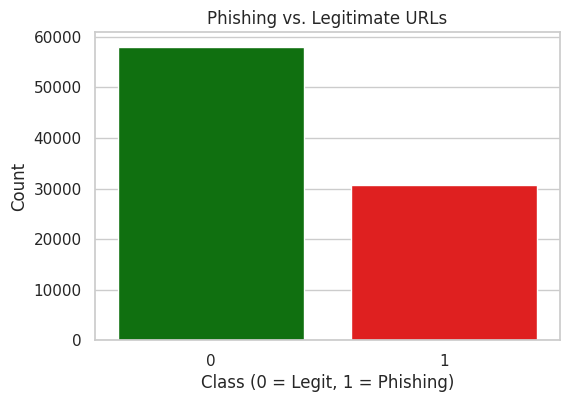

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid")

# 1️⃣ Check class distribution (phishing vs. non-phishing)
plt.figure(figsize=(6, 4))
sns.countplot(x='phishing', data=df, palette=['green', 'red'])
plt.title('Phishing vs. Legitimate URLs')
plt.xlabel('Class (0 = Legit, 1 = Phishing)')
plt.ylabel('Count')
plt.show()

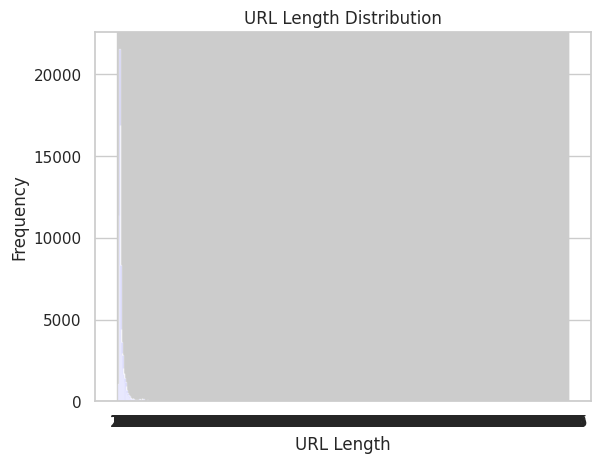

In [8]:
df['length_url'].hist(bins=range(0, max(df['length_url']) + 5, 5), color='blue', alpha=0.7)
plt.xticks(range(0, max(df['length_url']) + 5, 5))
plt.title('URL Length Distribution')
plt.xlabel('URL Length')
plt.ylabel('Frequency')
plt.show()

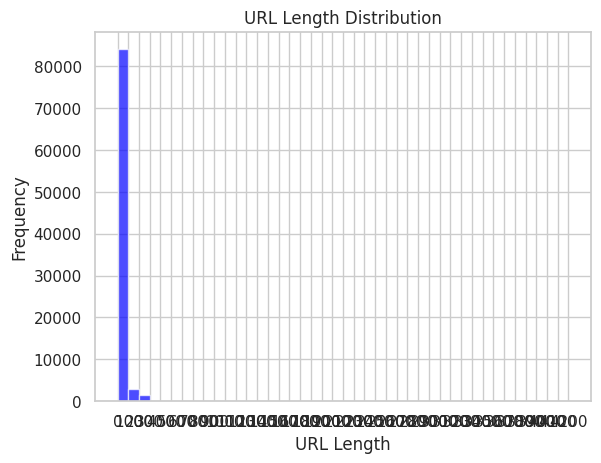

In [9]:
df['length_url'].hist(bins=range(0, max(df['length_url']) + 100, 100), color='blue', alpha=0.7)
plt.xticks(range(0, max(df['length_url']) + 100, 100))
plt.title('URL Length Distribution')
plt.xlabel('URL Length')
plt.ylabel('Frequency')
plt.show()

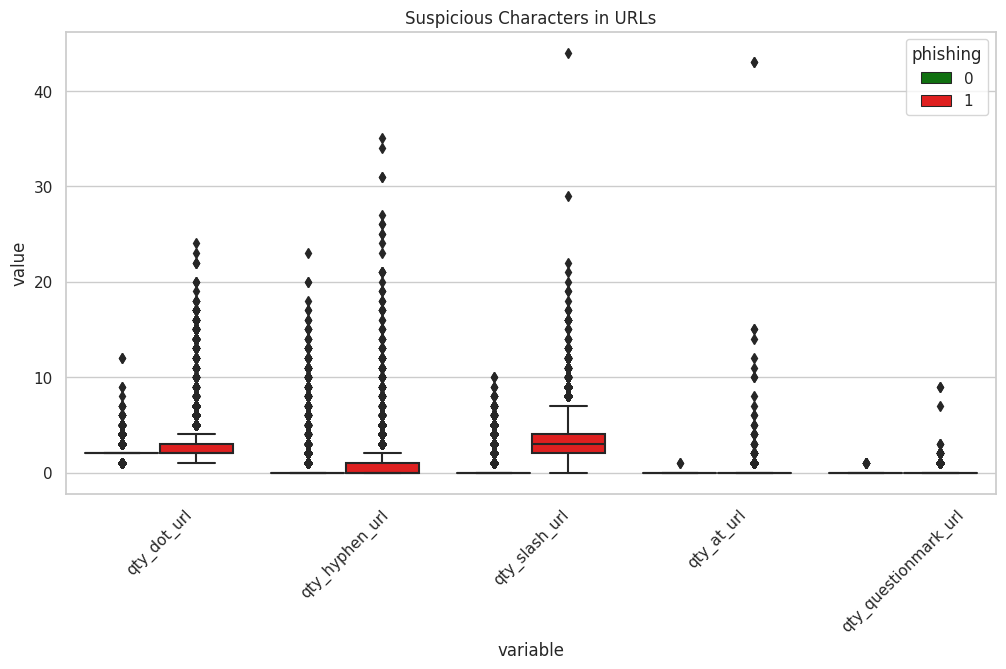

In [10]:
suspicious_chars = ['qty_dot_url', 'qty_hyphen_url', 'qty_slash_url', 'qty_at_url', 'qty_questionmark_url']
plt.figure(figsize=(12, 6))
df_melted = df.melt(id_vars=['phishing'], value_vars=suspicious_chars)
sns.boxplot(x='variable', y='value', hue='phishing', data=df_melted, palette=['green', 'red'])
plt.xticks(rotation=45)
plt.title('Suspicious Characters in URLs')
plt.show()

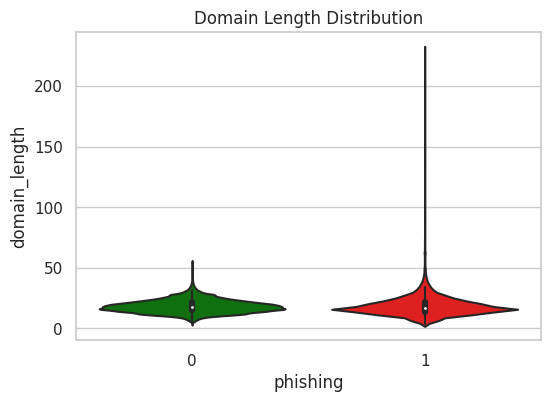

In [11]:
# 4️⃣ Violin plot for Domain Length
plt.figure(figsize=(6, 4))
sns.violinplot(x='phishing', y='domain_length', data=df, palette=['green', 'red'])
plt.title('Domain Length Distribution')
plt.show()

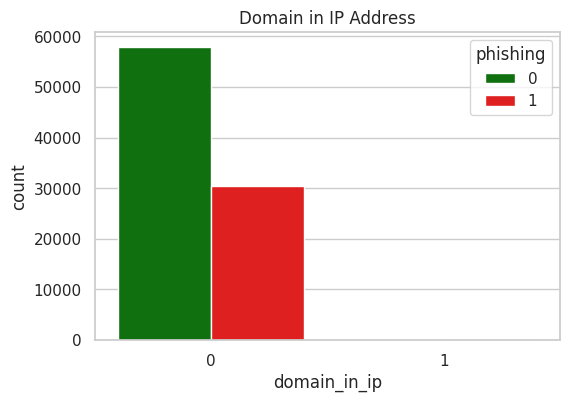

In [12]:
# 5️⃣ Countplot for Domain as IP
plt.figure(figsize=(6, 4))
sns.countplot(x='domain_in_ip', hue='phishing', data=df, palette=['green', 'red'])
plt.title('Domain in IP Address')
plt.show()

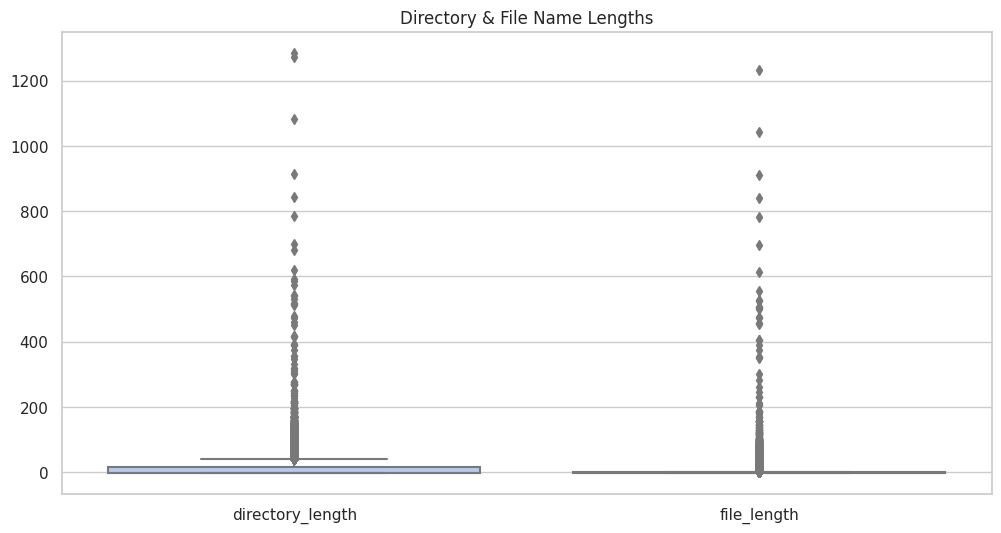

In [13]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['directory_length', 'file_length']], palette='coolwarm')
plt.title('Directory & File Name Lengths')
plt.show()


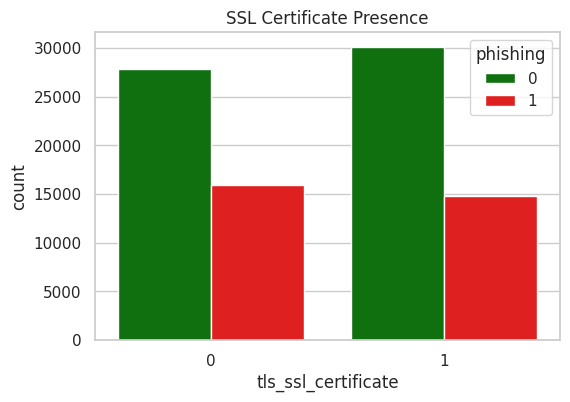

In [14]:
plt.figure(figsize=(6, 4))
sns.countplot(x='tls_ssl_certificate', hue='phishing', data=df, palette=['green', 'red'])
plt.title('SSL Certificate Presence')
plt.show()

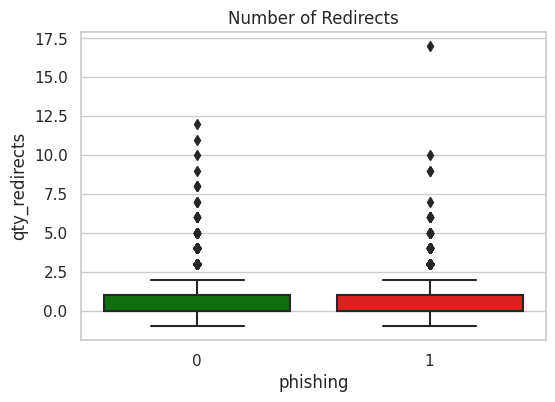

In [15]:
# 9️⃣ Boxplot for Number of Redirects
plt.figure(figsize=(6, 4))
sns.boxplot(x='phishing', y='qty_redirects', data=df, palette=['green', 'red'])
plt.title('Number of Redirects')
plt.show()


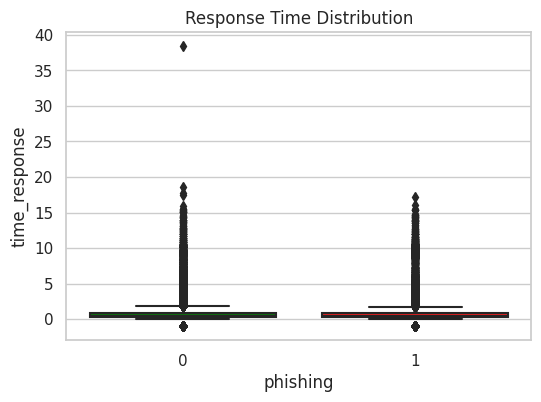

In [16]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='phishing', y='time_response', data=df, palette=['green', 'red'])
plt.title('Response Time Distribution')
plt.show()


In [17]:
# Unique values in 'phishing' column
print(df['phishing'].value_counts())


phishing
0    58000
1    30647
Name: count, dtype: int64


In [18]:
!pip install requests tldextract dnspython python-whois pandas
import time
import re
import socket
import ssl
import requests
from urllib.parse import urlparse, parse_qs
import tldextract
import dns.resolver
import whois
from datetime import datetime
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pickle
import concurrent.futures

# Feature Extraction Class
class MendeleyFeatureExtractor:
    """
    Extracts features from a URL in the same format as the Mendeley Phishing Dataset.
    """
    def __init__(self, timeout=10):
        """Initialize the extractor with a default timeout for network requests."""
        self.timeout = timeout
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }

    def extract_all_features(self, url):
        """Extract all features from a URL."""
        features = {}
        # Ensure URL has a scheme
        if not url.startswith(('http://', 'https://')):
            url = 'http://' + url

        # Basic URL parsing
        parsed_url = urlparse(url)
        extracted = tldextract.extract(url)
        domain = extracted.domain + '.' + extracted.suffix if extracted.suffix else extracted.domain

        # Split URL into components
        full_url = url
        domain_part = parsed_url.netloc
        path = parsed_url.path
        directory_part = '/'.join(path.split('/')[:-1]) if '/' in path else ''
        file_part = path.split('/')[-1] if path and '/' in path else ''
        params_part = parsed_url.query

        # Extract character counts for different URL components
        features.update(self._count_chars(full_url, 'url'))
        features.update(self._count_chars(domain_part, 'domain'))
        features.update(self._count_chars(directory_part, 'directory'))
        features.update(self._count_chars(file_part, 'file'))
        features.update(self._count_chars(params_part, 'params'))

        # Length features
        features['length_url'] = len(full_url)
        features['domain_length'] = len(domain_part)
        features['directory_length'] = len(directory_part)
        features['file_length'] = len(file_part)
        features['params_length'] = len(params_part)

        # Additional domain features
        features['qty_vowels_domain'] = sum(domain_part.lower().count(v) for v in 'aeiou')
        features['domain_in_ip'] = 1 if self._is_ip(domain_part) else 0
        features['server_client_domain'] = self._check_server_client(domain_part)

        # Params features
        features['tld_present_params'] = 1 if any(tld in params_part for tld in ['.com', '.org', '.net', '.edu']) else 0
        features['qty_params'] = len(parse_qs(params_part))

        # Email features
        features['email_in_url'] = 1 if re.search(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', full_url) else 0

        # Network and domain features - these require network requests
        with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
            # Submit all network-based tasks
            response_future = executor.submit(self._get_response_data, url)
            dns_future = executor.submit(self._get_dns_data, domain)
            whois_future = executor.submit(self._get_whois_data, domain)
            ssl_future = executor.submit(self._check_ssl, parsed_url.netloc)
            google_future = executor.submit(self._check_google_index, url, domain)

            # Get results as they complete
            features.update(response_future.result())
            features.update(dns_future.result())
            features.update(whois_future.result())
            features.update(ssl_future.result())
            features.update(google_future.result())

        # Convert all values to int except time_response
        for key in features:
            if key != 'time_response' and not isinstance(features[key], int):
                try:
                    features[key] = int(features[key])
                except:
                    features[key] = 0

        return features

    def _count_chars(self, text, component):
        """Count occurrences of different characters in the given text component."""
        if not text:
            text = ""
        chars = {
            'dot': '.',
            'hyphen': '-',
            'underline': '_',
            'slash': '/',
            'questionmark': '?',
            'equal': '=',
            'at': '@',
            'and': '&',
            'exclamation': '!',
            'space': ' ',
            'tilde': '~',
            'comma': ',',
            'plus': '+',
            'asterisk': '*',
            'hashtag': '#',
            'dollar': '$',
            'percent': '%'
        }
        result = {}
        for char_name, char in chars.items():
            result[f'qty_{char_name}_{component}'] = text.count(char)
        # Add TLD count for URL
        if component == 'url':
            result['qty_tld_url'] = sum(1 for tld in ['.com', '.org', '.net', '.edu', '.gov', '.mil', '.int'] if tld in text)
        return result

    def _is_ip(self, domain):
        """Check if domain is an IP address."""
        ip_pattern = re.compile(r'^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$')
        return bool(ip_pattern.match(domain))

    def _check_server_client(self, domain):
        """Check for server/client terminology in domain."""
        server_client_terms = ['server', 'client', 'host', 'proxy']
        return 1 if any(term in domain.lower() for term in server_client_terms) else 0

    def _get_response_data(self, url):
        """Get data from HTTP response."""
        result = {
            'time_response': 0.0,
            'qty_redirects': 0,
            'url_shortened': 0
        }
        try:
            start_time = time.time()
            response = requests.get(url, headers=self.headers, timeout=self.timeout, allow_redirects=True)
            result['time_response'] = time.time() - start_time
            # Check redirects
            if response.history:
                result['qty_redirects'] = len(response.history)
            # Check for URL shorteners
            shortener_domains = ['bit.ly', 'tinyurl.com', 'goo.gl', 't.co', 'tr.im', 'is.gd', 'cli.gs', 'ow.ly', 'twurl.nl', 'snipurl.com', 'short.to']
            first_url = response.history[0].url if response.history else ""
            result['url_shortened'] = 1 if any(sd in first_url for sd in shortener_domains) else 0
        except Exception as e:
            pass
        return result

    def _get_dns_data(self, domain):
        """Get DNS related data."""
        result = {
            'domain_spf': 0,
            'asn_ip': 0,
            'qty_ip_resolved': 0,
            'qty_nameservers': 0,
            'qty_mx_servers': 0,
            'ttl_hostname': 0
        }
        try:
            # Try to get IP addresses
            try:
                ip_addresses = socket.gethostbyname_ex(domain)[2]
                result['qty_ip_resolved'] = len(ip_addresses)
            except:
                pass
            # Try to get name servers
            try:
                ns_records = dns.resolver.resolve(domain, 'NS')
                result['qty_nameservers'] = len(ns_records)
            except:
                pass
            # Try to get MX records
            try:
                mx_records = dns.resolver.resolve(domain, 'MX')
                result['qty_mx_servers'] = len(mx_records)
            except:
                pass
            # Try to get TTL
            try:
                a_records = dns.resolver.resolve(domain, 'A')
                result['ttl_hostname'] = a_records.rrset.ttl
            except:
                pass
            # Try to get SPF record
            try:
                txt_records = dns.resolver.resolve(domain, 'TXT')
                for record in txt_records:
                    if 'spf' in str(record).lower():
                        result['domain_spf'] = 1
                        break
            except:
                pass
            # Get ASN (this is a simplified approach)
            try:
                socket.setdefaulttimeout(3)
                ip = socket.gethostbyname(domain)
                asn_query = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
                asn_query.connect(('whois.cymru.com', 43))
                asn_query.send(f' -v {ip}\n'.encode())
                asn_data = asn_query.recv(4096).decode()
                asn_query.close()
                for line in asn_data.splitlines():
                    if ip in line:
                        parts = line.split('|')
                        if len(parts) > 1:
                            asn = parts[0].strip()
                            if asn.isdigit():
                                result['asn_ip'] = int(asn)
                                break
            except:
                pass
        except Exception as e:
            pass
        return result

    def _get_whois_data(self, domain):
        """Get WHOIS data."""
        result = {
            'time_domain_activation': 0,
            'time_domain_expiration': 0
        }
        try:
            domain_info = whois.whois(domain)
            # Get creation date
            if domain_info.creation_date:
                if isinstance(domain_info.creation_date, list):
                    creation_date = domain_info.creation_date[0]
                else:
                    creation_date = domain_info.creation_date
                if isinstance(creation_date, datetime):
                    # Calculate days since creation
                    days_since_creation = (datetime.now() - creation_date).days
                    result['time_domain_activation'] = max(0, days_since_creation)
            # Get expiration date
            if domain_info.expiration_date:
                if isinstance(domain_info.expiration_date, list):
                    expiration_date = domain_info.expiration_date[0]
                else:
                    expiration_date = domain_info.expiration_date
                if isinstance(expiration_date, datetime):
                    # Calculate days until expiration
                    days_until_expiration = (expiration_date - datetime.now()).days
                    result['time_domain_expiration'] = max(0, days_until_expiration)
        except Exception as e:
            pass
        return result

    def _check_ssl(self, domain):
        """Check SSL/TLS certificate."""
        result = {
            'tls_ssl_certificate': 0
        }
        try:
            context = ssl.create_default_context()
            with socket.create_connection((domain, 443), timeout=3) as sock:
                with context.wrap_socket(sock, server_hostname=domain) as ssock:
                    cert = ssock.getpeercert()
                    if cert:
                        result['tls_ssl_certificate'] = 1
        except:
            pass
        return result

    def _check_google_index(self, url, domain):
        """Check if URL and domain are indexed by Google."""
        result = {
            'url_google_index': 0,
            'domain_google_index': 0
        }
        # NOTE: Accurately checking Google indexing requires using their API or scraping
        # which can be complex. This is a simplified approach that uses the cache: syntax
        try:
            # Instead of actually querying Google (which could get your IP blocked),
            # we'll make a simple heuristic based on domain age and SSL
            # Real implementation would use Google Search Console API or a service like
            # SerpAPI
            # For demonstration only - in a real implementation, use a proper method
            # This is a heuristic that assumes domains older than 60 days with SSL 
            # are likely indexed by Google
            try:
                domain_info = whois.whois(domain)
                if domain_info.creation_date:
                    if isinstance(domain_info.creation_date, list):
                        creation_date = domain_info.creation_date[0]
                    else:
                        creation_date = domain_info.creation_date
                    if isinstance(creation_date, datetime):
                        days_since_creation = (datetime.now() - creation_date).days
                        if days_since_creation > 60:
                            # Check SSL as another indicator
                            context = ssl.create_default_context()
                            with socket.create_connection((domain, 443), timeout=3) as sock:
                                with context.wrap_socket(sock, server_hostname=domain) as ssock:
                                    if ssock.getpeercert():
                                        result['domain_google_index'] = 1
                            # Assume URL is indexed if domain is
                            result['url_google_index'] = 1
            except:
                pass
        except:
            pass
        return result

# Dataset Class
class PhishingDataset(Dataset):
    """Dataset for phishing detection."""
    def __init__(self, df, target_column='phishing'):
        self.df = df.copy()
        self.target_column = target_column
        self.features = self.df.drop(columns=[target_column])
        self.targets = self.df[target_column].values
        self.scaler = StandardScaler()
        self.scaled_features = self.scaler.fit_transform(self.features)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return {
            'features': torch.tensor(self.scaled_features[idx], dtype=torch.float32),
            'target': torch.tensor(self.targets[idx], dtype=torch.float32)
        }

# Self-Attention Module (Multi-Head Attention)
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"
        
        # Linear projections for Q, K, V
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        
        # Linear projections
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)
        
        # Reshape for multi-head attention
        q = q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Scaled dot-product attention
        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn_weights = torch.softmax(scores, dim=-1)
        context = torch.matmul(attn_weights, v)
        
        # Reshape back
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.embed_dim)
        
        # Final projection
        output = self.out_proj(context)
        return output

# Transformer Layer
class TransformerLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super(TransformerLayer, self).__init__()
        self.self_attn = MultiHeadSelfAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, embed_dim),
            nn.Dropout(dropout)
        )
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # Self-attention block with residual connection
        attn_output = self.self_attn(x)
        x = self.norm1(x + self.dropout(attn_output))
        
        # Feed-forward block with residual connection
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout(ff_output))
        
        return x

# Custom Transformer Model for Phishing Detection
class PhishingTransformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim=64, num_heads=4, num_layers=2, ff_dim=128, dropout=0.1, num_classes=1):
        super(PhishingTransformerModel, self).__init__()
        
        # Feature embedding (tokenization equivalent for tabular data)
        self.embedding = nn.Linear(1, embed_dim)
        
        # Positional encoding
        self.register_buffer("pos_encoding", self._get_positional_encoding(5000, embed_dim))
        
        # Transformer layers
        self.transformer_layers = nn.ModuleList([
            TransformerLayer(embed_dim, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, num_classes),
            nn.Sigmoid()
        )
        
    def _get_positional_encoding(self, max_seq_len, d_model):
        # Create positional encoding
        pe = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        return pe.unsqueeze(0)
        
    def forward(self, x):
        # x shape: [batch_size, input_dim]
        batch_size, seq_len = x.size()
        
        # Convert features into tokens (reshape to [batch_size, seq_len, 1])
        x = x.unsqueeze(2)
        
        # Project each feature to embedding dimension (tokenization)
        x = self.embedding(x)  # [batch_size, seq_len, embed_dim]
        
        # Add positional encoding
        x = x + self.pos_encoding[:, :seq_len, :]
        
        # Apply transformer layers
        for layer in self.transformer_layers:
            x = layer(x)
        
        # Global average pooling over the sequence dimension
        x = torch.mean(x, dim=1)  # [batch_size, embed_dim]
        
        # Classification
        x = self.classifier(x)  # [batch_size, num_classes]
        
        return x

# Training Function
def train_model(model, train_loader, val_loader, device, config):
    """Train the phishing detection model."""
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    criterion = nn.BCELoss()

    for epoch in range(config['epochs']):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']} (Train)"):
            features = batch['features'].to(device)
            targets = batch['target'].to(device)

            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, targets.unsqueeze(1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = (outputs > 0.5).float()
            train_correct += (preds == targets.unsqueeze(1)).sum().item()
            train_total += targets.size(0)

        train_accuracy = train_correct / train_total
        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch in val_loader:
                features = batch['features'].to(device)
                targets = batch['target'].to(device)

                outputs = model(features)
                loss = criterion(outputs, targets.unsqueeze(1))
                val_loss += loss.item()
                preds = (outputs > 0.5).float()
                val_correct += (preds == targets.unsqueeze(1)).sum().item()
                val_total += targets.size(0)

        val_accuracy = val_correct / val_total
        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}/{config['epochs']} - "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    return model

# Function to extract features from a URL
def extract_features_from_url(url):
    """Extract features from a URL and return as a DataFrame."""
    extractor = MendeleyFeatureExtractor()
    features = extractor.extract_all_features(url)
    return pd.DataFrame([features])

# Testing Function
def test_url(url, model, scaler, device):
    """Test a URL using the phishing detection model."""
    features_df = extract_features_from_url(url)
    
    # Get the feature names from the scaler (features used during training)
    feature_names = scaler.feature_names_in_
    
    # Create a DataFrame with the expected columns, initialized with zeros
    aligned_features = pd.DataFrame(0, index=[0], columns=feature_names)
    
    # Fill in the values for features that exist in the extracted features
    for col in features_df.columns:
        if col in feature_names:
            aligned_features[col] = features_df[col].values
    
    # Transform the aligned features
    features_tensor = torch.tensor(scaler.transform(aligned_features), dtype=torch.float32).to(device)
    
    with torch.no_grad():
        output = model(features_tensor)
        prediction = (output > 0.5).float().item()
    
    print(f"The URL '{url}' is classified as {'PHISHING' if prediction == 1 else 'LEGITIMATE'}.")

# Main Function
if __name__ == "__main__":
    # Load dataset
    df = pd.read_csv('/kaggle/input/mendely2020/dataset_full.csv')
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

    # Create datasets
    train_dataset = PhishingDataset(train_df)
    val_dataset = PhishingDataset(val_df)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Create model
    input_dim = train_dataset.features.shape[1]
    model = PhishingTransformerModel(
        input_dim=input_dim,
        embed_dim=64,
        num_heads=4,
        num_layers=2,
        ff_dim=128,
        dropout=0.1
    )

    # Training configuration
    config = {
        'epochs': 10,
        'learning_rate': 1e-3
    }

    # Train model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = train_model(model, train_loader, val_loader, device, config)

    # Save model and scaler
    torch.save(model.state_dict(), '/kaggle/working/phishing_transformer_best.pt')
    with open('/kaggle/working/tabular_scaler.pkl', 'wb') as f:
        pickle.dump(train_dataset.scaler, f)

    # Test a URL
    url = "https://www.bmu.edu.in/"
    test_url(url, model, train_dataset.scaler, device)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 7.4 MB/s eta 0:00:00


Epoch 1/10 (Train): 100%|██████████| 2217/2217 [00:16<00:00, 137.17it/s]


Epoch 1/10 - Train Loss: 0.2357, Train Accuracy: 0.9015, Val Loss: 0.1937, Val Accuracy: 0.9166


Epoch 2/10 (Train): 100%|██████████| 2217/2217 [00:14<00:00, 150.39it/s]


Epoch 2/10 - Train Loss: 0.1852, Train Accuracy: 0.9227, Val Loss: 0.1690, Val Accuracy: 0.9305


Epoch 3/10 (Train): 100%|██████████| 2217/2217 [00:14<00:00, 150.80it/s]


Epoch 3/10 - Train Loss: 0.1645, Train Accuracy: 0.9328, Val Loss: 0.1669, Val Accuracy: 0.9359


Epoch 4/10 (Train): 100%|██████████| 2217/2217 [00:14<00:00, 149.23it/s]


Epoch 4/10 - Train Loss: 0.1543, Train Accuracy: 0.9383, Val Loss: 0.1441, Val Accuracy: 0.9429


Epoch 5/10 (Train): 100%|██████████| 2217/2217 [00:14<00:00, 151.29it/s]


Epoch 5/10 - Train Loss: 0.1479, Train Accuracy: 0.9417, Val Loss: 0.1710, Val Accuracy: 0.9335


Epoch 6/10 (Train): 100%|██████████| 2217/2217 [00:14<00:00, 151.24it/s]


Epoch 6/10 - Train Loss: 0.1430, Train Accuracy: 0.9434, Val Loss: 0.1383, Val Accuracy: 0.9473


Epoch 7/10 (Train): 100%|██████████| 2217/2217 [00:14<00:00, 151.29it/s]


Epoch 7/10 - Train Loss: 0.1398, Train Accuracy: 0.9456, Val Loss: 0.1377, Val Accuracy: 0.9450


Epoch 8/10 (Train): 100%|██████████| 2217/2217 [00:14<00:00, 150.94it/s]


Epoch 8/10 - Train Loss: 0.1375, Train Accuracy: 0.9468, Val Loss: 0.1488, Val Accuracy: 0.9430


Epoch 9/10 (Train): 100%|██████████| 2217/2217 [00:14<00:00, 150.19it/s]


Epoch 9/10 - Train Loss: 0.1341, Train Accuracy: 0.9484, Val Loss: 0.1569, Val Accuracy: 0.9371


Epoch 10/10 (Train): 100%|██████████| 2217/2217 [00:14<00:00, 152.28it/s]


Epoch 10/10 - Train Loss: 0.1319, Train Accuracy: 0.9482, Val Loss: 0.1516, Val Accuracy: 0.9422
The URL 'https://www.bmu.edu.in/' is classified as LEGITIMATE.
